In [1]:
# code from laptop
from cmath import nan
from traceback import format_exception_only
#from eagerpy import zeros_like
import scipy.io as scio
import numpy as np
import matplotlib.pyplot as plt
import copy
from sklearn.tree import plot_tree
import mtools as mot
from scipy.stats import ranksums
from os.path import exists
from matplotlib.colors import ListedColormap
import seaborn as sns
from matplotlib import gridspec
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import matplotlib as mpl
import matplotlib.cm as cm
import random
import pickle
import scipy.io as spio
import pandas as pd
import matplotlib.animation as animation
from scipy.signal import find_peaks
from scipy.stats import pearsonr
from scipy.stats import mannwhitneyu


import matplotlib.pyplot as plt
import scipy.signal
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import scipy.stats as stats
import scikit_posthocs as sp

In [2]:
def count_correct_and_failed_trials(df_fr_learning):
    trial_cnt_correct=0
    trial_cnt_failed=0
    #df_fr_learning= df_fr[df_fr['Category']=='learned']
    for session in df_fr_learning['Session'].unique():
        # Extract data for the current session
        session_data = df_fr_learning[df_fr_learning['Session'] == session]
        correct_cnt=session_data[session_data['ResultType']=='correct']
        failed_cnt=session_data[session_data['ResultType']=='failed']

        # Get Trial_cnt for the current session
        trial_cnt_correct += correct_cnt['Trial_cnt'].tolist()[0]
        if len ( failed_cnt['Trial_cnt'].tolist())>0:
            trial_cnt_failed += failed_cnt['Trial_cnt'].tolist()[0]
    return trial_cnt_correct ,trial_cnt_failed

In [3]:
#folders = ['485']

place_cells=False# consider only place cells for analysis(list of the cells should be loaded)
cell_types='All'

nrm = np.load('nrm.npy',allow_pickle=True)
clusteringmethod = 'AHC'
Mode = 0 # this belongs to the old code and can be removed
#signal_type = input()
signal_type = 'transients'
#signal_type = 'traces'
fs=20# sampling freq

# thr_burts = 2# threshold for burst detection
# winlen = 10*fs# 10 sec cunnks for burst detection

tau=.001# deconv parameter
SpeedLimint=10# is not applied anymore
min_ratio = 1 # threshold to exclude bad templates
#folders = ['478']
# deadtime interval for burst detection
# global Tspare
# Tspare= .5# events window time

speed_thr=0# threshold to remove datapoint with low speed

burst_len='0.5s'


trial_thr=2# minimum number of trials requiered for classfication


trend_colors = colors = plt.cm.Set1(range(4))

# descriotor='all_days_original_bursts_neworder'+burst_len+'_transients'+'aranaandsleep'
# descriotor='all_days_original_bursts_neworder'+burst_len+'_transients'


descriotor='No_chunk_'+burst_len+'_transients'#+'Randomized_seqs'

place_cell_name='All'


# savefolder ='C:/Users/hamed/Desktop/Hamed/BCN/sequence/results/'
# datafolder='C:/Users/hamed/Desktop/Hamed/BCN/sequence/data/GCaMP6f_478-485/'
savefolder = 'C:/Users/hamed/Desktop/Hamed/Github/TP7/results/'
datafolder = 'C:/Users/hamed/Desktop/Hamed/Github/TP7/data/GCaMP6f_478-485/'


In [4]:

allfolders2 = ['481', '483', '485', '478']
rows_list = []

for fol1 in allfolders2:
    allccrs,cond_results_allsess_loaded=np.load(savefolder+fol1+'pvalues'+'_'+place_cell_name+'_'+cell_types+'_'+descriotor,allow_pickle=True)


In [5]:
savefolder+fol1+'pvalues'+'_'+place_cell_name+'_'+cell_types+'_'+descriotor

'C:/Users/hamed/Desktop/Hamed/Github/TP7/results/478pvalues_All_All_No_chunk_0.5s_transients'

In [6]:


allfolders2 = ['481', '483', '485', '478']
rows_list = []

for fol1 in allfolders2:
    allccrs,cond_results_allsess_loaded=np.load(savefolder+fol1+'pvalues'+'_'+place_cell_name+'_'+cell_types+'_'+descriotor,allow_pickle=True)

    
    for session_name, session_data in cond_results_allsess_loaded.items():
        # Determine session type based on session name or another attribute
        session_type = 'learned' if 'learned' in session_name else 'learning'
        
        for category, value in session_data['fr'].items():
            label = 'failed' if 'failed' in category else 'correct'
            type_clean = category.replace('failed', '').replace('correct', '')
            
            trial_nbr = len((session_data['firingrates'][category]))
            if 'inward' in category or 'outward' in category:
                trial_nbr=trial_nbr/2
            row = {
                'Experiment': fol1,
                'Session': session_name,
                'Category': session_type,
                'Metric': type_clean,
                'ResultType': label,
                'Value': value,
                'Trial_cnt': trial_nbr
            }
            rows_list.append(row)

df_fr = pd.DataFrame(rows_list)



In [7]:


def analyze_and_plot(df, title,ylablel):
    # Splitting the data into learning and learned for the given DataFrame
    learning_values = df[df['Category'] == 'learning']['Value'].tolist()
    learned_values = df[df['Category'] == 'learned']['Value'].tolist()

    # Perform the Mann-Whitney U test
    stat, p_value = mannwhitneyu(learning_values, learned_values, alternative='two-sided')
    print(f'{title} - Mann-Whitney U test p-value: {p_value}')

    # Visualize the results with box plots
    plt.figure(figsize=(4,3))
    data_to_plot = [learning_values, learned_values]
    positions = [1, 2]
    labels = ['Learning', 'Learned']
    colors=[f'C{0}',f'C{1}']

    bplot=plt.boxplot(data_to_plot, positions=positions, widths=0.6, patch_artist=True)
    plt.xticks(positions, labels)
    highest_point = max(max(learning_values, default=0), max(learned_values, default=0))-.5 #* 1.01

    plt.text(1.5, highest_point, f'p={p_value:.3f}', ha='center', va='bottom', fontsize=14, color='k')
    for patch, color in zip(bplot['boxes'], colors):
        patch.set_facecolor(color)
    # Annotate significant difference
    if p_value < 0.05:
        plt.text(1.5, highest_point, '*', ha='center', va='bottom', fontsize=14, color='red')

    plt.title(title)
    plt.ylabel(ylablel)
    plt.tight_layout()
    plt.show()

In [8]:


def plot_combined(df, category,ylabel):
    # Setting up the plot
    fig, ax = plt.subplots(figsize=(6, 4))
    metrics = ['outward', 'inward', 'sampling', 'reward']
    colors = ['lightblue', 'lightgreen']  # Colors for correct and failed
    n_metrics = len(metrics)
    width = 0.35  # Width of the box plots

    # Positions of the box plots
    positions_correct = np.arange(1, n_metrics * 2, 2)
    positions_failed = positions_correct + width

    for i, metric in enumerate(metrics):
        # Extracting correct and failed values for the metric and category
        correct_values = df[(df['Category'] == category) & (df['Metric'].str.contains(metric)) & (df['ResultType'] == 'correct')]['Value']
        failed_values = df[(df['Category'] == category) & (df['Metric'].str.contains(metric)) & (df['ResultType'] == 'failed')]['Value']
        
        # Box plot for correct
        bp_correct = ax.boxplot(correct_values, positions=[positions_correct[i]], widths=width, patch_artist=True, boxprops=dict(facecolor=colors[0]), labels=[f'{metric}\nCorrect'])
        
        # Box plot for failed
        bp_failed = ax.boxplot(failed_values, positions=[positions_failed[i]], widths=width, patch_artist=True, boxprops=dict(facecolor=colors[1]), labels=[f'{metric}\nFailed'])
        
        # Statistical test and annotation
        if not correct_values.empty and not failed_values.empty:
            stat, p_value = mannwhitneyu(correct_values.dropna(), failed_values.dropna(), alternative='two-sided')
            height = max(correct_values.max(), failed_values.max()) + ax.get_ylim()[1] * 0.05  # Calculate height for annotation based on values and a small offset

                        # Annotate with p-value
            ax.text((positions_correct[i] + positions_failed[i]) / 2, height-.01, f'p={p_value:.3f}', ha='center', va='bottom', fontsize=10)

            if p_value < 0.05:
                ax.text((positions_correct[i] + positions_failed[i]) / 2, height-.11, '*', ha='center', va='bottom', color='red', fontsize=24)

    # Customizing the plot
    ax.set_title(f'{category.capitalize()} - Correct vs. Failed '+burst_len)
    ax.set_ylabel(ylabel)
    if 'Sequence' in ylabel:
        ax.set_ylim([0,2.3])
    ax.legend([bp_correct["boxes"][0], bp_failed["boxes"][0]], ['Correct', 'Failed'], loc='upper left',fontsize=12)
    ax.set_xticks(np.mean([positions_correct, positions_failed], axis=0))
    ax.set_xticklabels(metrics)
    ax.set_xlim(0, positions_failed[-1] + width)
    plt.tight_layout()
    #plt.show()

In [9]:

def analyze_and_plot_learning_learned(df, title,ylabel):    
# Splitting the data into learning and learned for the given DataFrame
    correct_values = df[df['ResultType'] == 'correct']['Value'].tolist()
    failed_values = df[df['ResultType'] == 'failed']['Value'].tolist()
    colors = ['lightblue', 'lightgreen']  # Colors for correct and failed

    # Perform the Mann-Whitney U test
    stat, p_value = mannwhitneyu(correct_values, failed_values, alternative='two-sided')
    print(f'{title} - Mann-Whitney U test p-value: {p_value}')

    # Visualize the results with box plots
    plt.figure(figsize=(4,3))
    data_to_plot = [correct_values, failed_values]
    positions = [1, 2]
    labels = ['Correct', 'Failed']

    bplot =plt.boxplot(data_to_plot, positions=positions, widths=0.6,patch_artist=True)
    plt.xticks(positions, labels)

    for patch, color in zip(bplot['boxes'], colors):
        patch.set_facecolor(color)
    # Annotate significant difference
    highest_point = max(max(correct_values, default=0), max(failed_values, default=0)) * 1.1

    if 'Sequence' in ylabel:
        highest_point=1   
        plt.ylim([0,1.3])

    plt.text(1.5, highest_point-2.01, f'p={p_value:.2f}', ha='center', va='bottom', fontsize=10)

    if p_value < 0.05:
        plt.text(1.5, highest_point-2.2, '*', ha='center', va='bottom', fontsize=24, color='red')

    plt.title(title)
    plt.ylabel(ylabel)
    plt.tight_layout()
    plt.show()

In [10]:
def plot_grouped_data_with_nonparametric_stats_fr(df, title):
    plt.figure(figsize=(6, 4))
    metrics = df['Metric'].unique()
    categories = ['learning', 'learned']
    num_metrics = len(metrics)
    width = 0.35  # Adjust width for clarity if needed

    # Adjust the y-axis limit dynamically
    all_values = df['Value'].values
    ylim_upper = np.max(all_values) * 1.1  # Increase the upper limit by 10% for annotation space

    for i, metric in enumerate(metrics):
        for j, category in enumerate(categories):
            subset = df[(df['Metric'] == metric) & (df['Category'] == category)]
            values = subset['Value'].tolist()
            pos = i + (j - 0.5) * width
            plt.boxplot(values, positions=[pos], widths=width, patch_artist=True,
                        boxprops=dict(facecolor=f'C{j}'), labels=[f'{metric}\n{category}'] if j == 1 else None)

            if len(values) > 0:  # Check to ensure there are values to avoid plotting errors
                # Find the highest point for potentially placing the star
                high_point = max(values)

        # Perform the Mann-Whitney U test between learning and learned for each metric
        learning_values = df[(df['Metric'] == metric) & (df['Category'] == 'learning')]['Value'].tolist()
        learned_values = df[(df['Metric'] == metric) & (df['Category'] == 'learned')]['Value'].tolist()
        
        if learning_values and learned_values:  # Ensure both categories have data
            stat, p_value = mannwhitneyu(learning_values, learned_values, alternative='two-sided')
            plt.text(i, ylim_upper-.235, f'p={p_value:.2f}', ha='center', va='bottom', fontsize=14, color='k')

            print(p_value)
            if p_value < 0.05:
                star_pos = i  # Position the star in the middle of the pair
                # Use the updated ylim_upper for positioning the star
                plt.text(star_pos, ylim_upper-.234, '*', ha='center', va='bottom', fontsize=24, color='red')

    plt.legend(['Learning', 'Learned'], loc='upper right',fontsize=12)
    plt.xticks(np.arange(num_metrics), metrics)
    plt.ylim(0, ylim_upper)  # Set the y-axis limit to include space for the star
    plt.title(title)
    #plt.xlabel('Metric')
    plt.ylabel('Sequence rate')
    plt.ylim([0,2.52])
    plt.tight_layout()
   # plt.show()

0.9047619047619049
0.7301587301587302
0.015873015873015872
0.031746031746031744


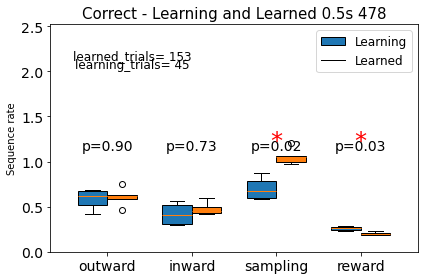

0.05714285714285714
0.6857142857142857
0.02857142857142857
0.05714285714285714


<Figure size 432x288 with 0 Axes>

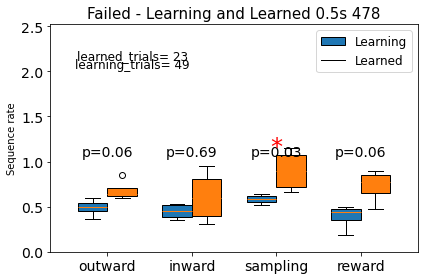

0.7301587301587302
0.015873015873015872
0.4126984126984127
0.015873015873015872


<Figure size 432x288 with 0 Axes>

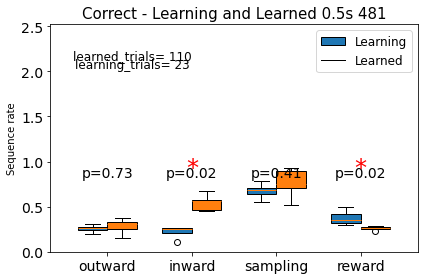

0.19047619047619047
0.19047619047619047
0.19047619047619047
0.06349206349206349


<Figure size 432x288 with 0 Axes>

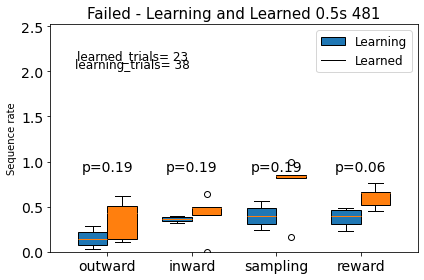

1.0
0.7301587301587302
0.015873015873015872
0.19047619047619047


<Figure size 432x288 with 0 Axes>

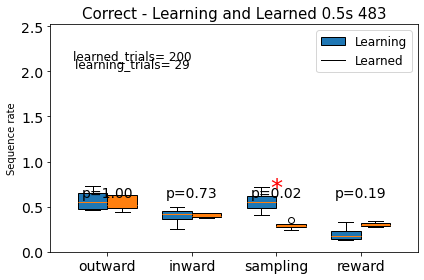

0.34285714285714286
0.4857142857142857
0.8845494388529623
0.02857142857142857


<Figure size 432x288 with 0 Axes>

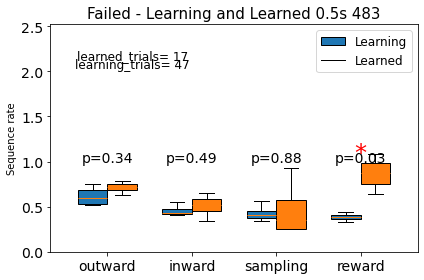

0.14285714285714285
0.25
0.03571428571428571
0.7857142857142857


<Figure size 432x288 with 0 Axes>

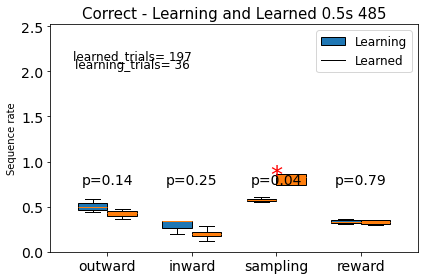

0.39285714285714285
0.14285714285714285
0.03571428571428571
0.03571428571428571


<Figure size 432x288 with 0 Axes>

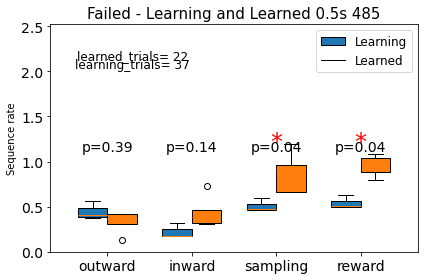

0.7769213274105322
0.12935086425083492
0.12114151600411802
0.5374546118808793


<Figure size 432x288 with 0 Axes>

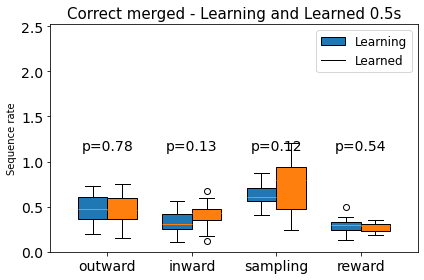

0.2861639071174894
0.13350158643229745
0.0032073702388864785
1.1187855507857074e-05


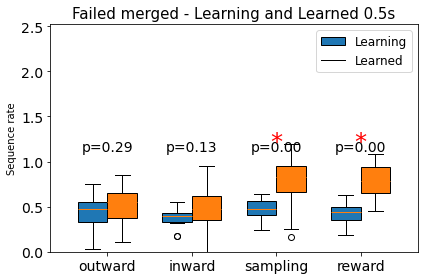

In [11]:
plt.rcParams.update({'font.size': 15})
plt.rcParams['axes.titlesize'] = 15  # Set the title font size
plt.rcParams['xtick.labelsize'] = 14  # You can adjust the font size as needed
plt.rcParams['ytick.labelsize'] = 14  # You can adjust the font size as needed

# Splitting the DataFrame into correct and failed results
df_correct_fr = df_fr[df_fr['ResultType'] == 'correct']
df_failed_fr = df_fr[df_fr['ResultType'] == 'failed']


# Plotting the data for 'correct' and 'failed' results with Mann-Whitney U tests

animal_nbr='478'
animallist=['478','481','483','485']

for animal_nbr in animallist:

    df_correct_anm_fr=df_correct_fr[df_correct_fr['Experiment']==animal_nbr]
    df_failed_anm_fr=df_failed_fr[df_failed_fr['Experiment']==animal_nbr]
    plot_grouped_data_with_nonparametric_stats_fr(df_correct_anm_fr, 'Correct - Learning and Learned '+burst_len+ ' '+animal_nbr)

    # Drop duplicate sessions to consider only unique sessions
    unique_sessions_df = df_correct_anm_fr.drop_duplicates(subset=['Session'])
    trial_counts_correct = unique_sessions_df.groupby('Category')['Trial_cnt'].sum()
    categories = trial_counts_correct.index.values
    counts = trial_counts_correct.values
    # Plot trial counts for each category
    plt.text(.3, 2, 'learning_trials= {}'.format(int(counts[categories.tolist().index('learning')])), ha='center', va='bottom',fontsize=12)
    plt.text(.3, 2.1, 'learned_trials= {}'.format(int(counts[categories.tolist().index('learned')])), ha='center', va='bottom',fontsize=12)
    plt.show()
    plt.savefig(savefolder+ animal_nbr+'sequencerate_correct', dpi=300, facecolor='w')

    plot_grouped_data_with_nonparametric_stats_fr(df_failed_anm_fr, 'Failed - Learning and Learned '+burst_len+ ' '+animal_nbr)
    # Drop duplicate sessions to consider only unique sessions
    unique_sessions_df = df_failed_anm_fr.drop_duplicates(subset=['Session'])
    trial_counts_failed = unique_sessions_df.groupby('Category')['Trial_cnt'].sum()
    categories = trial_counts_failed.index.values
    counts = trial_counts_failed.values
    # Plot trial counts for each category
    plt.text(.3, 2, 'learning_trials= {}'.format(int(counts[categories.tolist().index('learning')])), ha='center', va='bottom',fontsize=12)
    plt.text(.3, 2.1, 'learned_trials= {}'.format(int(counts[categories.tolist().index('learned')])), ha='center', va='bottom',fontsize=12)
    plt.show()

    plt.savefig(savefolder+ animal_nbr+'sequencerate_failed', dpi=300, facecolor='w')


plot_grouped_data_with_nonparametric_stats_fr(df_correct_fr, 'Correct merged - Learning and Learned '+burst_len)
plt.show()
plot_grouped_data_with_nonparametric_stats_fr(df_failed_fr, 'Failed merged - Learning and Learned '+burst_len)
plt.show()

Correct - Overall Learning vs Learned 0.5s - Mann-Whitney U test p-value: 0.7473588979020831


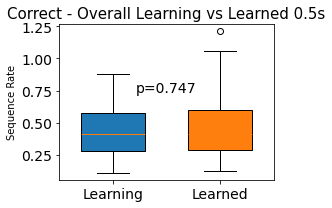

Failed - Overall Learning vs Learned 0.5s - Mann-Whitney U test p-value: 2.62655626729193e-06


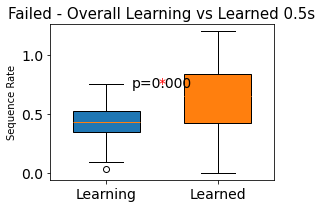

In [18]:
analyze_and_plot(df_correct_fr, 'Correct - Overall Learning vs Learned '+burst_len,"Sequence Rate")

# Analyze and plot for failed results
analyze_and_plot(df_failed_fr, 'Failed - Overall Learning vs Learned '+burst_len,"Sequence Rate")

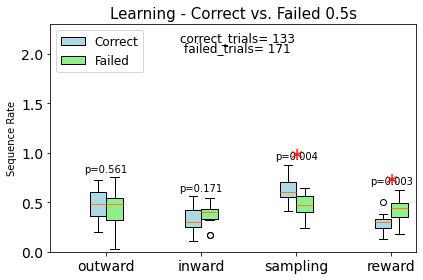

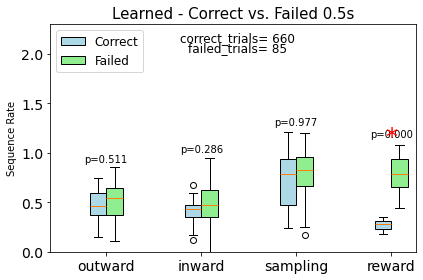

In [19]:
# Plot sequence rate
plot_combined(df_fr, 'learning','Sequence Rate')

df_fr_learning= df_fr[df_fr['Category']=='learning']
trial_cnt_correct ,trial_cnt_failed= count_correct_and_failed_trials(df_fr_learning)

# Plot trial counts for each category
plt.text(3.93, 2.1, 'correct_trials= {}'.format(int(trial_cnt_correct)), ha='center', va='bottom',fontsize=12)
plt.text(3.93,2.0, 'failed_trials= {}'.format(int(trial_cnt_failed)), ha='center', va='bottom',fontsize=12)
plt.show() 

plot_combined(df_fr, 'learned','Sequence Rate')

df_fr_learned= df_fr[df_fr['Category']=='learned']
trial_cnt_correct ,trial_cnt_failed= count_correct_and_failed_trials(df_fr_learned)

# Plot trial counts for each category
plt.text(3.93, 2.1, 'correct_trials= {}'.format(int(trial_cnt_correct)), ha='center', va='bottom',fontsize=12)
plt.text(3.93,2.0, 'failed_trials= {}'.format(int(trial_cnt_failed)), ha='center', va='bottom',fontsize=12)
plt.show() 

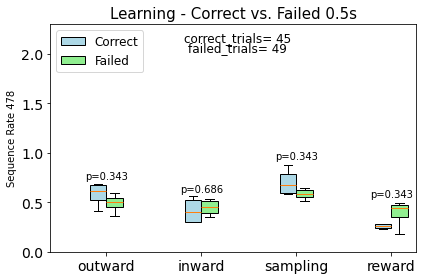

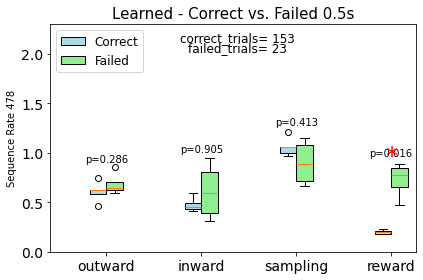

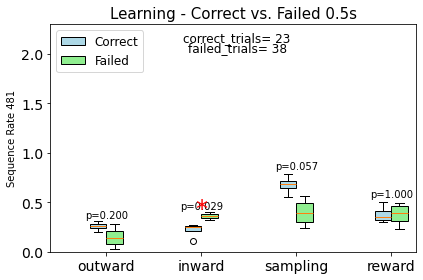

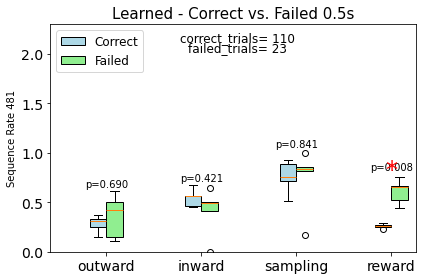

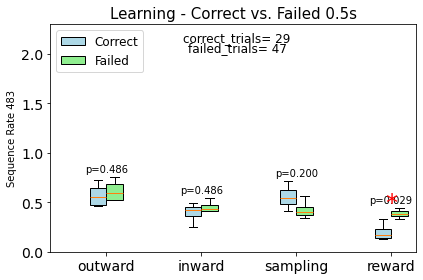

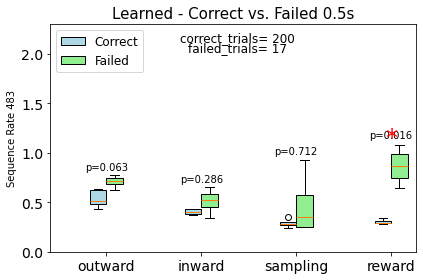

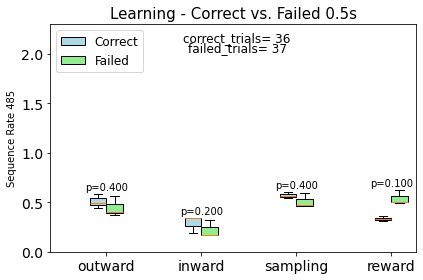

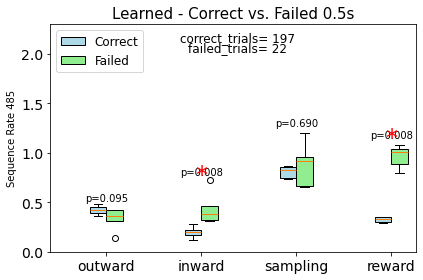

In [20]:
animal_nbr='485'

for animal_nbr in animallist:
    df_anm_fr=df_fr[df_fr['Experiment']==animal_nbr]
    plot_combined(df_anm_fr, 'learning','Sequence Rate '+ animal_nbr)


    df_fr_learning= df_anm_fr[df_anm_fr['Category']=='learning']
    trial_cnt_correct ,trial_cnt_failed= count_correct_and_failed_trials(df_fr_learning)
    # Plot trial counts for each category
    plt.text(3.93, 2.1, 'correct_trials= {}'.format(int(trial_cnt_correct)), ha='center', va='bottom',fontsize=12)
    plt.text(3.93,2, 'failed_trials= {}'.format(int(trial_cnt_failed)), ha='center', va='bottom',fontsize=12)
    plt.savefig(savefolder+ animal_nbr+burst_len+' sequencerate_learning.png', dpi=300, facecolor='w')
    plt.show()





    plot_combined(df_anm_fr, 'learned','Sequence Rate '+ animal_nbr)

    df_fr_learned= df_anm_fr[df_anm_fr['Category']=='learned']
    trial_cnt_correct ,trial_cnt_failed= count_correct_and_failed_trials(df_fr_learned)
    # Plot trial counts for each category
    plt.text(3.93, 2.1, 'correct_trials= {}'.format(int(trial_cnt_correct)), ha='center', va='bottom',fontsize=12)
    plt.text(3.93,2, 'failed_trials= {}'.format(int(trial_cnt_failed)), ha='center', va='bottom',fontsize=12)
    plt.savefig(savefolder+ animal_nbr+burst_len+' sequencerate_learned.png', dpi=300, facecolor='w')
    plt.show()


Learning - Overall Correct vs Failed 0.5s - Mann-Whitney U test p-value: 0.8769515201868247


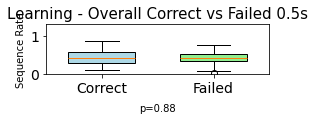

Learned - Overall Correct vs Failed 0.5s - Mann-Whitney U test p-value: 6.952745939590742e-05


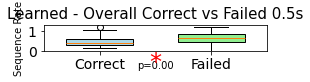

In [21]:
# Splitting the DataFrame into correct and failed results
df_learning_fr = df_fr[df_fr['Category'] == 'learning']
df_learned_fr = df_fr[df_fr['Category'] == 'learned']

# Assuming df_correct and df_failed are already defined
# Analyze and plot for correct results
analyze_and_plot_learning_learned(df_learning_fr, 'Learning - Overall Correct vs Failed '+burst_len,"Sequence Rate")

# Analyze and plot for failed results
analyze_and_plot_learning_learned(df_learned_fr, 'Learned - Overall Correct vs Failed '+burst_len,"Sequence Rate")

In [22]:
def concatenate_data(existing_data, new_data):
    for key in new_data:
        if key in existing_data:
            existing_data[key].append(new_data[key])
        else:
            existing_data[key] = [new_data[key]]
    return existing_data

In [23]:
descriotor

'No_chunk_0.5s_transients'

In [24]:
#Load results from LDA analysis
cumulative_data={'learning':{},'learned':{},'all':{}}
fr_all={}
learningtest=[]
for fol1 in animallist:
    allccrs,cond_results_allsess_loaded=np.load(savefolder+fol1+'pvalues'+'_'+place_cell_name+'_'+cell_types+'_'+descriotor,allow_pickle=True)
    fr_all[fol1]=cond_results_allsess_loaded
    print(len(allccrs.keys()))
    for sesnam in allccrs.keys():
        
        cumulative_data['all'] = concatenate_data(cumulative_data['all'], cond_results_allsess_loaded[sesnam]['fr'])
        if 'learning' in sesnam:
            cumulative_data['learning'] = concatenate_data(cumulative_data['learning'], cond_results_allsess_loaded[sesnam]['fr'])
            learningtest.extend([x for keyname,x in cond_results_allsess_loaded[sesnam]['fr'].items() if 'failed' in keyname])


        if 'learned' in sesnam:
            cumulative_data['learned'] = concatenate_data(cumulative_data['learned'], cond_results_allsess_loaded[sesnam]['fr'])

with open(savefolder+'cumulative_fr'+ '_'+place_cell_name+'_'+cell_types+'_'+descriotor+'.pkl','wb') as f:
    pickle.dump(cumulative_data, f) 
        #if 'learned' in sesnam:

with open(savefolder+'fr_all_new2'+ '_'+place_cell_name+'_'+cell_types+'_'+descriotor+'.pkl','wb') as f:
    pickle.dump(fr_all, f) 

8
9
8
8


In [25]:

# Initialize a dictionary to hold merged fr data, with 'learning' and 'learned' as main keys
merged_fr = {'learning': {}, 'learned': {}}

# Iterate over each animal
for animal in fr_all.keys():
    # Iterate over each session for the animal
    for session in fr_all[animal].keys():
        # Extract the fr data from the session
        fr_data = fr_all[animal][session]['fr']

        # Determine the category of the session ('learning' or 'learned')
        category = 'learning' if 'learning' in session else 'learned'

        # Merge fr data for the respective category
        for epoch, fr_value in fr_data.items():
            if epoch not in merged_fr[category]:
                merged_fr[category][epoch] = []
            merged_fr[category][epoch].append(fr_value)

# The merged_fr dictionary now contains the fr values for each epoch,
# separated into 'learning' and 'learned' categories


In [26]:
# Initialize a new dictionary to hold the merged data for 'failed' and 'correct' epochs separately
merged_fr_separated = {
    'learning': {'failed': [], 'correct': []},
    'learned': {'failed': [], 'correct': []}
}

# Iterate over the 'learning' and 'learned' categories
for category in ['learning', 'learned']:
    # Iterate over each epoch in the category
    for epoch in merged_fr[category]:
        if 'reward' not in epoch:
            # Merge 'failed' epochs
            if 'failed' in epoch:
                merged_fr_separated[category]['failed'].extend(merged_fr[category][epoch])
            # Merge 'correct' epochs
            elif 'correct' in epoch:
                merged_fr_separated[category]['correct'].extend(merged_fr[category][epoch])

# The merged_fr_separated dictionary now contains the merged fr values for 'failed' and 'correct



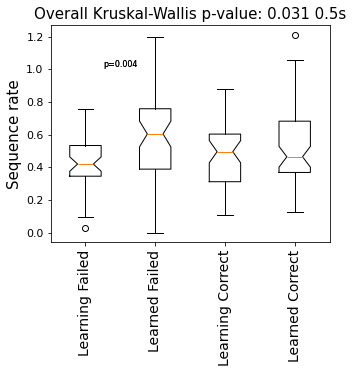

In [27]:

plt.rcParams.update({'font.size': 15})
plt.rcParams['axes.titlesize'] = 15  # Set the title font size
plt.rcParams['xtick.labelsize'] = 14  # You can adjust the font size as needed
plt.rcParams['ytick.labelsize'] = 11  # You can adjust the font size as needed
# Data preparation
data_learning_failed = merged_fr_separated['learning']['failed']
data_learned_failed = merged_fr_separated['learned']['failed']
data_learning_correct = merged_fr_separated['learning']['correct']
data_learned_correct = merged_fr_separated['learned']['correct']

data_to_plot=[data_learning_failed,data_learned_failed,data_learning_correct,data_learned_correct]

# Combine all data into a single list and create a corresponding list of labels
all_data = data_learning_failed + data_learned_failed + data_learning_correct + data_learned_correct
labels = ['Learning Failed'] * len(data_learning_failed) + ['Learned Failed'] * len(data_learned_failed) + \
         ['Learning Correct'] * len(data_learning_correct) + ['Learned Correct'] * len(data_learned_correct)

# Perform the Kruskal-Wallis H-test
_, pval_overall = stats.kruskal(data_learning_failed, data_learned_failed, data_learning_correct, data_learned_correct)

# Perform pairwise Dunn's test
dunn_pvals = sp.posthoc_dunn([data_learning_failed, data_learned_failed, data_learning_correct, data_learned_correct])

# Plotting
fig, ax = plt.subplots(figsize=(5,4))
ax.boxplot([data_learning_failed, data_learned_failed, data_learning_correct, data_learned_correct], labels=['Learning Failed', 'Learned Failed', 'Learning Correct', 'Learned Correct'], notch=True)
plt.xticks(rotation=90)

# Display overall Kruskal-Wallis p-value
ax.set_title(f'Overall Kruskal-Wallis p-value: {pval_overall:.3f} '+burst_len  )
ax.set_ylabel('Sequence rate' )

# Show Dunn's test p-values (you can format this to be more readable)
for i, row in enumerate(dunn_pvals.itertuples(index=False, name=None)):
    for j, p in enumerate(row):
        if p < 0.05:
            y = max(max(data_to_plot[i]), max(data_to_plot[j])) -.2
            ax.text((i+j)/2 + 1, y, f"p={p:.3f}", ha='center', va='bottom', color='k', fontsize=8)

plt.show()


### CCR

In [28]:
allfolders2=['481','483','485','478']
CCRs={'inward':{},'sampling':{},'outward':{}}
PRFs={'inward':{},'sampling':{},'outward':{}}

pval_animasls_cond={}
ccr_animals_cond={'inward':{},'sampling':{},'outward':{}}
prf_animals_cond={'inward':{},'sampling':{},'outward':{}}
for cond in CCRs.keys():
    learning_ccrs=[]
    learned_ccrs=[]

    learning_prfs=[]
    learned_prfs=[]

    pval_animasls={}
    ccr_animal={'481':{},'483':{},'485':{},'478':{}}
    prf_animal={'481':{},'483':{},'485':{},'478':{}}
    for fol1 in allfolders2:
        allccrs,cond_results_allsess_loaded=np.load(savefolder+fol1+'pvalues'+'_'+place_cell_name+'_'+cell_types+'_'+descriotor,allow_pickle=True)
        #for nn in allccrs.keys():
            #print(allccrs[nn]['sampling'])
        #print(fol1)
        an_ccr_ing=[]
        an_ccr_ed=[]

        an_prf_ing=[]
        an_prf_ed=[]

        for sesnam in allccrs.keys():
            if 'learning' in sesnam:
                if np.size(allccrs[sesnam][cond]['mean_ccr'])<1:
                    continue

                learning_ccrs.append(allccrs[sesnam][cond]['mean_ccr'])
                an_ccr_ing.append(allccrs[sesnam][cond]['mean_ccr'])
                learning_prfs.append(allccrs[sesnam][cond].get('performance'))
                an_prf_ing.append(allccrs[sesnam][cond].get('performance'))



            if 'learned' in sesnam:
                if np.size(allccrs[sesnam][cond]['mean_ccr'])<1:
                    continue
                learned_ccrs.append(allccrs[sesnam][cond]['mean_ccr'])
                an_ccr_ed.append(allccrs[sesnam][cond]['mean_ccr'])

                learned_prfs.append(allccrs[sesnam][cond].get('performance'))
                an_prf_ed.append(allccrs[sesnam][cond].get('performance'))

                print(len(learned_prfs),len(an_ccr_ed))


        an_ccr_ing=[x for x in an_ccr_ing if np.size(x)>0 ]
        an_ccr_ed=[x for x in an_ccr_ed if np.size(x)>0 ]

        an_prf_ing=[x for x in an_prf_ing if np.size(x)>0 ]
        an_prf_ed=[x for x in an_prf_ed if np.size(x)>0 ]

        t_stat_an, p_value_an = stats.mannwhitneyu(an_ccr_ing, an_ccr_ed)
        #t_stat_an, p_value_an = stats.wilcoxon(an_ccr_ing, an_ccr_ed)
        ccr_animal[fol1]['learning']=an_ccr_ing
        ccr_animal[fol1]['learned']=an_ccr_ed

        prf_animal[fol1]['learning']=an_prf_ing
        prf_animal[fol1]['learned']=an_prf_ed

        pval_animasls[fol1]=p_value_an
    pval_animasls_cond[cond]=pval_animasls

    prf_animals_cond[cond]=prf_animal# performance of each animal
    ccr_animals_cond[cond]=ccr_animal# ccr of each animal
    
    learning_ccrs=[x for x in learning_ccrs if np.size(x)>0 ]
    learned_ccrs=[x for x in learned_ccrs if np.size(x)>0 ]

    print(cond,len(learned_ccrs))
    print(cond,len(learned_prfs))

    cleaned_array = np.asarray(learned_ccrs)[~np.isnan(np.asarray(learned_ccrs))]
    CCRs[cond]['learning']=learning_ccrs
    CCRs[cond]['learned']=learned_ccrs

    PRFs[cond]['learning']=learning_prfs
    PRFs[cond]['learned']=learned_prfs




with open(savefolder+'CCRs'+ '_'+place_cell_name+'_'+cell_types+'_'+descriotor,'wb') as f:
    pickle.dump(CCRs, f) 

1 1
2 2
3 3
4 4
5 1
6 2
7 3
8 4
9 1
10 2
11 3
12 4
13 5
14 1
15 2
16 3
17 4
inward 17
inward 17
1 1
2 2
3 3
4 1
5 2
6 3
7 1
8 2
9 3
10 1
11 2
12 3
13 4
sampling 13
sampling 13
1 1
2 2
3 3
4 4
5 1
6 2
7 3
8 4
9 1
10 2
11 3
12 4
13 5
14 1
15 2
16 3
17 4
outward 17
outward 17


In [50]:
descriotor

'No_chunk_0.5s_transients'

In [29]:
# Correlation between LDA CCR and Animals' Performance

Corr_con={}

for condition in ccr_animals_cond.keys():
    Corr_animal={}

    for animal in ccr_animals_cond[condition].keys():


        ccr_ac=ccr_animals_cond[condition][animal]['learning'] + ccr_animals_cond[condition][animal]['learned'] 
        prf_ac=prf_animals_cond[condition][animal]['learning'] + prf_animals_cond[condition][animal]['learned'] 

        Corr_animal[animal]=pearsonr(ccr_ac, prf_ac)

    Corr_con[condition]=Corr_animal


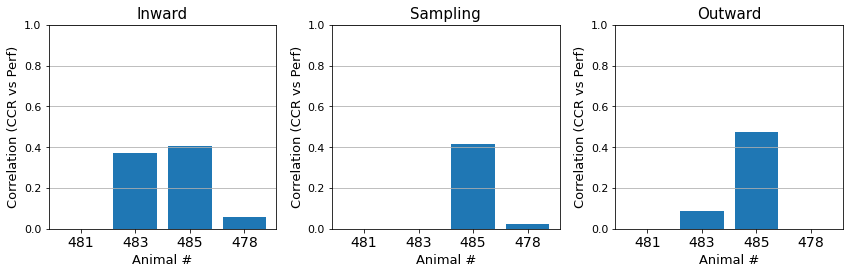

In [44]:
plt.rcParams.update({'font.size': 13})
plt.rcParams['axes.titlesize'] = 15  # Set the title font size
plt.rcParams['xtick.labelsize'] = 14  # You can adjust the font size as needed
plt.rcParams['ytick.labelsize'] = 11  # You can adjust the font size as needed
# Extract correlation values and p-values
correlation_values = {}
p_values = {}
categories = list(Corr_con.keys())
variables = list(Corr_con['inward'].keys())

for category, values in Corr_con.items():
    correlation_values[category] = [value[0] for value in values.values()]
    p_values[category] = [value[1] for value in values.values()]

# Create a subplot with 3 rows and 1 column
fig, axes = plt.subplots(1, 3, figsize=(12, 4), sharex=True)

# Plot each category in a separate subplot
for i, category in enumerate(categories):
    x_values = np.arange(len(variables))
    y_values = correlation_values[category]
    p_values_category = p_values[category]

    # Create a bar plot
    axes[i].bar(x_values, y_values, tick_label=variables)

    # Add stars for significant bars (p < 0.05)
    for x, p in zip(x_values, p_values_category):
        if p < 0.05:
            axes[i].text(x, y_values[x] + 0.05, '*', fontsize=15, ha='center', va='center')

    axes[i].set_title(f'{category.capitalize()}')
    axes[i].set_ylabel('Correlation (CCR vs Perf)')
    axes[i].grid(axis='y')
    axes[i].set_ylim([0,1])
    axes[i].set_xlabel('Animal #')

# Set common x-label
#plt.xlabel('Animal #')
#plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

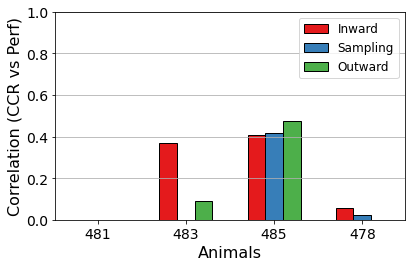

In [53]:
plt.rcParams.update({'font.size': 16})
plt.rcParams['axes.titlesize'] = 15  # Set the title font size
plt.rcParams['xtick.labelsize'] = 14  # You can adjust the font size as needed
plt.rcParams['ytick.labelsize'] = 14  # You can adjust the font size as needed

correlation_values = {}
p_values_corr = {}
categories = list(Corr_con.keys())
variables = list(Corr_con['inward'].keys())

for category, values in Corr_con.items():
    correlation_values[category] = [value[0] for value in values.values()]
    p_values_corr[category] = [value[1] for value in values.values()]

# Create a single plot combining the three categories
x_values = np.arange(len(variables))
fig, ax = plt.subplots(figsize=(6, 4))

for i, category in enumerate(categories):
    y_values = correlation_values[category]
    p_values_category = p_values_corr[category]

    # Create a bar plot with different colors for each category
    colors = ['r', 'g', 'b']
    ax.bar(x_values + i * 0.2, y_values, width=0.2, label=f'{category.capitalize()}',edgecolor='k', color=trend_colors[i])

    # Add stars for significant bars (p < 0.05)
    for x, p in zip(x_values, p_values_category):
        if p < 0.05:
            ax.text(x + i * 0.2, y_values[x] + 0.05, '*', fontsize=12, ha='center', va='center')

#ax.set_title('Correlation')
ax.set_xlabel('Animals')
ax.set_ylabel('Correlation (CCR vs Perf)')
ax.set_xticks(x_values + 0.2)
ax.set_xticklabels(variables)
ax.grid(axis='y')
ax.legend(fontsize=12)
ax.set_ylim([0,1])

plt.tight_layout()
plt.show()

In [54]:
from scipy.stats import wilcoxon
p_values = {}
for key, values in CCRs.items():
    learning_values = values['learning']
    learned_values = values['learned']
    
    # Perform Wilcoxon signed-rank test
    #_, p_val = wilcoxon(learning_values, learned_values, alternative='two-sided')

    _, p_val = mannwhitneyu(learning_values, learned_values, alternative='two-sided')
    p_values[key] = p_val

# Print the computed p-values
for key, p_val in p_values.items():
    print(f"P-value for '{key}' category: {p_val}")

P-value for 'inward' category: 0.1486604457885055
P-value for 'sampling' category: 0.3177632425746528
P-value for 'outward' category: 0.8343712231515731


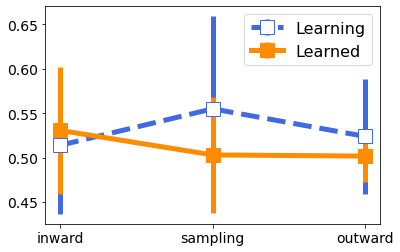

In [55]:


# Assuming CCRs is your data dictionary, replace it with the actual data variable


# Calculating averages and standard deviations of ccrs
averages = {key: {subkey: sum(values) / len(values) for subkey, values in subdata.items()} for key, subdata in CCRs.items()}
stds = {key: {subkey: np.std(values) for subkey, values in subdata.items()} for key, subdata in CCRs.items()}

# Prepare data for plotting
keys = list(averages.keys())
learning_averages = [averages[key]['learning'] for key in keys]
learned_averages = [averages[key]['learned'] for key in keys]
learning_stds = [stds[key]['learning'] for key in keys]
learned_stds = [stds[key]['learned'] for key in keys]

# Plotting
x = np.arange(len(keys))  # Convert range to numpy array for consistency
color_for_learning = 'royalblue'  # A shade of blue
color_for_learned = 'darkorange'  # A shade of orange

plt.errorbar(x, learning_averages, yerr=learning_stds, label='Learning', linewidth=5, marker='s', linestyle='--', color=color_for_learning, markerfacecolor='white', markersize=14)
plt.errorbar(x, learned_averages, yerr=learned_stds, label='Learned', linewidth=5, marker='s', linestyle='-', color=color_for_learned, markersize=14)

# Additional plot formatting
plt.xticks(x, keys)
plt.legend()
plt.show()


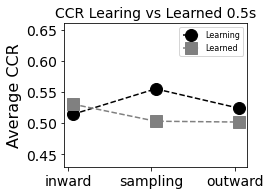

In [56]:
import statistics
# Average values and p-values
averages = {
    'learning': {},
    'learned': {}
}

for key, values in CCRs.items():
    for subkey, subvalues in values.items():
        averages['learning'][key] = sum(CCRs[key]['learning']) / len(CCRs[key]['learning'])
        averages['learned'][key] = sum(CCRs[key]['learned']) / len(CCRs[key]['learned'])


# averages = {key: {subkey: sum(values) / len(values) for subkey, values in subdata.items()} for key, subdata in CCRs.items()}
# stds = {key: {subkey: np.std(values)  for subkey, values in subdata.items()} for key, subdata in CCRs.items()}



# Prepare data for plotting
categories = list(averages['learning'].keys())
# learning_averages = [averages['learning'][category] for category in categories]
# learned_averages = [averages['learned'][category] for category in categories]

learning_averages = [statistics.mean(CCRs[category]['learning']) for category in categories]
learned_averages = [statistics.mean(CCRs[category]['learned']) for category in categories]
learning_stds = [statistics.stdev(CCRs[category]['learning']) for category in categories]
learned_stds = [statistics.stdev(CCRs[category]['learned']) for category in categories]


offset=.05

x = np.arange(len(categories))  # the label locations

# Plotting
plt.figure(figsize=(4, 3))
# plt.plot(x, learning_averages, label='Learning', marker='o')
# plt.plot(x, learned_averages, label='Learned', marker='s')

plt.errorbar(x + offset, learning_averages, label='Learning', fmt='o', linestyle='dashed', markersize=12, color='black', ecolor='black', elinewidth=2, capsize=5, capthick=2)
plt.errorbar(x + offset, learned_averages, label='Learned', fmt='s',linestyle='dashed',markersize=12, color='grey', ecolor='black', elinewidth=2, capsize=5, capthick=2)




# Adding stars for significant p-values
for i, category in enumerate(categories):
    if p_values[category] < 0.05:
        y = max(learning_averages[i], learned_averages[i]) + 0.01
        plt.text(i, y, "*", ha='center', va='bottom', color='k', fontsize=14)

# Add some text for labels, title and custom x-axis tick labels, etc.
#plt.xlabel('Condition')
plt.ylabel('Average CCR')
plt.title('CCR Learing vs Learned '+burst_len, fontsize=14)
plt.xticks(x, categories)
plt.legend(fontsize=8)
plt.ylim([.43,.66])
plt.tight_layout()
plt.show()


inward 0.1486604457885055
sampling 0.3177632425746528
outward 0.8343712231515731


[]

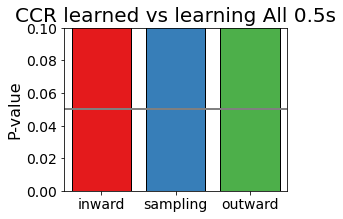

In [44]:
plt.rcParams.update({'font.size': 18})
plt.rcParams['axes.titlesize'] = 10  # Set the title font size
plt.rcParams['xtick.labelsize'] = 14  # You can adjust the font size as needed
plt.rcParams['ytick.labelsize'] = 14  # You can adjust the font size as needed
plt.figure(figsize=(4,3))
colors=['r','b','g']
ccr_means={'learning':{},'learned':{}}
pvals_cnds_allccr={}

for ic,cond in enumerate(CCRs.keys()):
    #_, p_value = stats.wilcoxon(learning, learned)
    t_stat, p_value = stats.mannwhitneyu(CCRs[cond]['learning'], CCRs[cond]['learned'])
    print(cond, p_value)
   

    ccr_means['learning'][cond]= np.mean(CCRs[cond]['learning'])
    ccr_means['learned'][cond]= np.mean(CCRs[cond]['learned'])

    pvals_cnds_allccr[cond]=p_value


    plt.bar(cond, p_value,color=trend_colors[ic], edgecolor='black')
    plt.ylabel('P-value',fontsize=16)
    plt.hlines(.05,-.5,3,color='grey')
    plt.xlim([-.5,2.5])
    plt.title('CCR learned vs learning '+ cell_types+' '+burst_len,fontsize=20)
    plt.ylim(0, .1)  # Set the y-axis limits from 0 to 1
    # plt.axhline(0.05, color='red', linestyle='--', label='Significance Threshold (alpha=0.05)')
    #plt.legend()
    # plt.show()

plt.plot()



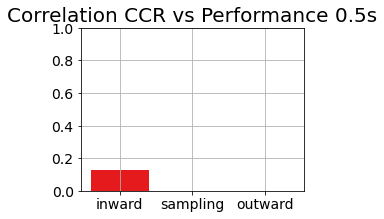

In [45]:
plt.rcParams.update({'font.size': 18})
plt.rcParams['axes.titlesize'] = 15  # Set the title font size
plt.rcParams['xtick.labelsize'] = 14  # You can adjust the font size as needed
plt.rcParams['ytick.labelsize'] = 14  # You can adjust the font size as needed
# Data for averages and p-values
Correlation_all={}
for conname in CCRs.keys():

    ccrs= CCRs[conname]['learning'] +CCRs[conname]['learned']
    prfs= PRFs[conname]['learning'] +PRFs[conname]['learned']
       
    Correlation_all[conname]=pearsonr(prfs, ccrs)

#ax_inset = plt.axes([.80, 0.39, 0.2, 0.2])  # [left, bottom, width, height]


fig,ax_inset=plt.subplots(1,1,figsize=(4,3))
for icnd,cond in enumerate(Correlation_all.keys()):
    Correlation_all[cond]
    ax_inset.bar(cond, Correlation_all[cond][0],  color=trend_colors[icnd])
    if Correlation_all[cond][1]<.05:
        ax_inset.text(icnd, Correlation_all[cond][0], '*',fontsize=22)

ax_inset.set_title('Correlation CCR vs Performance '+burst_len,fontsize=20)
ax_inset.set_ylim([0,1])
plt.grid()

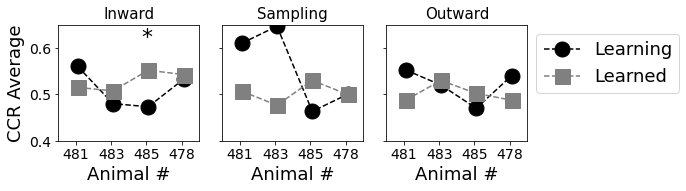

In [46]:

plt.rcParams.update({'font.size': 18})
plt.rcParams['axes.titlesize'] = 15  # Set the title font size
plt.rcParams['xtick.labelsize'] = 14  # You can adjust the font size as needed
plt.rcParams['ytick.labelsize'] = 14  # You can adjust the font size as needed

# Function to calculate averages
def calculate_averages(data):
    return {animal: {condition: np.mean(values) for condition, values in conditions.items()} for animal, conditions in data.items()}

# Calculate averages for each condition and animal
averages = {condition: calculate_averages(ccr_animals_cond[condition]) for condition in ccr_animals_cond}

# Plotting
conditions = list(averages.keys())
animals = list(averages[conditions[0]].keys())
x = np.arange(len(animals))  # the label locations
offset = 0.05  # offset for plotting multiple lines

fig, axes = plt.subplots(1, len(conditions), figsize=(10, 3), sharey=True)

for i, ax in enumerate(axes):
    condition = conditions[i]
    learning_averages = [averages[condition][animal]['learning'] for animal in animals]
    learned_averages = [averages[condition][animal]['learned'] for animal in animals]

    # Plot learning and learned averages for each condition
    ax.errorbar(x + offset, learning_averages, label='Learning', fmt='o', linestyle='dashed', markersize=15, color='black', ecolor='black', elinewidth=2, capsize=5, capthick=2)
    ax.errorbar(x + offset, learned_averages, label='Learned', fmt='s',linestyle='dashed',markersize=15, color='grey', ecolor='black', elinewidth=2, capsize=5, capthick=2)

    # Add stars for significant p-values
    for j, animal in enumerate(animals):
        if pval_animasls_cond[condition][animal] < .05:  # Correctly access p-values
            y = .6#max(learning_averages[j], learned_averages[j]) + 0.02
            ax.text(j, y, "*", ha='center', va='bottom', color='k', fontsize=22)

    ax.set_title(condition.capitalize())
    ax.set_xticks(x)
    ax.set_xticklabels(animals)
    ax.set_xlabel('Animal #')
    ax.set_xlim([-.5,3.5])
    ax.set_ylim([.4,.65])

    if i == 0:
        ax.set_ylabel('CCR Average')

plt.legend(bbox_to_anchor=[1,1])
plt.tight_layout()
plt.show()


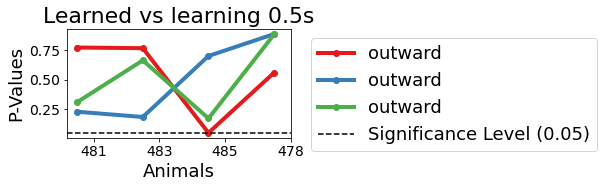

In [47]:
# Extracting data for plotting
conditions = list(pval_animasls_cond.keys())
animals = list(pval_animasls_cond['inward'].keys())

# Create a grouped bar graph
bar_width = 0.25
index = np.arange(len(animals))

fig, ax = plt.subplots(figsize=(4, 2))
#plt.figure(figsize=(4, 2))


for i, condition in enumerate(conditions):
    p_values = [pval_animasls_cond[condition][animal] for animal in animals]
    bar_position = index + i * bar_width

    ccr_means
    #ax.bar(bar_position, p_values, bar_width, label=condition,color=trend_colors[i])
    #ax.plot(animals, p_values,  label=condition,color=trend_colors[i],linewidth=4)
    ax.plot(animals, p_values, marker='o', linestyle='-',color=trend_colors[i], label=category,linewidth=4)

# Add a horizontal dashed line at y = 0.05
ax.axhline(y=0.05, color='black', linestyle='--', label='Significance Level (0.05)')

ax.set_xlabel('Animals')
ax.set_ylabel('P-Values')
ax.set_title('Learned vs learning '+burst_len,fontsize=22)
ax.set_xticks(index + bar_width)
ax.set_xticklabels(animals)
ax.legend()
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
# Show the plot
plt.show()


In [ ]:
colors

['r', 'b', 'g']

In [ ]:
# Load entropy of original data without subsampling (Not recommended! use subsampling data)

# allfolders2=['481','483','485','478']
# all_entropies={}
# for fol1 in allfolders2:
#     all_entropies[fol1]=np.load(savefolder+fol1+'Entropy_'+place_cell_name+' '+cell_types+descriotor,allow_pickle=True)

## Entropy

In [6]:
def diversiyt_index_subsampling(temp_info_subsampling):

        
    cond_numbers={}
    cond_numbers['outward']=[2,3] # conditon name (outwards)
    cond_numbers['inward']=[6,7] # inwards
    cond_numbers['sampling']=[0,1] # sampling
    cond_numbers['reward'] =[4,5] # reward
    subsampling_restults={'cluster_dist':{}}

    Entropy_subsamplings={}
    SS_info={}
    for ss in range(len(temp_info_subsampling)):# subsampling for entropy

        entropy={'correct':{},'failed':{}}
        subsampling_info={'correct':{},'failed':{}}
        for trial_type in range(2):
            fr_trial={}
            
            #sessin_numbers=np.arange(len(session_mask))


            if trial_type==1:
                typename='correct'
            elif trial_type==0:
                typename='failed'


            for phase_name in range(2):
                if phase_name==1:
                    phname='learned'
                elif phase_name==0:
                    phname='learning'



    # temp_info_subsampling[1]['new_cond_mask']=new_cond_mask
    # temp_info_subsampling[1]['new_phase_mask']=new_phase_mask
    # temp_info_subsampling[1]['new_correct_failed_mask']=new_correct_failed_mask

                for cond_number_name in cond_numbers.keys():
                    ampling_mask_cond=np.zeros_like(temp_info_subsampling[ss]['new_cond_mask'])
                    for ii in cond_numbers[cond_number_name]:
                        ampling_mask_cond+=temp_info_subsampling[ss]['new_cond_mask']==ii# task epochs: samplng, reward, ...
                    l_mask=temp_info_subsampling[ss]['new_phase_mask']==phase_name# learning or learned sequences
                    c_mask=temp_info_subsampling[ss]['new_correct_failed_mask']==trial_type# correct or fialed sequences

                    final_mask=((c_mask) & (l_mask) & (ampling_mask_cond.astype(bool)) )
                    labels, counts = np.unique(temp_info_subsampling[ss]['ids_clust'][0][final_mask], return_counts=True)
                    


                    subsampling_restults['cluster_dist'][phname+'_'+cond_number_name] = {'seq_len':len(temp_info_subsampling[ss]['ids_clust'][0][final_mask]),
                                                                                'cluster_number': labels, 'clsuster_counts':counts}
            subsampling_info[typename]=subsampling_restults
            # compute diversity index for different qs
            Div_idxq={}

            for epochs in subsampling_restults['cluster_dist'].keys():
                clstr_data=subsampling_restults['cluster_dist'][epochs]
                diq=[]
                xq=np.arange(0.011,5.51,.1)
                xq[0]=0
                for q in (xq):
                    
                    diq.append( mot.calculate_diversity_q(clstr_data,q))
                
                #Div_idxq[epochs]=diq
                Div_idxq[epochs]=mot.calculate_shannon_entropy(clstr_data)
                entropy[typename][epochs]=Div_idxq[epochs]
        Entropy_subsamplings[ss]=entropy# entropy fo all saubsamplings
        SS_info[ss]=subsampling_info
    return Entropy_subsamplings,SS_info

In [7]:
# Function to merge all values of the provided data for any number of repetitions
def merge_all_values(data):
    merged = {}
    
    # Initialize merged dictionary
    for category in ['correct', 'failed']:
        merged[category] = {key: [] for key in data[0][category]}
    
    # Merge values
    for i in data.values():
        for category in ['correct', 'failed']:
            for key, value in i[category].items():
                merged[category][key].append(value)
            
    return merged

In [8]:
def calculate_average_dynamic(data):
    average = {}
    num_entries = len(data)
    
    # Initialize average dictionary
    for category in ['correct', 'failed']:
        average[category] = {key: 0 for key in data[0][category]}
    
    # Sum up all values
    for i in range(num_entries):
        for category in ['correct', 'failed']:
            for key in data[i][category]:
                average[category][key] += data[i][category][key]
    
    # Calculate average
    for category in ['correct', 'failed']:
        for key in average[category]:
            average[category][key] /= num_entries
            
    return average

In [50]:
df_plot2=df_plot

In [97]:
animallist

['478', '481', '483', '485']

In [ ]:
animallist

In [ ]:
Entropy_subsampling_modified

In [53]:
# Load entropy of subsampling 

all_entropies_ss={}


for fol1 in ['478', '481', '483','485']:

    temp_info_subsampling=np.load(savefolder+fol1+'Entropy_subsampling_modified'+ '_'+place_cell_name+'_'+cell_types+'_'+descriotor+'.pkl',allow_pickle=True)
    entropy_ss,SS_info= diversiyt_index_subsampling(temp_info_subsampling)
    print((len(temp_info_subsampling)))
    entropy_ss_avg= calculate_average_dynamic(entropy_ss)
    merged_ss_mrg = merge_all_values(entropy_ss)


    all_entropies_ss[fol1]=merged_ss_mrg
all_entropies=all_entropies_ss

50
50
50
50


In [55]:
len(temp_info_subsampling)

50

In [10]:

# Prepare the data from all_entropies
plot_data = []
for exp_id, categories in all_entropies.items():
    for result_type in ['correct', 'failed']:
        for learning_type in ['learning', 'learned']:
            for metric in ['outward', 'inward', 'sampling', 'reward']:
                key = f'{learning_type}_{metric}'
                if key in categories[result_type]:
                    value = categories[result_type][key]
                    plot_data.append({'Experiment': exp_id, 'Category': learning_type, 'Metric': metric, 'Value': value, 'ResultType': result_type})

# Creating DataFrame from all_entropies data
df_plot = pd.DataFrame(plot_data)

# # Function to plot the data
# def plot_data(df, title):
#     fig, ax = plt.subplots(figsize=(12, 8))
#     metrics = df['Metric'].unique()
#     categories = df['Category'].unique()

#     for metric in metrics:
#         for category in categories:
#             subset = df[(df['Metric'] == metric) & (df['Category'] == category)]
#             values = subset['Value'].tolist()

#             if values:
#                 pos_offset = len(categories) * list(metrics).index(metric) + list(categories).index(category)
#                 ax.boxplot(values, positions=[pos_offset], widths=0.6, labels=[f'{metric}\n{category}'])

#     ax.set_xticks(range(len(metrics) * len(categories)))
#     ax.set_xticklabels([f'{metric}\n{category}' for metric in metrics for category in categories], rotation=45, ha="right")

#     plt.title(title)
#     plt.xlabel('Metric and Category')
#     plt.ylabel('Value')
#     plt.tight_layout()
#     plt.show()

# # Splitting the DataFrame into correct and failed results
# df_correct = df_plot[df_plot['ResultType'] == 'correct']
# df_failed = df_plot[df_plot['ResultType'] == 'failed']

# # Plotting the data for 'correct' results
# plot_data(df_correct, 'Learning and Learned Metrics Comparison - Correct Results')

# # Plotting the data for 'failed' results
# plot_data(df_failed, 'Learning and Learned Metrics Comparison - Failed Results')

In [ ]:


# # Assuming 'df_plot' is your DataFrame prepared as before
# # Function to plot the data with learning and learned pairs next to each other
# def plot_grouped_data(df, title):
#     plt.figure(figsize=(12, 8))
#     metrics = df['Metric'].unique()
#     categories = ['learning', 'learned']  # Fixed order for categories
#     num_metrics = len(metrics)
#     width = 0.35  # Width of the box plots

#     # Create an array of positions for the metrics
#     positions = np.arange(num_metrics)
    
#     for i, metric in enumerate(metrics):
#         for j, category in enumerate(categories):
#             subset = df[(df['Metric'] == metric) & (df['Category'] == category)]
#             values = subset['Value'].tolist()
#             if values:
#                 # Calculate positions for 'learning' and 'learned' to be next to each other
#                 pos = [x + (j - 0.5) * width for x in [i]]
#                 plt.boxplot(values, positions=pos, widths=width, patch_artist=True, boxprops=dict(facecolor=f'C{j}'), labels=[f'{metric}\n{category}'] if j == 1 else None)

#     # Set the x-ticks to be in the middle of each pair
#     plt.xticks(positions, metrics)
#     plt.title(title)
#     plt.xlabel('Metric')
#     plt.ylabel('Value')
#     plt.legend(['Learning', 'Learned'], loc='upper right')
#     plt.tight_layout()
#     plt.show()

# # Splitting the DataFrame into correct and failed results
# df_correct = df_plot[df_plot['ResultType'] == 'correct']
# df_failed = df_plot[df_plot['ResultType'] == 'failed']

# # Plotting the data for 'correct' results with learning and learned pairs
# plot_grouped_data(df_correct, 'Correct Results - Learning and Learned Metrics Comparison')

# # Plotting the data for 'failed' results with learning and learned pairs
# plot_grouped_data(df_failed, 'Failed Results - Learning and Learned Metrics Comparison')


In [ ]:


# # Assuming 'df_plot' is your DataFrame prepared as before
# # Function to plot the data with learning and learned pairs next to each other and perform t-tests
# def plot_grouped_data_with_stats(df, title):
#     plt.figure(figsize=(4, 3))
#     metrics = df['Metric'].unique()
#     categories = ['learning', 'learned']  # Fixed order for categories
#     num_metrics = len(metrics)
#     width = 0.35  # Width of the box plots

#     # Iterate over each metric to plot and perform t-tests
#     for i, metric in enumerate(metrics):
#         positions = []
#         values_list = []
        
#         for j, category in enumerate(categories):
#             subset = df[(df['Metric'] == metric) & (df['Category'] == category)]
#             values = subset['Value'].tolist()
#             values_list.append(values)
#             if values:
#                 pos = i + (j - 0.5) * width
#                 positions.append(pos)
#                 plt.boxplot(values, positions=[pos], widths=width, patch_artist=True, boxprops=dict(facecolor=f'C{j}'), labels=[f'{metric}\n{category}'] if j == 1 else None)
        
#         # Perform t-test and annotate if significant
#         if all(values_list):  # Ensure both groups have data
#             stat, p_value = stats.mannwhitneyu(values_list[0], values_list[1])
#             if p_value < 0.05:
#                 # Annotate with a star above the pair
#                 highest = max(max(values_list[0]), max(values_list[1]))
#                 plt.text(np.mean(positions), highest, '*', ha='center', va='bottom', fontsize=24,color='r')

#     plt.xticks(np.arange(num_metrics), metrics)
#     plt.title(title)
#     plt.xlabel('Metric')
#     plt.ylabel('Value')
#     plt.legend(['Learning', 'Learned'], loc='upper right')
#     plt.tight_layout()
#     plt.show()

# # Splitting the DataFrame into correct and failed results
# df_correct = df_plot[df_plot['ResultType'] == 'correct']
# df_failed = df_plot[df_plot['ResultType'] == 'failed']

# # Plotting the data for 'correct' results with statistical tests
# plot_grouped_data_with_stats(df_correct, 'Correct Results - Learning and Learned Metrics Comparison')

# # Plotting the data for 'failed' results with statistical tests
# plot_grouped_data_with_stats(df_failed, 'Failed Results - Learning and Learned Metrics Comparison')


0.6004677449221749
3.4695867490505678e-06
0.016796139078100344
0.381162309212424


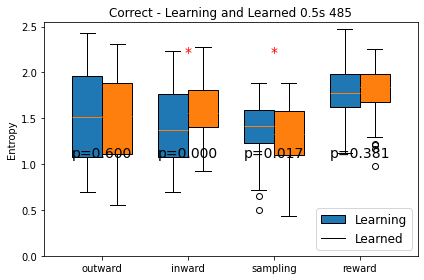

0.10146733958661494
0.005879656447549185
0.0025717614457908783
0.2396376908766641


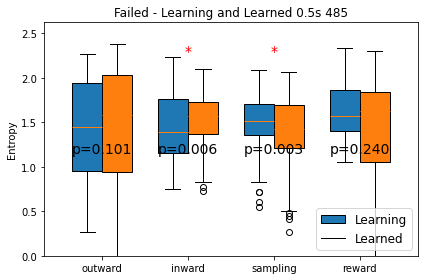

In [11]:

def plot_grouped_data_with_nonparametric_stats(df, title):
    plt.figure(figsize=(6, 4))
    metrics = df['Metric'].unique()
    categories = ['learning', 'learned']
    num_metrics = len(metrics)
    width = 0.35  # Adjust width for clarity if needed

    # Adjust the y-axis limit dynamically
    all_values = df['Value'].values
    ylim_upper = np.max(np.max(all_values)) * 1.1  # Increase the upper limit by 10% for annotation space

    for i, metric in enumerate(metrics):
        for j, category in enumerate(categories):
            subset = df[(df['Metric'] == metric) & (df['Category'] == category)]
            values = subset['Value'].tolist()
            values=[xx for x in values for xx in x]
            pos = i + (j - 0.5) * width
            plt.boxplot(values, positions=[pos], widths=width, patch_artist=True,
                        boxprops=dict(facecolor=f'C{j}'), labels=[f'{metric}\n{category}'] if j == 1 else None)

            if len(values) > 0:  # Check to ensure there are values to avoid plotting errors
                # Find the highest point for potentially placing the star
                high_point = max(values)

        # Perform the Mann-Whitney U test between learning and learned for each metric
        learning_values = df[(df['Metric'] == metric) & (df['Category'] == 'learning')]['Value'].tolist()
        learned_values = df[(df['Metric'] == metric) & (df['Category'] == 'learned')]['Value'].tolist()

        learning_values=[xx for x in learning_values for xx in x]# flatten data of all animals
        learned_values=[xx for x in learned_values for xx in x]# flatten data of all animals

        
        if learning_values and learned_values:  # Ensure both categories have data
            stat, p_value = mannwhitneyu(learning_values, learned_values, alternative='two-sided')
            plt.text(i, ylim_upper-1.5, f'p={p_value:.3f}', ha='center', va='bottom', fontsize=14, color='k')

            print(p_value)
            if p_value < 0.05:
                star_pos = i  # Position the star in the middle of the pair
                # Use the updated ylim_upper for positioning the star
                plt.text(star_pos, ylim_upper-.4, '*', ha='center', va='bottom', fontsize=14, color='red')

    plt.legend(['Learning', 'Learned'], loc='lower right',fontsize=12)
    plt.xticks(np.arange(num_metrics), metrics)
    plt.ylim(0, ylim_upper)  # Set the y-axis limit to include space for the star
    plt.title(title)
    #plt.xlabel('Metric')
    plt.ylabel('Entropy')
    #plt.ylim([0,15])
    plt.tight_layout()
    plt.show()

# Splitting the DataFrame into correct and failed results
df_correct = df_plot[df_plot['ResultType'] == 'correct']
df_failed = df_plot[df_plot['ResultType'] == 'failed']
# Plotting the data for 'correct' and 'failed' results with Mann-Whitney U tests

# animal_nbr='485'
# df_correct_anm=df_correct[df_correct['Experiment']==animal_nbr]
# df_failed_anm=df_failed[df_failed['Experiment']==animal_nbr]
# plot_grouped_data_with_nonparametric_stats(df_correct_anm, 'Correct - Learning and Learned '+burst_len+ ' '+animal_nbr)
# plot_grouped_data_with_nonparametric_stats(df_failed_anm, 'Failed - Learning and Learned '+burst_len+ ' '+animal_nbr)


plot_grouped_data_with_nonparametric_stats(df_correct, 'Correct - Learning and Learned '+burst_len+' '+fol1 )
plot_grouped_data_with_nonparametric_stats(df_failed, 'Failed - Learning and Learned '+burst_len+' '+fol1)


In [12]:


# Assuming df_correct and df_failed are already defined
# Analyze and plot for correct results
analyze_and_plot(df_correct, 'Correct - Overall Learning vs Learned '+burst_len,'Entropy')

# Analyze and plot for failed results
analyze_and_plot(df_failed, 'Failed - Overall Learning vs Learned '+burst_len,'Entropy')


NameError: name 'analyze_and_plot' is not defined

TypeError: unsupported operand type(s) for -: 'list' and 'list'

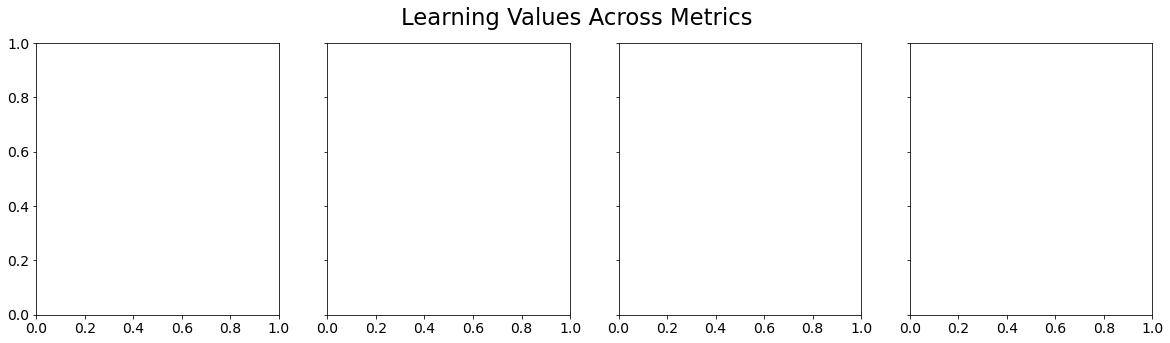

In [54]:


# Define metrics and categories
metrics = ['outward', 'inward', 'sampling', 'reward']
categories = ['learning', 'learned']

def plot_and_test(df):
    for category in categories:
        # Prepare plot
        fig, axs = plt.subplots(1, len(metrics), figsize=(20, 5), sharey=True)
        fig.suptitle(f'{category.capitalize()} Values Across Metrics')

        for i, metric in enumerate(metrics):
            # Extract values for the current metric and category
            correct_values = df[(df['Category'] == category) & (df['Metric'].str.contains(metric)) & (df['ResultType'] == 'correct')]['Value']
            failed_values = df[(df['Category'] == category) & (df['Metric'].str.contains(metric)) & (df['ResultType'] == 'failed')]['Value']
            
            # Prepare data for box plot
            data = [correct_values.dropna(), failed_values.dropna()]
            
            # Box plot
            axs[i].boxplot(data, patch_artist=True)
            axs[i].set_title(metric)
            axs[i].set_xticklabels(['Correct', 'Failed'])
            
            # Mann-Whitney U test
            if len(correct_values) > 0 and len(failed_values) > 0:
                stat, p_value = mannwhitneyu(correct_values, failed_values, alternative='two-sided')
                # Annotate significant differences
                if p_value < 0.05:
                    axs[i].text(1.5, max(np.concatenate(data)), '*', ha='center', va='bottom', fontsize=14, color='red')
                axs[i].set_xlabel(f'p={p_value:.3f}')

        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()

# Assuming df_plot is your DataFrame
plot_and_test(df_plot)


In [36]:


# Assuming df_plot is your DataFrame
plot_combined(df_plot, 'learning','Entropy')
plot_combined(df_plot, 'learned','Entropy')


NameError: name 'plot_combined' is not defined

In [14]:


# Splitting the DataFrame into correct and failed results
df_learning = df_plot[df_plot['Category'] == 'learning']
df_learned = df_plot[df_plot['Category'] == 'learned']

# Assuming df_correct and df_failed are already defined
# Analyze and plot for correct results
analyze_and_plot_learning_learned(df_learning, 'Learning - Overall Correct vs Failed '+burst_len,"Entropy")

# Analyze and plot for failed results
analyze_and_plot_learning_learned(df_learned, 'Learned - Overall Correct vs Failed '+burst_len,"Entropy")

NameError: name 'analyze_and_plot_learning_learned' is not defined

0.6004677449221749
3.4695867490505678e-06
0.016796139078100344
0.381162309212424


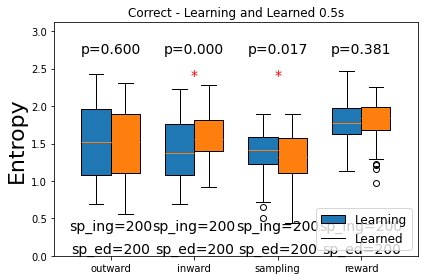

0.10146733958661494
0.005879656447549185
0.0025717614457908783
0.2396376908766641


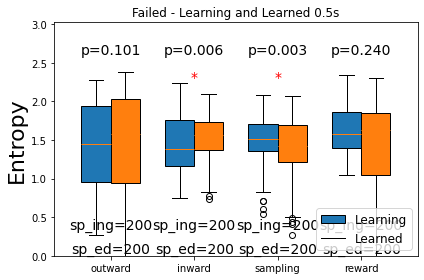

In [15]:
def plot_grouped_data_with_nonparametric_stats_ss(df, title):
    plt.figure(figsize=(6, 4))
    metrics = df['Metric'].unique()
    categories = ['learning', 'learned']
    num_metrics = len(metrics)
    width = 0.35  # Adjust width for clarity if needed

    # Adjust the y-axis limit dynamically
    all_values = df['Value'].values
    all_values = [item for sublist in all_values for item in sublist]

    ylim_upper = np.max(all_values) * 1.1  # Increase the upper limit by 10% for annotation space

    for i, metric in enumerate(metrics):
        for j, category in enumerate(categories):
            subset = df[(df['Metric'] == metric) & (df['Category'] == category)]
            values = subset['Value'].tolist()
            values = [item for sublist in values for item in sublist]

            
            pos = i + (j - 0.5) * width
            plt.boxplot(values, positions=[pos], widths=width, patch_artist=True,
                        boxprops=dict(facecolor=f'C{j}'), labels=[f'{metric}\n{category}'] if j == 1 else None)

            if len(values) > 0:  # Check to ensure there are values to avoid plotting errors
                # Find the highest point for potentially placing the star
                high_point = max(values)

        # Perform the Mann-Whitney U test between learning and learned for each metric
        learning_values = df[(df['Metric'] == metric) & (df['Category'] == 'learning')]['Value'].tolist()
        learned_values = df[(df['Metric'] == metric) & (df['Category'] == 'learned')]['Value'].tolist()
        # learned_values= [np.mean(x) for x in learned_values]
        # learning_values= [np.mean(x) for x in learning_values]

        learning_values = [item for sublist in learning_values for item in sublist]
        learned_values = [item for sublist in learned_values for item in sublist]

        if learning_values and learned_values:  # Ensure both categories have data
            stat, p_value = mannwhitneyu(learning_values, learned_values, alternative='two-sided')
            plt.text(i, ylim_upper-.05, f'p={p_value:.3f}', ha='center', va='bottom', fontsize=14, color='k')
            plt.text(i, ylim_upper-ylim_upper, f'sp_ed={len(learned_values):.0f}', ha='center', va='bottom', fontsize=14, color='k')
            plt.text(i, ylim_upper-ylim_upper+.3, f'sp_ing={len(learning_values):.0f}', ha='center', va='bottom', fontsize=14, color='k')




            print(p_value)
            if p_value < 0.05:
                star_pos = i  # Position the star in the middle of the pair
                # Use the updated ylim_upper for positioning the star
                plt.text(star_pos, ylim_upper-.4, '*', ha='center', va='bottom', fontsize=14, color='red')



    plt.legend(['Learning', 'Learned'], loc='lower right',fontsize=12)
    plt.xticks(np.arange(num_metrics), metrics)
    plt.ylim(0, ylim_upper+.04)  # Set the y-axis limit to include space for the star
    plt.title(title)
    #plt.xlabel('Metric')
    plt.ylabel('Entropy',fontsize=22)
    plt.ylim([0,ylim_upper+.4])
    plt.tight_layout()
    plt.show()
df_correct = df_plot[df_plot['ResultType'] == 'correct']
df_failed = df_plot[df_plot['ResultType'] == 'failed']
    
plot_grouped_data_with_nonparametric_stats_ss(df_correct, 'Correct - Learning and Learned '+burst_len)
plot_grouped_data_with_nonparametric_stats_ss(df_failed, 'Failed - Learning and Learned '+burst_len)


In [39]:
#sessinfo_and_mask=np.load(savefolder+fol1+'Sesseion_info_ Allall_days_original_bursts_neworder0.2s_transients',allow_pickle=True) 

#sessinfo_and_mask=np.load(savefolder+fol1+'outward_R_all_correct_No_chunk_0.2s_transients_Alltest_neworder',allow_pickle=True) for place cell analysis

sessinfo_and_mask=np.load(savefolder+fol1+'Sesseion_info_All AllNo_chunk_0.5s_transients',allow_pickle=True)



In [40]:
saved_idx=np.load(savefolder+fol1+'outward_'+dir_of_run+'_all_correct_No_chunk_0.5s_transients_Alltest_neworder0.5s_burst_sig_fraction_1nAlltest_neworder',allow_pickle=True)


NameError: name 'dir_of_run' is not defined

In [41]:
fol1='481'

In [42]:
# Load place cell indices
dir_of_run='L'
#saved_idx=np.load(savefolder+fol1+'outward_'+dir_of_run+'_all_correct_all_days_original_bursts_200ms_transients_Allnew2200ms_burst_sig_fraction',allow_pickle=True)
saved_idx=np.load(savefolder+fol1+'outward_'+dir_of_run+'_all_correct_No_chunk_0.5s_transients_Alltest_neworder0.5s_burst_sig_fraction_1nAlltest_neworder',allow_pickle=True)

sig_pc_L=saved_idx['sig_PC']

dir_of_run='R'
#saved_idx=np.load(savefolder+fol1+'outward_'+dir_of_run+'_all_correct_all_days_original_bursts_200ms_transients_Allnew2200ms_burst_sig_fraction',allow_pickle=True)

saved_idx=np.load(savefolder+fol1+'outward_'+dir_of_run+'_all_correct_No_chunk_0.5s_transients_Alltest_neworder0.5s_burst_sig_fraction_1nAlltest_neworder',allow_pickle=True)

sig_pc_R=saved_idx['sig_PC']

significant_pc=sig_pc_L|sig_pc_R

if place_cells:
    #place_cell_name=sigfilename_r[52:60]
    #cell_types='non_pc'

    if cell_types=='Non_PC':
        significant_pc=~significant_pc
elif place_cells==False:
        cell_types='All'

In [43]:
conds=['sampling_L',
 'sampling_R',
 'outward_L',
 'outward_R',
 'reward_L',
 'reward_R',
 'inward_L',
 'inward_R']


cond_number = dict(zip(conds, np.arange(len(conds))))# make mask values for each task
cond_names=cond_number


In [44]:

color_cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']

# Get the first four colors
first_four_colors = color_cycle[:4]


In [45]:
cond_names

{'sampling_L': 0,
 'sampling_R': 1,
 'outward_L': 2,
 'outward_R': 3,
 'reward_L': 4,
 'reward_R': 5,
 'inward_L': 6,
 'inward_R': 7}

c:\Users\hamed\Desktop\Hamed\Github\TP7\code\mtools.py:3835: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  cond_seqs[tsk]=np.asarray(sess_info['seqs'])[mskcnd & correct_mask & ph_mask]


boz sampling outward
boz sampling reward
boz sampling inward
boz outward reward
boz outward inward
boz reward inward
boz sampling outward
boz sampling reward
boz outward reward
boz outward inward
boz reward inward
boz reward inward


c:\Users\hamed\anaconda3\lib\site-packages\seaborn\categorical.py:3399: UserWarning: 23.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


boz sampling outward
boz sampling reward
boz outward reward
boz outward inward
boz reward inward


c:\Users\hamed\anaconda3\lib\site-packages\seaborn\categorical.py:3399: UserWarning: 10.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
c:\Users\hamed\anaconda3\lib\site-packages\seaborn\categorical.py:3399: UserWarning: 31.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


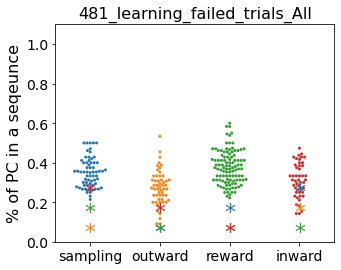

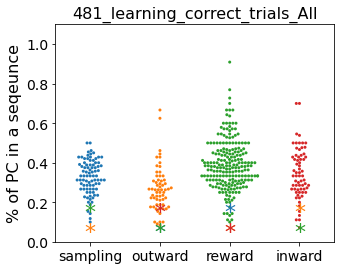

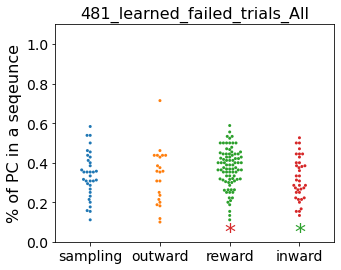

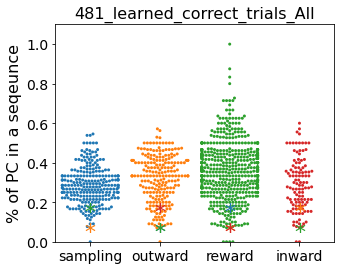

In [46]:


sig_pc_idx=np.where(significant_pc)
pc_frac=mot.pc_faction_in_sequnce(sessinfo_and_mask['Masks'],sessinfo_and_mask['sess_info'],sig_pc_idx,cond_names)

plt.rcParams.update({'font.size': 16})
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['xtick.labelsize'] = 14  # You can adjust the font size as needed
plt.rcParams['ytick.labelsize'] = 14  # You can adjust the font size as needed


for mod in pc_frac.keys():
    for cor in pc_frac[mod].keys():
        fig, ax = plt.subplots(1, 1, figsize=(5, 4))

        sns.swarmplot(data=pc_frac[mod][cor],ax=ax,size=3)
        mot.significance_chekc(pc_frac[mod][cor],ax,first_four_colors)
        ax.set_title(fol1+'_'+mod+'_'+cor+'_'+cell_types)
        ax.set_ylim([0,1.1])
        ax.set_ylabel("% of PC in a seqeunce")

In [13]:
# Initialization for running subsampling for entropy

if clusteringmethod =='DB':# clustering algorithgm
    clstr_param={'name':'DB', 'eps':3, 'min_samples': 10}
    cluster_decription = 'Name=' +clstr_param['name']+ ' eps=' +str(clstr_param['eps']) + ' minsample='+ str(clstr_param['min_samples'])+'  SpeedLimint='+ str(SpeedLimint)

elif clusteringmethod =='AHC':
    clstr_param={'name':'AHC', 'fac' : 1,'clnbr':10}
    cluster_decription='Name=' +clstr_param['name']+ ' fac=' +str(clstr_param['fac']) +'  SpeedLimint='+ str(SpeedLimint)



# Peform subsampling on learning and learned to check trial size effect on the entropy 

In [48]:
fol1='478'

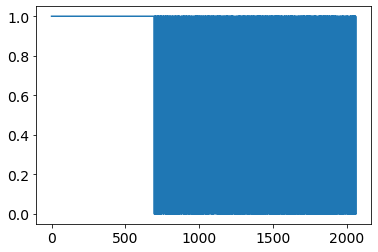

In [49]:
plt.plot(new_mask)

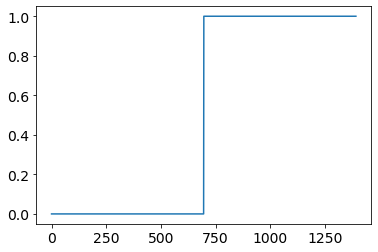

In [50]:
plt.plot(new_phase_mask)

In [10]:
sess_info.keys()

dict_keys(['trial_data', 'pop_rate', 'xloc', 'yloc', 'fr', 'seq_mask', 'id_peaks', 'bursts', 'speed', 'passid', 'lin_pos', 'loc', 'corr', 'Spike_times_cells', 't', 'extract', 'seqs', 'trial_idx_mask', 'Spike_binary_cells', 'Spike_binary', 'ids_clust', 'template'])

In [48]:
sessinfo_and_mask.keys()

NameError: name 'sessinfo_and_mask' is not defined

In [25]:

#sessinfo_and_mask=np.load(savefolder+fol1+'Sesseion_info_All AllNo_chunk_0.5s_transients'+'Randomized_seqs',allow_pickle=True)
sessinfo_and_mask=np.load(savefolder+fol1+'Sesseion_info_All AllNo_chunk_0.5s_transients',allow_pickle=True)

import random
n_subsampling_netropy = 1
Masks = sessinfo_and_mask['Masks']

sess_info = sessinfo_and_mask['sess_info']

smooth_speed=mot.smooth_signal(sess_info['speed'], 13)# moving average over .5  second
Masks['speed_seq']=np.asarray(smooth_speed)[sess_info['id_peaks']]>speed_thr
Masks['speed']=smooth_speed>speed_thr

temp_info_subsampling={}
seq_msk_ing=(np.asanyarray(Masks['bursts_phase'])==0)
seq_msk_ed=(np.asanyarray(Masks['bursts_phase'])==1)
seq_len_ing=np.sum((np.asanyarray(Masks['bursts_phase'])==0))# subsampling number
plot_figure=False# do not show the similarity matrix

subsampling_restults={'cluster_dist':{}}


for ss in range(n_subsampling_netropy):# subsampling
    print(ss)
    seqs=sess_info['seqs']# clustering will be done on all sequences (correct and failed trials). 
    bursts=sess_info['bursts']
    learned_new_phase_mask=np.zeros(np.sum(seq_msk_ed)).astype(bool)

    seq_learnedg=list(np.asarray(seqs)[seq_msk_ed])# all learned sequences
    burst_learned=list(np.asarray(bursts)[seq_msk_ed])# all learned bursts
    # Draw n random indices
    rnd_indices = random.sample(range(len(seq_learnedg)), seq_len_ing)# random saples withe length of learning data(shorter)
    learned_new_phase_mask[rnd_indices]=True
    new_mask=np.hstack((np.ones(np.sum(seq_msk_ing)).astype(bool),learned_new_phase_mask ))# Learnings set to 1, samples learned set to 1

    #correct_mask_subsampled=seq_msk_ed[rnd_indices]

    new_cond_mask=np.asarray(Masks['bursts_cond'])[new_mask]
    new_phase_mask=np.asarray(Masks['bursts_phase'])[new_mask]
    new_bursts_sess=np.asarray(Masks['bursts_sess'])[new_mask]


    new_correct_failed_mask=np.asarray(Masks['correct_failed_seqs'])[new_mask]

    seq_new=np.asarray(seqs)[new_mask]
    burst_new=np.asarray(bursts)[new_mask]
    id_peaks_new=np.asarray(sess_info['id_peaks'])[new_mask]
    #speed_seq_new= np.asarray(sess_info['speed_seq'])[new_mask]
    speed_seq_new= np.asarray(Masks['speed_seq'])[new_mask]

    # Use indices to get data from both lists
    random_seq_ed = [seq_learnedg[i] for i in rnd_indices]# get random subsampling bursts of learned data(longer) with the length of the learning bursts
    random_burst_ed = [burst_learned[i] for i in rnd_indices]
    
    # seq_new=list(np.asarray(seqs)[seq_msk_ing])+random_seq_ed# merging learnind and subsampled learned sequences
    # burst_new=list(np.asarray(bursts)[seq_msk_ing])+random_burst_ed


# seqs=sess_info['seqs']# clustering will be done on all sequences (correct and failed trials). 
# bursts=sess_info['bursts']

    #id_peaks=sess_info['id_peaks']
    #*************** compute clusters from sequences
    repid,nsig,pval,bmat,zmat,corrmat = mot.allmot(seq_new,nrm);
    ids_clust = mot.cluster(bmat,zmat,clstr_param)
    temp_info = mot.templates(burst_new,seq_new,nrm,ids_clust,min_ratio = min_ratio)
    print('cluster', temp_info['exclude'] ,'is removed')
    #temp_info_org=np.copy(temp_info['template'])
    temp_info_test = copy.deepcopy(temp_info)
    temp_info_new,mask = mot.merge_clusters2(temp_info,nrm,seq_new,burst_new,plot_figure,min_ratio=.1,z_thr=2.5)
    #id_peaks=dats['sp_idpeak']
    #sess_info['ids_clust'] = temp_info_new['ids_clust'][0]



    temp_info_subsampling[ss]=temp_info_new

    temp_info_subsampling[ss]['new_cond_mask']=new_cond_mask
    temp_info_subsampling[ss]['new_phase_mask']=new_phase_mask
    temp_info_subsampling[ss]['new_correct_failed_mask']=new_correct_failed_mask
    temp_info_subsampling[ss]['new_id_peaks']=id_peaks_new
    temp_info_subsampling[ss]['speed_seq_new']=speed_seq_new
    temp_info_subsampling[ss]['new_bursts_sess']=new_bursts_sess

# with open(savefolder+fol1+'Entropy_subsampling_modified_test2'+ '_'+place_cell_name+'_'+cell_types+'_'+descriotor+'.pkl','wb') as f:
#     pickle.dump(temp_info_subsampling, f) 

0


C:\Users\hamed\AppData\Local\Temp\ipykernel_25008\274287936.py:29: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  seq_learnedg=list(np.asarray(seqs)[seq_msk_ed])# all learned sequences
C:\Users\hamed\AppData\Local\Temp\ipykernel_25008\274287936.py:45: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  seq_new=np.asarray(seqs)[new_mask]


KeyboardInterrupt: 

In [15]:
speed_seq_new= np.asarray(Masks['speed_seq'])[new_mask]
temp_info_subsampling[ss]['speed_seq_new']=speed_seq_new

In [16]:
sess_info2=copy.deepcopy(sess_info)
Masks2=copy.deepcopy(Masks)

sess_info2['seqs']=temp_info_subsampling[ss]['seqs']#[0]
sess_info2['ids_clust']=temp_info_subsampling[ss]['ids_clust'][0]
sess_info2['id_peaks']=temp_info_subsampling[ss]['new_id_peaks']
sess_info2['bursts']=temp_info_subsampling[ss]['bursts'][0]

Masks2['bursts_cond']=temp_info_subsampling[ss]['new_cond_mask']
Masks2['bursts_phase']=temp_info_subsampling[ss]['new_phase_mask']
Masks2['correct_failed_seqs']=temp_info_subsampling[ss]['new_correct_failed_mask']

Masks2['speed_seq']=temp_info_subsampling[ss]['speed_seq_new']
Masks2['phase_mask']=temp_info_subsampling[ss]['new_phase_mask']
Masks2['cond_mask']=temp_info_subsampling[ss]['new_cond_mask']
Masks2['correct_failed_mask']=temp_info_subsampling[ss]['new_correct_failed_mask']


Masks2['bursts_sess']=temp_info_subsampling[ss]['new_bursts_sess']

In [17]:
import numpy as np
import pandas as pd
from scipy.spatial.distance import jensenshannon

# Create sample distributions with high and low values for comparison

# High difference distribution
high_diff_condition1 = {
    'cluster_number': np.array([1, 2, 3, 4, 5], dtype=int),
    'cluster_counts': np.array([50, 50, 50, 50, 50], dtype=int)
}

high_diff_condition2 = {
    'cluster_number': np.array([1, 2, 3, 4, 5], dtype=int),
    'cluster_counts': np.array([10, 10, 10, 10, 10], dtype=int)
}

# Low difference distribution
low_diff_condition1 = {
    'cluster_number': np.array([1, 2, 3, 4, 5], dtype=int),
    'cluster_counts': np.array([50, 50, 50, 50, 50], dtype=int)
}

low_diff_condition2 = {
    'cluster_number': np.array([1, 2, 3, 4, 5], dtype=int),
    'cluster_counts': np.array([48, 52, 49, 51, 50], dtype=int)
}

# Convert to DataFrame for easier manipulation
df_high_diff_condition1 = pd.DataFrame(high_diff_condition1)
df_high_diff_condition2 = pd.DataFrame(high_diff_condition2)

df_low_diff_condition1 = pd.DataFrame(low_diff_condition1)
df_low_diff_condition2 = pd.DataFrame(low_diff_condition2)

# Normalize the counts to get probability distributions
def normalize_counts(df):
    total = np.sum(df['cluster_counts'])
    return df['cluster_counts'] / total

high_diff_prob1 = normalize_counts(df_high_diff_condition1)
high_diff_prob2 = normalize_counts(df_high_diff_condition2)

low_diff_prob1 = normalize_counts(df_low_diff_condition1)
low_diff_prob2 = normalize_counts(df_low_diff_condition2)

# Calculate Jensen-Shannon Divergence
js_divergence_high = jensenshannon(high_diff_prob1, high_diff_prob2, base=2)
js_divergence_low = jensenshannon(low_diff_prob1, low_diff_prob2, base=2)

js_divergence_high, js_divergence_low



from scipy.stats import entropy

# Kullback-Leibler Divergence function
def kl_divergence(p, q):
    return entropy(p, q)

# Calculate Kullback-Leibler Divergence
kl_divergence_high = kl_divergence(high_diff_prob1, high_diff_prob2)
kl_divergence_low = kl_divergence(low_diff_prob1, low_diff_prob2)

kl_divergence_high, kl_divergence_low


(0.0, 0.0004002722776627731)

In [18]:
from scipy.spatial.distance import jensenshannon
# Convert to DataFrame for easier plotting
df_condition1 = pd.DataFrame(subsampling_restults['Learning_Correct'])
df_condition2 = pd.DataFrame(subsampling_restults['Learned_Correct'])
# Normalize the counts to get probability distributions
condition1_total = np.sum(df_condition1['clsuster_counts'])
condition2_total = np.sum(df_condition2['clsuster_counts'])

# Create a combined set of cluster numbers
all_cluster_numbers = sorted(set(df_condition1['cluster_number']).union(set(df_condition2['cluster_number'])))

# Initialize arrays for the probability distributions
condition1_prob = np.zeros(len(all_cluster_numbers))
condition2_prob = np.zeros(len(all_cluster_numbers))

# Populate the probability distributions
for i, cluster in enumerate(all_cluster_numbers):
    if cluster in df_condition1['cluster_number'].values:
        condition1_prob[i] = df_condition1.loc[df_condition1['cluster_number'] == cluster, 'clsuster_counts'].values[0] / condition1_total
    if cluster in df_condition2['cluster_number'].values:
        condition2_prob[i] = df_condition2.loc[df_condition2['cluster_number'] == cluster, 'clsuster_counts'].values[0] / condition2_total

# Calculate the Jensen-Shannon Divergence
js_divergence = jensenshannon(condition1_prob, condition2_prob, base=2)



# Calculate Kullback-Leibler Divergence
kl_divergence = entropy(condition1_prob, condition2_prob)

js_divergence


KeyError: 'Learning_Correct'

In [18]:
import numpy as np
import pandas as pd
from scipy.stats import entropy
from scipy.spatial.distance import jensenshannon
import matplotlib.pyplot as plt

def calculate_divergences(condition1_data, condition2_data, epsilon=1e-10):
    # Convert to DataFrame for easier manipulation
    df_condition1 = pd.DataFrame(condition1_data)
    df_condition2 = pd.DataFrame(condition2_data)

    # Create a common set of clusters
    all_clusters = sorted(set(df_condition1['cluster_number']).union(set(df_condition2['cluster_number'])))

    # Align the cluster counts to the common set of clusters
    def align_counts(df, all_clusters):
        aligned_counts = []
        for cluster in all_clusters:
            if cluster in df['cluster_number'].values:
                aligned_counts.append(df.loc[df['cluster_number'] == cluster, 'clsuster_counts'].values[0])
            else:
                aligned_counts.append(0)
        return np.array(aligned_counts, dtype=float)  # Convert to float

    aligned_counts1 = align_counts(df_condition1, all_clusters)
    aligned_counts2 = align_counts(df_condition2, all_clusters)

    # Add a small value to avoid zero probabilities (smoothing)
    aligned_counts1 += epsilon
    aligned_counts2 += epsilon

    # Normalize the counts to get probability distributions
    def normalize_counts(counts):
        total = np.sum(counts)
        return counts / total

    condition1_prob = normalize_counts(aligned_counts1)
    condition2_prob = normalize_counts(aligned_counts2)

    # Calculate Jensen-Shannon Divergence
    js_divergence = jensenshannon(condition1_prob, condition2_prob, base=2)

    # Calculate Kullback-Leibler Divergence
    kl_divergence = entropy(condition1_prob, condition2_prob)
    if 0:
        # Plot histograms for visual comparison
        plt.figure(figsize=(12, 6))

        plt.subplot(1, 2, 1)
        plt.bar(all_clusters, aligned_counts1, alpha=0.7, label='Condition 1', color='blue')
        plt.title('Condition 1 Histogram')
        plt.xlabel('Cluster Number')
        plt.ylabel('Counts')
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.bar(all_clusters, aligned_counts2, alpha=0.7, label='Condition 2', color='orange')
        plt.title('Condition 2 Histogram')
        plt.xlabel('Cluster Number')
        plt.ylabel('Counts')
        plt.legend()

        plt.tight_layout()
        plt.show()

    return js_divergence, kl_divergence




In [16]:
# import numpy as np
# import pandas as pd
# from scipy.stats import entropy
# from scipy.spatial.distance import jensenshannon
# import matplotlib.pyplot as plt


# # Convert to DataFrame for easier manipulation
# df_condition1 = pd.DataFrame(condition1_data)
# df_condition2 = pd.DataFrame(condition2_data)

# # Create a common set of clusters
# all_clusters = sorted(set(df_condition1['cluster_number']).union(set(df_condition2['cluster_number'])))

# # Align the cluster counts to the common set of clusters
# def align_counts(df, all_clusters):
#     aligned_counts = []
#     for cluster in all_clusters:
#         if cluster in df['cluster_number'].values:
#             aligned_counts.append(df.loc[df['cluster_number'] == cluster, 'cluster_counts'].values[0])
#         else:
#             aligned_counts.append(0)
#     return np.array(aligned_counts, dtype=float)  # Convert to float

# aligned_counts1 = align_counts(df_condition1, all_clusters)
# aligned_counts2 = align_counts(df_condition2, all_clusters)

# # Add a small value to avoid zero probabilities (smoothing)
# epsilon = 1e-10
# aligned_counts1 += epsilon
# aligned_counts2 += epsilon

# # Normalize the counts to get probability distributions
# def normalize_counts(counts):
#     total = np.sum(counts)
#     return counts / total

# condition1_prob = normalize_counts(aligned_counts1)
# condition2_prob = normalize_counts(aligned_counts2)

# # Calculate Jensen-Shannon Divergence
# js_divergence = jensenshannon(condition1_prob, condition2_prob, base=2)

# # Calculate Kullback-Leibler Divergence
# kl_divergence = entropy(condition1_prob, condition2_prob)

# print(f'Jensen-Shannon Divergence: {js_divergence}')
# print(f'Kullback-Leibler Divergence: {kl_divergence}')

# # Plot histograms for visual comparison
# plt.figure(figsize=(12, 6))

# plt.subplot(1, 2, 1)
# plt.bar(all_clusters, aligned_counts1, alpha=0.7, label='Condition 1', color='blue')
# plt.title('Condition 1 Histogram')
# plt.xlabel('Cluster Number')
# plt.ylabel('Counts')
# plt.legend()

# plt.subplot(1, 2, 2)
# plt.bar(all_clusters, aligned_counts2, alpha=0.7, label='Condition 2', color='orange')
# plt.title('Condition 2 Histogram')
# plt.xlabel('Cluster Number')
# plt.ylabel('Counts')
# plt.legend()

# plt.tight_layout()
# plt.show()


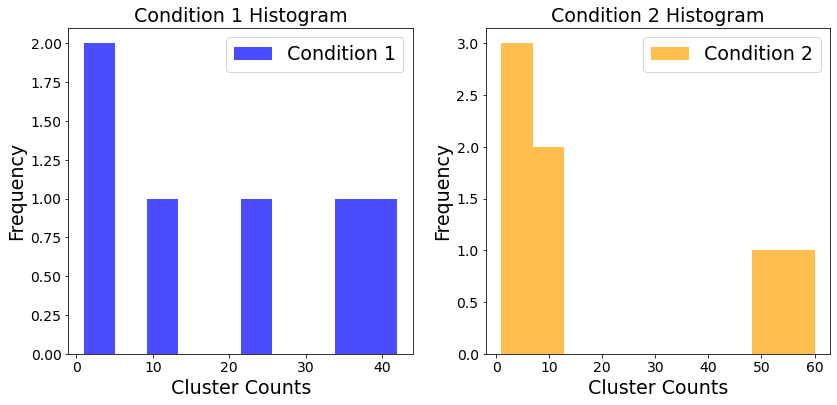

(0.2857142857142857, 0.8717948717948718)

In [61]:
import numpy as np
from scipy.stats import ks_2samp
import matplotlib.pyplot as plt

# Data for condition 1
condition1_cluster_counts = np.array([25, 34,  2,  1, 42, 11])

# Data for condition 2
condition2_cluster_counts = np.array([60, 10,  3,  6,  1, 12, 54])

# Kolmogorov-Smirnov test
ks_statistic, p_value = ks_2samp(condition1_cluster_counts, condition2_cluster_counts)

# Plot histograms for visual comparison
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.hist(condition1_cluster_counts, bins=10, alpha=0.7, label='Condition 1', color='blue')
plt.title('Condition 1 Histogram')
plt.xlabel('Cluster Counts')
plt.ylabel('Frequency')
plt.legend()

plt.subplot(1, 2, 2)
plt.hist(condition2_cluster_counts, bins=10, alpha=0.7, label='Condition 2', color='orange')
plt.title('Condition 2 Histogram')
plt.xlabel('Cluster Counts')
plt.ylabel('Frequency')
plt.legend()

plt.tight_layout()
plt.show()

ks_statistic, p_value


In [20]:
def plot_kl_distributions_ss(js_divergence_ss,p_value_corr_js_,name,type='Correct'):
    plt.figure(figsize=(6, 4))
    # Define the bins for both histograms
    bins = np.linspace(0, max(max(js_divergence_ss[type]), max(js_divergence_ss[type+'_sh'])), 20)
    # Determine the maximum y limit for both plots
    max_y = max(
        max(np.histogram(js_divergence_ss[type], bins=bins)[0]),
        max(np.histogram(js_divergence_ss[type+'_sh'], bins=bins)[0])
    )+2

    plt.subplot(1, 2, 1)
    sns.histplot(js_divergence_ss[type], bins=bins, kde=True, color='blue', label='Original')
    plt.title(name[:-2])
    plt.xlabel(name[-2:])
    plt.ylabel('Frequency')
    plt.legend()
    plt.ylim(0, max_y)

    #plt.subplot(1, 2, 2)
    sns.histplot(js_divergence_ss[type+'_sh'], bins=bins, kde=True, color='orange', label='Shuffled')
    #plt.title('Learned vs Learning shuffled')
    plt.xlabel(name[-2:])
    plt.ylabel('Occurrence')
    plt.ylim
    plt.legend(fontsize=10,loc='upper right')
    plt.ylim(0, max_y)

    plt.suptitle(f'pval={p_value_corr_js_:.3f}', x=0.405, fontsize=14)
    plt.tight_layout()
    plt.show()

In [20]:
def get_pval(orignial,shuffled):
    pvalue= 1- np.sum(orignial>np.mean(shuffled))/len(orignial)
    return pvalue

In [97]:
p_value_learning_js_= get_pval(js_divergence_ss['Correct_vs_Failed_Learning'],js_divergence_ss['Correct_vs_Failed_Learning_sh'])
p_value_learned_js_= get_pval(js_divergence_ss['Correct_vs_Failed_Learned'],js_divergence_ss['Correct_vs_Failed_Learned_sh'])


In [98]:
p_value_learning_js_

1.0

In [82]:
animallist=['478','481','483','485']
#animallist=['478']


In [63]:
# Visualize sampling cluster distributions
cond='sampling'#+animallist[0]
sampling_clusters={}
sampling_clusters_shuffled={}

subsampling_restults={}
subsampling_restults_shuffled={}
# Get cluster distribution  of sampling period
ss_nbr=1
phases={'Learning':0,'Learned':1}
corr_failed={'Failed':0,'Correct':1}
js_divergence_ss={'Learning_vs_Learned_Correct':[],'Learning_vs_Learned_Correct_sh':[],'Learned_vs_Learning_Correct':[],'Learning_vs_Learned_Failed':[],'Learning_vs_Learned_Failed_sh':[],'Learned_vs_Learning_Failed':[]
                  ,'Correct_vs_Failed_Learning':[],'Correct_vs_Failed_Learning_sh':[],'Correct_vs_Failed_Learned':[],'Correct_vs_Failed_Learned_sh':[]}
kl_divergence_ss={'Learning_vs_Learned_Correct':[],'Learning_vs_Learned_Correct_sh':[],'Learned_vs_Learning_Correct':[],'Learning_vs_Learned_Failed':[],'Learning_vs_Learned_Failed_sh':[],'Learned_vs_Learning_Failed':[],
                  'Correct_vs_Failed_Learning':[],'Correct_vs_Failed_Learning_sh':[],'Correct_vs_Failed_Learned':[],'Correct_vs_Failed_Learned_sh':[]}
plt.rcParams['axes.titlesize'] = 17  # Set the title font size
plt.rcParams.update({'font.size': 10})
plt.rcParams['axes.titlesize'] = 17
plt.rcParams['xtick.labelsize'] = 17  # You can adjust the font size as needed
plt.rcParams['ytick.labelsize'] = 17 # You can adjust the font size as needed
plt.rcParams.update({'font.size': 16})

for fol1 in animallist:
        
    ss_data_info=np.load(savefolder+fol1+'Entropy_subsampling_modified'+ '_'+place_cell_name+'_'+cell_types+'_'+descriotor+'.pkl',allow_pickle=True)




    for ss_nbr in range(len(ss_data_info)):

        for phase in phases.keys():
            phase_nbr=phases[phase]
            for cf in corr_failed.keys():
                corr_failed_nbr=corr_failed[cf]

                org_laels=ss_data_info[ss_nbr]['new_phase_mask']
                shuffled_labels=copy.copy(org_laels)
                random.shuffle(shuffled_labels)# shuffle learning and learned labels


                cond_lbl= [cond_names[cond_name] for cond_name in cond_names if cond in cond_name]
                #sampling_mask = (ss_data_info[ss_nbr]['new_cond_mask']==1) | (ss_data_info[ss_nbr]['new_cond_mask']==0)
                sampling_mask = (ss_data_info[ss_nbr]['new_cond_mask']==cond_lbl[0]) | (ss_data_info[ss_nbr]['new_cond_mask']==cond_lbl[1])


                learned_mask = (org_laels==phase_nbr) 
                correct_mask = (ss_data_info[ss_nbr]['new_correct_failed_mask']==corr_failed_nbr) 
                

                mask_sampling_correct_learned=correct_mask & learned_mask & sampling_mask

                sampling_clusters[phase+'_'+cf]=np.asarray(ss_data_info[ss_nbr]['ids_clust'][0])[mask_sampling_correct_learned]

                labels, counts = np.unique(ss_data_info[ss_nbr]['ids_clust'][0][mask_sampling_correct_learned], return_counts=True)
                subsampling_restults[phase+'_'+cf]= {'seq_len':len(ss_data_info[ss_nbr]['ids_clust'][0][mask_sampling_correct_learned]),
                                                                                            'cluster_number': labels, 'clsuster_counts':counts}


                learned_mask_sh = (shuffled_labels==phase_nbr) 

                mask_sampling_correct_learned_sh=correct_mask & learned_mask_sh & sampling_mask

                sampling_clusters_shuffled[phase+'_'+cf]=np.asarray(ss_data_info[ss_nbr]['ids_clust'][0])[mask_sampling_correct_learned_sh]

                labels, counts = np.unique(ss_data_info[ss_nbr]['ids_clust'][0][mask_sampling_correct_learned_sh], return_counts=True)
                subsampling_restults_shuffled[phase+'_'+cf]= {'seq_len':len(ss_data_info[ss_nbr]['ids_clust'][0][mask_sampling_correct_learned_sh]),
                                                                                            'cluster_number': labels, 'clsuster_counts':counts}
                



        js_divergence, kl_divergence = calculate_divergences(subsampling_restults['Learning_Correct'], subsampling_restults['Learning_Failed'])
        js_divergence_ss['Correct_vs_Failed_Learning'].append(js_divergence)
        kl_divergence_ss['Correct_vs_Failed_Learning'].append(kl_divergence)
        js_divergence_sh, kl_divergence_sh = calculate_divergences(subsampling_restults_shuffled['Learning_Correct'], subsampling_restults_shuffled['Learning_Failed'])
        js_divergence_ss['Correct_vs_Failed_Learning_sh'].append(js_divergence_sh)
        kl_divergence_ss['Correct_vs_Failed_Learning_sh'].append(kl_divergence_sh)

        js_divergence, kl_divergence = calculate_divergences(subsampling_restults['Learned_Correct'], subsampling_restults['Learned_Failed'])
        js_divergence_ss['Correct_vs_Failed_Learned'].append(js_divergence)
        kl_divergence_ss['Correct_vs_Failed_Learned'].append(kl_divergence)
        js_divergence, kl_divergence = calculate_divergences(subsampling_restults_shuffled['Learned_Correct'], subsampling_restults_shuffled['Learned_Failed'])
        js_divergence_ss['Correct_vs_Failed_Learned_sh'].append(js_divergence)
        kl_divergence_ss['Correct_vs_Failed_Learned_sh'].append(kl_divergence)



        js_divergence, kl_divergence = calculate_divergences(subsampling_restults['Learning_Correct'], subsampling_restults['Learned_Correct'])
        js_divergence_ss['Learning_vs_Learned_Correct'].append(js_divergence)
        kl_divergence_ss['Learning_vs_Learned_Correct'].append(kl_divergence)
        js_divergence_sh, kl_divergence_sh = calculate_divergences(subsampling_restults_shuffled['Learning_Correct'], subsampling_restults_shuffled['Learned_Correct'])
        js_divergence_ss['Learning_vs_Learned_Correct_sh'].append(js_divergence_sh)
        kl_divergence_ss['Learning_vs_Learned_Correct_sh'].append(kl_divergence_sh)

        js_divergence, kl_divergence = calculate_divergences(subsampling_restults['Learning_Failed'], subsampling_restults['Learned_Failed'])
        js_divergence_ss['Learning_vs_Learned_Failed'].append(js_divergence)
        kl_divergence_ss['Learning_vs_Learned_Failed'].append(kl_divergence)
        js_divergence, kl_divergence = calculate_divergences(subsampling_restults_shuffled['Learning_Failed'], subsampling_restults_shuffled['Learned_Failed'])
        js_divergence_ss['Learning_vs_Learned_Failed_sh'].append(js_divergence)
        kl_divergence_ss['Learning_vs_Learned_Failed_sh'].append(kl_divergence)










        # js_divergence, kl_divergence = calculate_divergences(subsampling_restults['Learning_Failed'], subsampling_restults['Learning_Correct'])
        # js_divergence_ss['Correct_vs_Failed_Learning'].append(js_divergence)
        # kl_divergence_ss['Correct_vs_Failed_Learning'].append(kl_divergence)
        # js_divergence_sh, kl_divergence_sh = calculate_divergences(subsampling_restults_shuffled['Learning_Failed'], subsampling_restults_shuffled['Learning_Correct'])
        # js_divergence_ss['Correct_vs_Failed_Learning_sh'].append(js_divergence_sh)
        # kl_divergence_ss['Correct_vs_Failed_Learning_sh'].append(kl_divergence_sh)

        # js_divergence, kl_divergence = calculate_divergences(subsampling_restults['Learned_Correct'], subsampling_restults['Learned_Failed'])
        # js_divergence_ss['Correct_vs_Failed_Learned'].append(js_divergence)
        # kl_divergence_ss['Correct_vs_Failed_Learned'].append(kl_divergence)
        # js_divergence, kl_divergence = calculate_divergences(subsampling_restults_shuffled['Learned_Correct'], subsampling_restults_shuffled['Learned_Failed'])
        # js_divergence_ss['Correct_vs_Failed_Learned_sh'].append(js_divergence)
        # kl_divergence_ss['Correct_vs_Failed_Learned_sh'].append(kl_divergence)



        # js_divergence, kl_divergence = calculate_divergences(subsampling_restults['Learned_Correct'], subsampling_restults['Learning_Correct'])
        # js_divergence_ss['Learning_vs_Learned_Correct'].append(js_divergence)
        # kl_divergence_ss['Learning_vs_Learned_Correct'].append(kl_divergence)
        # js_divergence_sh, kl_divergence_sh = calculate_divergences(subsampling_restults_shuffled['Learned_Correct'], subsampling_restults_shuffled['Learning_Correct'])
        # js_divergence_ss['Learning_vs_Learned_Correct_sh'].append(js_divergence_sh)
        # kl_divergence_ss['Learning_vs_Learned_Correct_sh'].append(kl_divergence_sh)

        # js_divergence, kl_divergence = calculate_divergences(subsampling_restults['Learned_Failed'], subsampling_restults['Learning_Failed'])
        # js_divergence_ss['Learning_vs_Learned_Failed'].append(js_divergence)
        # kl_divergence_ss['Learning_vs_Learned_Failed'].append(kl_divergence)
        # js_divergence, kl_divergence = calculate_divergences(subsampling_restults_shuffled['Learned_Failed'], subsampling_restults_shuffled['Learning_Failed'])
        # js_divergence_ss['Learning_vs_Learned_Failed_sh'].append(js_divergence)
        # kl_divergence_ss['Learning_vs_Learned_Failed_sh'].append(kl_divergence)









p_value_corr_kl_= get_pval(kl_divergence_ss['Learning_vs_Learned_Correct'],kl_divergence_ss['Learning_vs_Learned_Correct_sh'])
p_value_failed_kl_= get_pval(kl_divergence_ss['Learning_vs_Learned_Failed'],kl_divergence_ss['Learning_vs_Learned_Failed_sh'])

p_value_corr_js_= get_pval(js_divergence_ss['Learning_vs_Learned_Correct'],js_divergence_ss['Learning_vs_Learned_Correct_sh'])
p_value_failed_js_= get_pval(js_divergence_ss['Learning_vs_Learned_Failed'],js_divergence_ss['Learning_vs_Learned_Failed_sh'])



fol1=''

p_value_learning_kl_= get_pval(kl_divergence_ss['Correct_vs_Failed_Learning'],kl_divergence_ss['Correct_vs_Failed_Learning_sh'])
p_value_learned_kl_= get_pval(kl_divergence_ss['Correct_vs_Failed_Learned'],kl_divergence_ss['Correct_vs_Failed_Learned_sh'])

p_value_learning_js_= get_pval(js_divergence_ss['Correct_vs_Failed_Learning'],js_divergence_ss['Correct_vs_Failed_Learning_sh'])
p_value_learned_js_= get_pval(js_divergence_ss['Correct_vs_Failed_Learned'],js_divergence_ss['Correct_vs_Failed_Learned_sh'])



  
plot_kl_distributions_ss(js_divergence_ss,p_value_corr_js_,name=' Learning_vs_Learned_Correct'+' JS',type='Learning_vs_Learned_Correct')
plot_kl_distributions_ss(js_divergence_ss,p_value_failed_js_,name=' Learning_vs_Learned_Failed'+' JS',type='Learning_vs_Learned_Failed')

plot_kl_distributions_ss(kl_divergence_ss,p_value_corr_kl_,name=' Learning_vs_Learned_Correct'+' KL',type='Learning_vs_Learned_Correct')
plot_kl_distributions_ss(kl_divergence_ss,p_value_failed_kl_,name=' Learning_vs_Learned_Failed'+' KL',type='Learning_vs_Learned_Failed')



  
plot_kl_distributions_ss(js_divergence_ss,p_value_learning_js_,name=' Correct_vs_Failed_Learning'+' JS',type='Correct_vs_Failed_Learning')
plot_kl_distributions_ss(js_divergence_ss,p_value_learned_js_,name=' Correct_vs_Failed_Learned'+' JS',type='Correct_vs_Failed_Learned')

plot_kl_distributions_ss(kl_divergence_ss,p_value_learning_kl_,name=' Correct_vs_Failed_Learning'+' KL',type='Correct_vs_Failed_Learning')
plot_kl_distributions_ss(kl_divergence_ss,p_value_learned_kl_,name=' Correct_vs_Failed_Learned'+' KL',type='Correct_vs_Failed_Learned')

NameError: name 'animallist' is not defined

In [69]:
# # Visualize sampling cluster distributions
# cond='sampling'
# sampling_clusters={}
# sampling_clusters_shuffled={}

# subsampling_restults={}
# subsampling_restults_shuffled={}
# # Get cluster distribution  of sampling period
# ss_nbr=1
# phases={'Learning':0,'Learned':1}
# corr_failed={'Failed':0,'Correct':1}
# js_divergence_ss={'Learning_vs_Learned_Correct':[],'Learning_vs_Learned_Correct_sh':[],'Learned_vs_Learning_Correct':[],'Learning_vs_Learned_Failed':[],'Learning_vs_Learned_Failed_sh':[],'Learned_vs_Learning_Failed':[]}
# kl_divergence_ss={'Learning_vs_Learned_Correct':[],'Learning_vs_Learned_Correct_sh':[],'Learned_vs_Learning_Correct':[],'Learning_vs_Learned_Failed':[],'Learning_vs_Learned_Failed_sh':[],'Learned_vs_Learning_Failed':[]}
# plt.rcParams.update({'font.size': 12})
# plt.rcParams['axes.titlesize'] = 16
# plt.rcParams['xtick.labelsize'] = 16  # You can adjust the font size as needed
# plt.rcParams['ytick.labelsize'] = 16  # You can adjust the font size as needed

# for fol1 in animallist:
        
#     ss_data_info=np.load(savefolder+fol1+'Entropy_subsampling_modified'+ '_'+place_cell_name+'_'+cell_types+'_'+descriotor+'.pkl',allow_pickle=True)




#     for ss_nbr in range(len(ss_data_info)):


#         for phase in phases.keys():
#             phase_nbr=phases[phase]
#             for cf in corr_failed.keys():
#                 corr_failed_nbr=corr_failed[cf]

#                 org_laels=ss_data_info[ss_nbr]['new_phase_mask']
#                 shuffled_labels=copy.copy(org_laels)
#                 random.shuffle(shuffled_labels)# shuffle learning and learned labels


#                 cond_lbl= [cond_names[cond_name] for cond_name in cond_names if cond in cond_name]
#                 #sampling_mask = (ss_data_info[ss_nbr]['new_cond_mask']==1) | (ss_data_info[ss_nbr]['new_cond_mask']==0)
#                 sampling_mask = (ss_data_info[ss_nbr]['new_cond_mask']==cond_lbl[0]) | (ss_data_info[ss_nbr]['new_cond_mask']==cond_lbl[1])


#                 learned_mask = (org_laels==phase_nbr) 
#                 correct_mask = (ss_data_info[ss_nbr]['new_correct_failed_mask']==corr_failed_nbr) 
                

#                 mask_sampling_correct_learned=correct_mask & learned_mask & sampling_mask

#                 sampling_clusters[phase+'_'+cf]=np.asarray(ss_data_info[ss_nbr]['ids_clust'][0])[mask_sampling_correct_learned]

#                 labels, counts = np.unique(ss_data_info[ss_nbr]['ids_clust'][0][mask_sampling_correct_learned], return_counts=True)
#                 subsampling_restults[phase+'_'+cf]= {'seq_len':len(ss_data_info[ss_nbr]['ids_clust'][0][mask_sampling_correct_learned]),
#                                                                                             'cluster_number': labels, 'clsuster_counts':counts}


#                 learned_mask_sh = (shuffled_labels==phase_nbr) 

#                 mask_sampling_correct_learned_sh=correct_mask & learned_mask_sh & sampling_mask

#                 sampling_clusters_shuffled[phase+'_'+cf]=np.asarray(ss_data_info[ss_nbr]['ids_clust'][0])[mask_sampling_correct_learned_sh]

#                 labels, counts = np.unique(ss_data_info[ss_nbr]['ids_clust'][0][mask_sampling_correct_learned_sh], return_counts=True)
#                 subsampling_restults_shuffled[phase+'_'+cf]= {'seq_len':len(ss_data_info[ss_nbr]['ids_clust'][0][mask_sampling_correct_learned_sh]),
#                                                                                             'cluster_number': labels, 'clsuster_counts':counts}
                



#         js_divergence, kl_divergence = calculate_divergences(subsampling_restults['Learning_Correct'], subsampling_restults['Learned_Correct'])
#         js_divergence_ss['Learning_vs_Learned_Correct'].append(js_divergence)
#         kl_divergence_ss['Learning_vs_Learned_Correct'].append(kl_divergence)
#         js_divergence_sh, kl_divergence_sh = calculate_divergences(subsampling_restults_shuffled['Learning_Correct'], subsampling_restults_shuffled['Learned_Correct'])
#         js_divergence_ss['Learning_vs_Learned_Correct_sh'].append(js_divergence_sh)
#         kl_divergence_ss['Learning_vs_Learned_Correct_sh'].append(kl_divergence_sh)

#         js_divergence, kl_divergence = calculate_divergences(subsampling_restults['Learning_Failed'], subsampling_restults['Learned_Failed'])
#         js_divergence_ss['Learning_vs_Learned_Failed'].append(js_divergence)
#         kl_divergence_ss['Learning_vs_Learned_Failed'].append(kl_divergence)
#         js_divergence, kl_divergence = calculate_divergences(subsampling_restults_shuffled['Learning_Failed'], subsampling_restults_shuffled['Learned_Failed'])
#         js_divergence_ss['Learning_vs_Learned_Failed_sh'].append(js_divergence)
#         kl_divergence_ss['Learning_vs_Learned_Failed_sh'].append(kl_divergence)

# p_value_corr_kl_= get_pval(kl_divergence_ss['Learning_vs_Learned_Correct'],kl_divergence_ss['Learning_vs_Learned_Correct_sh'])
# p_value_failed_kl_= get_pval(kl_divergence_ss['Learning_vs_Learned_Failed'],kl_divergence_ss['Learning_vs_Learned_Failed_sh'])

# p_value_corr_js_= get_pval(js_divergence_ss['Learning_vs_Learned_Correct'],js_divergence_ss['Learning_vs_Learned_Correct_sh'])
# p_value_failed_js_= get_pval(js_divergence_ss['Learning_vs_Learned_Failed'],js_divergence_ss['Learning_vs_Learned_Failed_sh'])



# fol1='All'
  
# plot_kl_distributions_ss(js_divergence_ss,p_value_corr_js_,name=fol1+' ' +cond+' JS',type='Learning_vs_Learned_Correct')
# plot_kl_distributions_ss(js_divergence_ss,p_value_failed_js_,name=fol1+' ' +cond+' JS',type='Learning_vs_Learned_Failed')

# plot_kl_distributions_ss(kl_divergence_ss,p_value_corr_kl_,name=fol1+' ' +cond+' KL',type='Learning_vs_Learned_Correct')
# plot_kl_distributions_ss(kl_divergence_ss,p_value_failed_kl_,name=fol1+' ' +cond+' KL',type='Learning_vs_Learned_Failed')

In [47]:
ss_data_info[0]['speed']

KeyError: 'speed'

In [19]:
# Visualize sampling cluster distributions
fol1='485'
ss_data_info=np.load(savefolder+fol1+'Entropy_subsampling_modified'+ '_'+place_cell_name+'_'+cell_types+'_'+descriotor+'.pkl',allow_pickle=True)


sampling_clusters={}
sampling_clusters_shuffled={}

subsampling_restults={}
subsampling_restults_shuffled={}
# Get cluster distribution  of sampling period
ss_nbr=1
phases={'Learning':0,'Learned':1}
corr_failed={'Failed':0,'Correct':1}
js_divergence_ss={'Learning_vs_Learned_Correct':[],'Learning_vs_Learned_Correct_sh':[],'Learned_vs_Learning_Correct':[],'Learning_vs_Learned_Failed':[],'Learning_vs_Learned_Failed_sh':[],'Learned_vs_Learning_Failed':[]}
kl_divergence_ss={'Learning_vs_Learned_Correct':[],'Learning_vs_Learned_Correct_sh':[],'Learned_vs_Learning_Correct':[],'Learning_vs_Learned_Failed':[],'Learning_vs_Learned_Failed_sh':[],'Learned_vs_Learning_Failed':[]}

for ss_nbr in range(len(ss_data_info)):


    for phase in phases.keys():
        phase_nbr=phases[phase]
        for cf in corr_failed.keys():
            corr_failed_nbr=corr_failed[cf]

            org_laels=ss_data_info[ss_nbr]['new_phase_mask']
            shuffled_labels=copy.copy(org_laels)
            random.shuffle(shuffled_labels)# shuffle learning and learned labels



            sampling_mask = (ss_data_info[ss_nbr]['new_cond_mask']==1) | (ss_data_info[ss_nbr]['new_cond_mask']==0)
            learned_mask = (org_laels==phase_nbr) 
            correct_mask = (ss_data_info[ss_nbr]['new_correct_failed_mask']==corr_failed_nbr) 
            

            mask_sampling_correct_learned=correct_mask & learned_mask & sampling_mask

            sampling_clusters[phase+'_'+cf]=np.asarray(ss_data_info[ss_nbr]['ids_clust'][0])[mask_sampling_correct_learned]

            labels, counts = np.unique(ss_data_info[ss_nbr]['ids_clust'][0][mask_sampling_correct_learned], return_counts=True)
            subsampling_restults[phase+'_'+cf]= {'seq_len':len(ss_data_info[ss_nbr]['ids_clust'][0][mask_sampling_correct_learned]),
                                                                                        'cluster_number': labels, 'clsuster_counts':counts}


            learned_mask_sh = (shuffled_labels==phase_nbr) 

            mask_sampling_correct_learned_sh=correct_mask & learned_mask_sh & sampling_mask

            sampling_clusters_shuffled[phase+'_'+cf]=np.asarray(ss_data_info[ss_nbr]['ids_clust'][0])[mask_sampling_correct_learned_sh]

            labels, counts = np.unique(ss_data_info[ss_nbr]['ids_clust'][0][mask_sampling_correct_learned_sh], return_counts=True)
            subsampling_restults_shuffled[phase+'_'+cf]= {'seq_len':len(ss_data_info[ss_nbr]['ids_clust'][0][mask_sampling_correct_learned_sh]),
                                                                                        'cluster_number': labels, 'clsuster_counts':counts}
            




    js_divergence, kl_divergence = calculate_divergences(subsampling_restults['Learning_Correct'], subsampling_restults['Learned_Correct'])
    js_divergence_ss['Learning_vs_Learned_Correct'].append(js_divergence)
    kl_divergence_ss['Learning_vs_Learned_Correct'].append(kl_divergence)
    js_divergence_sh, kl_divergence_sh = calculate_divergences(subsampling_restults_shuffled['Learning_Correct'], subsampling_restults_shuffled['Learned_Correct'])
    js_divergence_ss['Learning_vs_Learned_Correct_sh'].append(js_divergence_sh)
    kl_divergence_ss['Learning_vs_Learned_Correct_sh'].append(kl_divergence_sh)

    js_divergence, kl_divergence = calculate_divergences(subsampling_restults['Learning_Failed'], subsampling_restults['Learned_Failed'])
    js_divergence_ss['Learning_vs_Learned_Failed'].append(js_divergence)
    kl_divergence_ss['Learning_vs_Learned_Failed'].append(kl_divergence)
    js_divergence, kl_divergence = calculate_divergences(subsampling_restults_shuffled['Learning_Failed'], subsampling_restults_shuffled['Learned_Failed'])
    js_divergence_ss['Learning_vs_Learned_Failed_sh'].append(js_divergence)
    kl_divergence_ss['Learning_vs_Learned_Failed_sh'].append(kl_divergence)




    js_divergence, kl_divergence = calculate_divergences(subsampling_restults['Learned_Correct'],subsampling_restults['Learning_Correct'])
    js_divergence_ss['Learned_vs_Learning_Correct'].append(js_divergence)
    kl_divergence_ss['Learned_vs_Learning_Correct'].append(kl_divergence)



    js_divergence, kl_divergence = calculate_divergences(subsampling_restults['Learned_Failed'],subsampling_restults['Learning_Failed'])
    js_divergence_ss['Learned_vs_Learning_Failed'].append(js_divergence)
    kl_divergence_ss['Learned_vs_Learning_Failed'].append(kl_divergence)



u_statistic, p_value_corr_kl = stats.mannwhitneyu( kl_divergence_ss['Learning_vs_Learned_Correct'], kl_divergence_ss['Learning_vs_Learned_Correct_sh'], alternative='two-sided')
u_statistic, p_value_failed_kl = stats.mannwhitneyu( kl_divergence_ss['Learning_vs_Learned_Failed'], kl_divergence_ss['Learning_vs_Learned_Failed_sh'], alternative='two-sided')

u_statistic, p_value_corr_js = stats.mannwhitneyu( js_divergence_ss['Learning_vs_Learned_Correct'], js_divergence_ss['Learning_vs_Learned_Correct_sh'], alternative='two-sided')
u_statistic, p_value_failed_js = stats.mannwhitneyu( js_divergence_ss['Learning_vs_Learned_Failed'], js_divergence_ss['Learning_vs_Learned_Failed_sh'], alternative='two-sided')

p_value_corr_kl_= get_pval(kl_divergence_ss['Learning_vs_Learned_Correct'],kl_divergence_ss['Learning_vs_Learned_Correct_sh'])
p_value_failed_kl_= get_pval(kl_divergence_ss['Learning_vs_Learned_Failed'],kl_divergence_ss['Learning_vs_Learned_Failed_sh'])

p_value_corr_js_= get_pval(kl_divergence_ss['Learning_vs_Learned_Correct'],kl_divergence_ss['Learning_vs_Learned_Correct_sh'])
p_value_failed_js_= get_pval(kl_divergence_ss['Learning_vs_Learned_Failed'],kl_divergence_ss['Learning_vs_Learned_Failed_sh'])

print(p_value_corr_kl,p_value_failed_kl,p_value_corr_js,p_value_failed_js)
print(p_value_corr_kl_,p_value_failed_kl_,p_value_corr_js_,p_value_failed_js_)

# Rounding the values to two decimal places
pval_js_kl = {
    'p_value_corr_kl_': [p_value_corr_kl_],
    'p_value_failed_kl_': [p_value_failed_kl_],
    'p_value_corr_js_': [p_value_corr_js_],
    'p_value_failed_js_': [p_value_failed_js_]
}

# Converting the dictionary to a pandas DataFrame
df_pval_js_kl = pd.DataFrame(pval_js_kl)
df_rounded_pval_js_kl = df_pval_js_kl.round(2)

plot_kl_distributions_ss(js_divergence_ss,p_value_corr_js_,name=fol1+'JS',type='Correct')

plot_kl_distributions_ss(js_divergence_ss,p_value_failed_js_,name=fol1+'JS',type='Failed')

plot_kl_distributions_ss(kl_divergence_ss,p_value_failed_kl_,name=fol1+'KL',type='Correct')

plot_kl_distributions_ss(kl_divergence_ss,p_value_failed_kl_,name=fol1+'KL',type='Failed')

#tools.display_dataframe_to_user(name="Rounded Values Table", dataframe=df_rounded_pval_js_kl)

# # Create a 2x2 grid of subplots
# fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 8))
# axes = axes.flatten()  # Flatten the 2D array of axes to 1D for easy iteration

# # Plotting histograms
# for ax, (key, values) in zip(axes, sampling_clusters.items()):
#     ax.hist(values, bins=20, color='skyblue', alpha=0.7)  # Adjust bins as needed
#     ent=mot.calculate_shannon_entropy(subsampling_restults[key])
    
#     ax.text(12,15,'Ent = ' +f'{ent: .2f}')
#     ax.set_ylim([0,70])
#     ax.set_title(key)
#     ax.set_xlabel('Cluster #')
#     ax.set_ylabel('Occurrence')
# plt.suptitle('Sampling period (ss) example animal: '+fol1)
# # Adjust layout to prevent overlap
# plt.tight_layout()
# plt.show()

NameError: name 'get_pval' is not defined

In [20]:
plot_kl_distributions_ss(js_divergence_ss,p_value_corr_js_,name=fol1+'JS',type='Correct')

NameError: name 'plot_kl_distributions_ss' is not defined

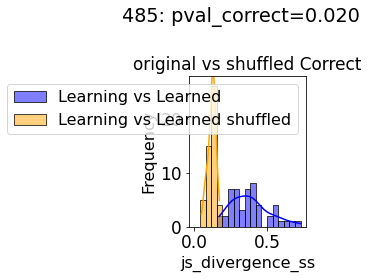

In [71]:
# Plot histograms and KDE plots
plt.figure(figsize=(6, 4))
# Define the bins for both histograms
bins = np.linspace(0, max(max(js_divergence_ss['Learning_vs_Learned_Correct']), max(js_divergence_ss['Learning_vs_Learned_Correct_sh'])), 20)
# Determine the maximum y limit for both plots
max_y = max(
    max(np.histogram(js_divergence_ss['Learning_vs_Learned_Correct'], bins=bins)[0]),
    max(np.histogram(js_divergence_ss['Learning_vs_Learned_Correct_sh'], bins=bins)[0])
)+2

plt.subplot(1, 2, 1)
sns.histplot(js_divergence_ss['Learning_vs_Learned_Correct'], bins=bins, kde=True, color='blue', label='Learning vs Learned')
plt.title('original vs shuffled Correct')
plt.xlabel('js_divergence_ss')
plt.ylabel('Frequency')
plt.legend()
plt.ylim(0, max_y)

#plt.subplot(1, 2, 2)
sns.histplot(js_divergence_ss['Learning_vs_Learned_Correct_sh'], bins=bins, kde=True, color='orange', label='Learning vs Learned shuffled')
#plt.title('Learned vs Learning shuffled')
plt.xlabel('js_divergence_ss')
plt.ylabel('Frequency')
plt.ylim
plt.legend()
plt.ylim(0, max_y)

plt.suptitle(fol1+ ': '+f'pval_correct={p_value_corr_js_:.3f}')
plt.tight_layout()
plt.show()

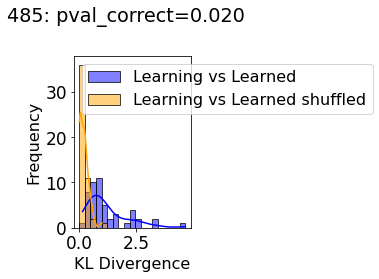

In [72]:
# Plot histograms and KDE plots
plt.figure(figsize=(6, 4))
# Define the bins for both histograms
bins = np.linspace(0, max(max(kl_divergence_ss['Learning_vs_Learned_Correct']), max(kl_divergence_ss['Learning_vs_Learned_Correct_sh'])), 20)
# Determine the maximum y limit for both plots
max_y = max(
    max(np.histogram(kl_divergence_ss['Learning_vs_Learned_Correct'], bins=bins)[0]),
    max(np.histogram(kl_divergence_ss['Learning_vs_Learned_Correct_sh'], bins=bins)[0])
)+2

plt.subplot(1, 2, 1)
sns.histplot(kl_divergence_ss['Learning_vs_Learned_Correct'], bins=bins, kde=True, color='blue', label='Learning vs Learned')
#plt.title('KL Divergence: Learning vs Learned')
plt.xlabel('KL Divergence')
plt.ylabel('Frequency')
plt.legend()
plt.ylim(0, max_y)

#plt.subplot(1, 2, 2)
sns.histplot(kl_divergence_ss['Learning_vs_Learned_Correct_sh'], bins=bins, kde=True, color='orange', label='Learning vs Learned shuffled')
#plt.title('KL Divergence: Learned vs Learning')
plt.xlabel('KL Divergence')
plt.ylabel('Frequency')
plt.ylim
plt.legend()
plt.ylim(0, max_y)

plt.suptitle(fol1+ ': '+f'pval_correct={p_value_corr_kl_:.3f}')
plt.tight_layout()
plt.show()


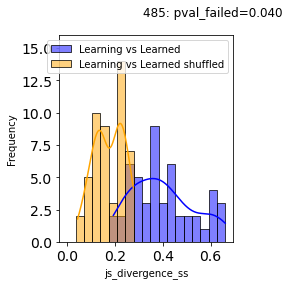

In [26]:
# Plot histograms and KDE plots
plt.figure(figsize=(6, 4))
# Define the bins for both histograms
bins = np.linspace(0, max(max(js_divergence_ss['Learning_vs_Learned_Failed']), max(js_divergence_ss['Learning_vs_Learned_Failed_sh'])), 20)
# Determine the maximum y limit for both plots
max_y = max(
    max(np.histogram(js_divergence_ss['Learning_vs_Learned_Failed'], bins=bins)[0]),
    max(np.histogram(js_divergence_ss['Learning_vs_Learned_Failed_sh'], bins=bins)[0])
)+2

plt.subplot(1, 2, 1)
sns.histplot(js_divergence_ss['Learning_vs_Learned_Failed'], bins=bins, kde=True, color='blue', label='Learning vs Learned')
#plt.title('js_divergence_ss: Learning vs Learned')
plt.xlabel('js_divergence_ss')
plt.ylabel('Frequency')
plt.legend()
plt.ylim(0, max_y)

#plt.subplot(1, 2, 2)
sns.histplot(js_divergence_ss['Learning_vs_Learned_Failed_sh'], bins=bins, kde=True, color='orange', label='Learning vs Learned shuffled')
#plt.title('js_divergence_ss: Learned vs Learning')
plt.xlabel('js_divergence_ss')
plt.ylabel('Frequency')
plt.ylim
plt.legend()
plt.ylim(0, max_y)

plt.suptitle(fol1+ ': '+f'pval_failed={p_value_failed_js_:.3f}')
plt.tight_layout()
plt.show()

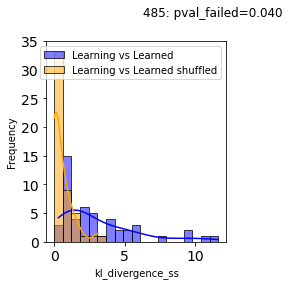

In [27]:
# Plot histograms and KDE plots
plt.figure(figsize=(6, 4))
# Define the bins for both histograms
bins = np.linspace(0, max(max(kl_divergence_ss['Learning_vs_Learned_Failed']), max(kl_divergence_ss['Learning_vs_Learned_Failed_sh'])), 20)
# Determine the maximum y limit for both plots
max_y = max(
    max(np.histogram(kl_divergence_ss['Learning_vs_Learned_Failed'], bins=bins)[0]),
    max(np.histogram(kl_divergence_ss['Learning_vs_Learned_Failed_sh'], bins=bins)[0])
)+2

plt.subplot(1, 2, 1)
sns.histplot(kl_divergence_ss['Learning_vs_Learned_Failed'], bins=bins, kde=True, color='blue', label='Learning vs Learned')
#plt.title('js_divergence_ss: Learning vs Learned')
plt.xlabel('kl_divergence_ss')
plt.ylabel('Frequency')
plt.legend()
plt.ylim(0, max_y)

#plt.subplot(1, 2, 2)
sns.histplot(kl_divergence_ss['Learning_vs_Learned_Failed_sh'], bins=bins, kde=True, color='orange', label='Learning vs Learned shuffled')
#plt.title('js_divergence_ss: Learned vs Learning')
plt.xlabel('kl_divergence_ss')
plt.ylabel('Frequency')
plt.ylim
plt.legend()
plt.ylim(0, max_y)

plt.suptitle(fol1+ ': '+f'pval_failed={p_value_failed_js_:.3f}')
plt.tight_layout()
plt.show()

In [97]:
conds=['sampling_L',
 'sampling_R',
 'outward_L',
 'outward_R',
 'reward_L',
 'reward_R',
 'inward_L',
 'inward_R']


cond_number = dict(zip(conds, np.arange(len(conds))))# make mask values for each task
cond_names=cond_number

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def plot_kl_distributions_ss(js_divergence_ss, p_value_corr_js_, name, type='Correct'):
    plt.figure(figsize=(8, 4))

    # Define the bins for both histograms
    bins = np.linspace(0, max(max(js_divergence_ss[type]), max(js_divergence_ss[type + '_sh'])), 20)
    
    # Determine the maximum y limit for both plots
    max_y = max(
        max(np.histogram(js_divergence_ss[type], bins=bins)[0]),
        max(np.histogram(js_divergence_ss[type + '_sh'], bins=bins)[0])
    ) + 2

    # First subplot for the original distribution
    plt.subplot(1, 2, 1)
    sns.histplot(js_divergence_ss[type], bins=bins, kde=True, color='#1f77b4', edgecolor='black', 
                 line_kws={'lw': 2}, label='Original')
    plt.title(name[:-2], fontsize=14)
    plt.xlabel(name[-2:], fontsize=12)
    plt.ylabel('Frequency', fontsize=12)
    plt.legend(fontsize=10, frameon=False)
    plt.ylim(0, max_y)
    
    # Add p-value text inside the first plot
    plt.text(0.7, 0.8, f'p = {p_value_corr_js_:.3f}', ha='center', va='center',
             transform=plt.gca().transAxes, fontsize=12, color='black')

    # Second subplot for the shuffled distribution
    sns.histplot(js_divergence_ss[type + '_sh'], bins=bins, kde=True, color='gray', edgecolor='black',
                 line_kws={'lw': 2}, label='Shuffled')
    plt.xlabel(name[-2:], fontsize=12)
    plt.ylabel('Occurrence', fontsize=12)
    plt.legend(fontsize=10, loc='upper right', frameon=False)
    plt.ylim(0, max_y)

    # Overall adjustments for a cleaner look
    plt.tight_layout()
    plt.show()


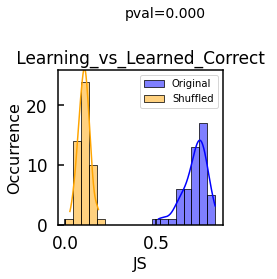

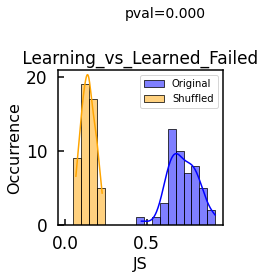

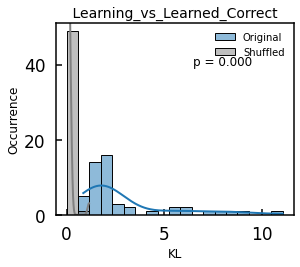

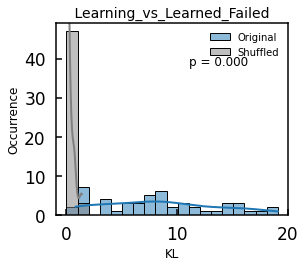

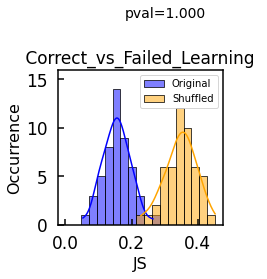

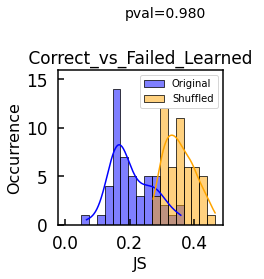

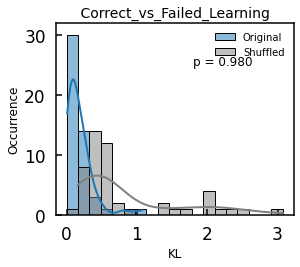

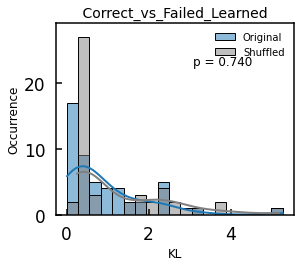

In [107]:
#Visualize sampling cluster distributions
animallist=['478','481','483','485']
animallist=['478']

import copy
import random
from scipy.spatial.distance import jensenshannon
from scipy.stats import entropy
cond='sampling'#+animallist[0]
sampling_clusters={}
sampling_clusters_shuffled={}

subsampling_restults={}
subsampling_restults_shuffled={}
# Get cluster distribution  of sampling period
ss_nbr=1
phases={'Learning':0,'Learned':1}
corr_failed={'Failed':0,'Correct':1}
js_divergence_ss={'Learning_vs_Learned_Correct':[],'Learning_vs_Learned_Correct_sh':[],'Learned_vs_Learning_Correct':[],'Learning_vs_Learned_Failed':[],'Learning_vs_Learned_Failed_sh':[],'Learned_vs_Learning_Failed':[]
                  ,'Correct_vs_Failed_Learning':[],'Correct_vs_Failed_Learning_sh':[],'Correct_vs_Failed_Learned':[],'Correct_vs_Failed_Learned_sh':[]}
kl_divergence_ss={'Learning_vs_Learned_Correct':[],'Learning_vs_Learned_Correct_sh':[],'Learned_vs_Learning_Correct':[],'Learning_vs_Learned_Failed':[],'Learning_vs_Learned_Failed_sh':[],'Learned_vs_Learning_Failed':[],
                  'Correct_vs_Failed_Learning':[],'Correct_vs_Failed_Learning_sh':[],'Correct_vs_Failed_Learned':[],'Correct_vs_Failed_Learned_sh':[]}
plt.rcParams['axes.titlesize'] = 17  # Set the title font size
plt.rcParams.update({'font.size': 10})
plt.rcParams['axes.titlesize'] = 17
plt.rcParams['xtick.labelsize'] = 17  # You can adjust the font size as needed
plt.rcParams['ytick.labelsize'] = 17 # You can adjust the font size as needed
plt.rcParams.update({'font.size': 16})

for fol1 in animallist:
        
    #ss_data_info=np.load(savefolder+fol1+'Entropy_subsampling_modified'+ '_'+place_cell_name+'_'+cell_types+'_'+descriotor+'.pkl',allow_pickle=True)
    ss_data_info=np.load(savefolder+fol1+'Entropy_subsampling_3'+ '_'+place_cell_name+'_'+cell_types+'_'+descriotor+'.pkl',allow_pickle=True)




    for ss_nbr in range(len(ss_data_info)):

        for phase in phases.keys():
            phase_nbr=phases[phase]
            for cf in corr_failed.keys():
                corr_failed_nbr=corr_failed[cf]

                org_laels=ss_data_info[ss_nbr]['new_phase_mask']
                shuffled_labels=copy.copy(org_laels)
                random.shuffle(shuffled_labels)# shuffle learning and learned labels


                cond_lbl= [cond_names[cond_name] for cond_name in cond_names if cond in cond_name]
                #sampling_mask = (ss_data_info[ss_nbr]['new_cond_mask']==1) | (ss_data_info[ss_nbr]['new_cond_mask']==0)
                sampling_mask = (ss_data_info[ss_nbr]['new_cond_mask']==cond_lbl[0]) | (ss_data_info[ss_nbr]['new_cond_mask']==cond_lbl[1])


                learned_mask = (org_laels==phase_nbr) 
                correct_mask = (ss_data_info[ss_nbr]['new_correct_failed_mask']==corr_failed_nbr) 
                

                mask_sampling_correct_learned=correct_mask & learned_mask & sampling_mask

                sampling_clusters[phase+'_'+cf]=np.asarray(ss_data_info[ss_nbr]['ids_clust'][0])[mask_sampling_correct_learned]

                labels, counts = np.unique(ss_data_info[ss_nbr]['ids_clust'][0][mask_sampling_correct_learned], return_counts=True)
                subsampling_restults[phase+'_'+cf]= {'seq_len':len(ss_data_info[ss_nbr]['ids_clust'][0][mask_sampling_correct_learned]),
                                                                                            'cluster_number': labels, 'clsuster_counts':counts}


                learned_mask_sh = (shuffled_labels==phase_nbr) 

                mask_sampling_correct_learned_sh=correct_mask & learned_mask_sh & sampling_mask

                sampling_clusters_shuffled[phase+'_'+cf]=np.asarray(ss_data_info[ss_nbr]['ids_clust'][0])[mask_sampling_correct_learned_sh]

                labels, counts = np.unique(ss_data_info[ss_nbr]['ids_clust'][0][mask_sampling_correct_learned_sh], return_counts=True)
                subsampling_restults_shuffled[phase+'_'+cf]= {'seq_len':len(ss_data_info[ss_nbr]['ids_clust'][0][mask_sampling_correct_learned_sh]),
                                                                                            'cluster_number': labels, 'clsuster_counts':counts}
                


        js_divergence, kl_divergence = mot.calculate_divergences(subsampling_restults['Learning_Correct'], subsampling_restults['Learning_Failed'])
        js_divergence_ss['Correct_vs_Failed_Learning'].append(js_divergence)
        kl_divergence_ss['Correct_vs_Failed_Learning'].append(kl_divergence)
        js_divergence_sh, kl_divergence_sh = mot.calculate_divergences(subsampling_restults_shuffled['Learning_Correct'], subsampling_restults_shuffled['Learning_Failed'])
        js_divergence_ss['Correct_vs_Failed_Learning_sh'].append(js_divergence_sh)
        kl_divergence_ss['Correct_vs_Failed_Learning_sh'].append(kl_divergence_sh)

        js_divergence, kl_divergence = mot.calculate_divergences(subsampling_restults['Learned_Correct'], subsampling_restults['Learned_Failed'])
        js_divergence_ss['Correct_vs_Failed_Learned'].append(js_divergence)
        kl_divergence_ss['Correct_vs_Failed_Learned'].append(kl_divergence)
        js_divergence, kl_divergence = mot.calculate_divergences(subsampling_restults_shuffled['Learned_Correct'], subsampling_restults_shuffled['Learned_Failed'])
        js_divergence_ss['Correct_vs_Failed_Learned_sh'].append(js_divergence)
        kl_divergence_ss['Correct_vs_Failed_Learned_sh'].append(kl_divergence)



        js_divergence, kl_divergence = mot.calculate_divergences(subsampling_restults['Learning_Correct'], subsampling_restults['Learned_Correct'])
        js_divergence_ss['Learning_vs_Learned_Correct'].append(js_divergence)
        kl_divergence_ss['Learning_vs_Learned_Correct'].append(kl_divergence)
        js_divergence_sh, kl_divergence_sh = mot.calculate_divergences(subsampling_restults_shuffled['Learning_Correct'], subsampling_restults_shuffled['Learned_Correct'])
        js_divergence_ss['Learning_vs_Learned_Correct_sh'].append(js_divergence_sh)
        kl_divergence_ss['Learning_vs_Learned_Correct_sh'].append(kl_divergence_sh)

        js_divergence, kl_divergence = mot.calculate_divergences(subsampling_restults['Learning_Failed'], subsampling_restults['Learned_Failed'])
        js_divergence_ss['Learning_vs_Learned_Failed'].append(js_divergence)
        kl_divergence_ss['Learning_vs_Learned_Failed'].append(kl_divergence)
        js_divergence, kl_divergence = mot.calculate_divergences(subsampling_restults_shuffled['Learning_Failed'], subsampling_restults_shuffled['Learned_Failed'])
        js_divergence_ss['Learning_vs_Learned_Failed_sh'].append(js_divergence)
        kl_divergence_ss['Learning_vs_Learned_Failed_sh'].append(kl_divergence)


        # js_divergence, kl_divergence = calculate_divergences(subsampling_restults['Learning_Failed'], subsampling_restults['Learning_Correct'])
        # js_divergence_ss['Correct_vs_Failed_Learning'].append(js_divergence)
        # kl_divergence_ss['Correct_vs_Failed_Learning'].append(kl_divergence)
        # js_divergence_sh, kl_divergence_sh = calculate_divergences(subsampling_restults_shuffled['Learning_Failed'], subsampling_restults_shuffled['Learning_Correct'])
        # js_divergence_ss['Correct_vs_Failed_Learning_sh'].append(js_divergence_sh)
        # kl_divergence_ss['Correct_vs_Failed_Learning_sh'].append(kl_divergence_sh)

        # js_divergence, kl_divergence = calculate_divergences(subsampling_restults['Learned_Correct'], subsampling_restults['Learned_Failed'])
        # js_divergence_ss['Correct_vs_Failed_Learned'].append(js_divergence)
        # kl_divergence_ss['Correct_vs_Failed_Learned'].append(kl_divergence)
        # js_divergence, kl_divergence = calculate_divergences(subsampling_restults_shuffled['Learned_Correct'], subsampling_restults_shuffled['Learned_Failed'])
        # js_divergence_ss['Correct_vs_Failed_Learned_sh'].append(js_divergence)
        # kl_divergence_ss['Correct_vs_Failed_Learned_sh'].append(kl_divergence)



        # js_divergence, kl_divergence = calculate_divergences(subsampling_restults['Learned_Correct'], subsampling_restults['Learning_Correct'])
        # js_divergence_ss['Learning_vs_Learned_Correct'].append(js_divergence)
        # kl_divergence_ss['Learning_vs_Learned_Correct'].append(kl_divergence)
        # js_divergence_sh, kl_divergence_sh = calculate_divergences(subsampling_restults_shuffled['Learned_Correct'], subsampling_restults_shuffled['Learning_Correct'])
        # js_divergence_ss['Learning_vs_Learned_Correct_sh'].append(js_divergence_sh)
        # kl_divergence_ss['Learning_vs_Learned_Correct_sh'].append(kl_divergence_sh)

        # js_divergence, kl_divergence = calculate_divergences(subsampling_restults['Learned_Failed'], subsampling_restults['Learning_Failed'])
        # js_divergence_ss['Learning_vs_Learned_Failed'].append(js_divergence)
        # kl_divergence_ss['Learning_vs_Learned_Failed'].append(kl_divergence)
        # js_divergence, kl_divergence = calculate_divergences(subsampling_restults_shuffled['Learned_Failed'], subsampling_restults_shuffled['Learning_Failed'])
        # js_divergence_ss['Learning_vs_Learned_Failed_sh'].append(js_divergence)
        # kl_divergence_ss['Learning_vs_Learned_Failed_sh'].append(kl_divergence)









p_value_corr_kl_= mot.get_pval(kl_divergence_ss['Learning_vs_Learned_Correct'],kl_divergence_ss['Learning_vs_Learned_Correct_sh'])
p_value_failed_kl_= mot.get_pval(kl_divergence_ss['Learning_vs_Learned_Failed'],kl_divergence_ss['Learning_vs_Learned_Failed_sh'])

p_value_corr_js_= mot.get_pval(js_divergence_ss['Learning_vs_Learned_Correct'],js_divergence_ss['Learning_vs_Learned_Correct_sh'])
p_value_failed_js_= mot.get_pval(js_divergence_ss['Learning_vs_Learned_Failed'],js_divergence_ss['Learning_vs_Learned_Failed_sh'])



fol1=''

p_value_learning_kl_= mot.get_pval(kl_divergence_ss['Correct_vs_Failed_Learning'],kl_divergence_ss['Correct_vs_Failed_Learning_sh'])
p_value_learned_kl_= mot.get_pval(kl_divergence_ss['Correct_vs_Failed_Learned'],kl_divergence_ss['Correct_vs_Failed_Learned_sh'])

p_value_learning_js_= mot.get_pval(js_divergence_ss['Correct_vs_Failed_Learning'],js_divergence_ss['Correct_vs_Failed_Learning_sh'])
p_value_learned_js_= mot.get_pval(js_divergence_ss['Correct_vs_Failed_Learned'],js_divergence_ss['Correct_vs_Failed_Learned_sh'])



  
mot.plot_kl_distributions_ss(js_divergence_ss,p_value_corr_js_,name=' Learning_vs_Learned_Correct'+' JS',type='Learning_vs_Learned_Correct')
mot.plot_kl_distributions_ss(js_divergence_ss,p_value_failed_js_,name=' Learning_vs_Learned_Failed'+' JS',type='Learning_vs_Learned_Failed')

plot_kl_distributions_ss(kl_divergence_ss,p_value_corr_kl_,name=' Learning_vs_Learned_Correct'+' KL',type='Learning_vs_Learned_Correct')
plot_kl_distributions_ss(kl_divergence_ss,p_value_failed_kl_,name=' Learning_vs_Learned_Failed'+' KL',type='Learning_vs_Learned_Failed')



  
mot.plot_kl_distributions_ss(js_divergence_ss,p_value_learning_js_,name=' Correct_vs_Failed_Learning'+' JS',type='Correct_vs_Failed_Learning')
mot.plot_kl_distributions_ss(js_divergence_ss,p_value_learned_js_,name=' Correct_vs_Failed_Learned'+' JS',type='Correct_vs_Failed_Learned')

plot_kl_distributions_ss(kl_divergence_ss,p_value_learning_kl_,name=' Correct_vs_Failed_Learning'+' KL',type='Correct_vs_Failed_Learning')
plot_kl_distributions_ss(kl_divergence_ss,p_value_learned_kl_,name=' Correct_vs_Failed_Learned'+' KL',type='Correct_vs_Failed_Learned')

In [84]:
mot.calculate_shannon_entropy(subsampling_restults[key])

1.3674632199510353

In [16]:
max_clusters=[]
for ax, (key, values) in zip(axes, sampling_clusters.items()):
    max_clusters.append(np.max([np.max(x) for x in subsampling_restults[key]['cluster_number']]))
    max_cluster_nbr=np.max(max_clusters)


NameError: name 'axes' is not defined

In [44]:
(subsampling_restults.keys())

dict_keys(['Learning_Failed', 'Learning_Correct', 'Learned_Failed', 'Learned_Correct'])

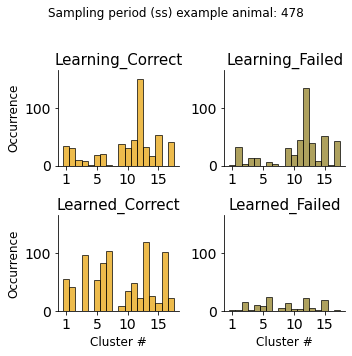

In [25]:
# Visualize sampling cluster distributions
fol1='478'
#ss_data_info=np.load(savefolder+fol1+'Entropy_subsampling_modified'+ '_'+place_cell_name+'_'+cell_types+'_'+descriotor+'.pkl',allow_pickle=True)
ss_data_info=np.load(savefolder+fol1+'Entropy_subsampling_3'+ '_'+place_cell_name+'_'+cell_types+'_'+descriotor+'.pkl',allow_pickle=True)


sampling_clusters={}
subsampling_restults={}
# Get cluster distribution  of sampling period
ss_nbr=4
phases={'Learning':0,'Learned':1}
corr_failed={'Correct':1,'Failed':0,}

for phase in phases.keys():
    phase_nbr=phases[phase]
    for cf in corr_failed.keys():
        corr_failed_nbr=corr_failed[cf]


        sampling_mask = (ss_data_info[ss_nbr]['new_cond_mask']==1) | (ss_data_info[0]['new_cond_mask']==0)
        learned_mask = (ss_data_info[ss_nbr]['new_phase_mask']==phase_nbr) 
        correct_mask = (ss_data_info[ss_nbr]['new_correct_failed_mask']==corr_failed_nbr) 
        

        mask_sampling_correct_learned=correct_mask & learned_mask #& sampling_mask

        sampling_clusters[phase+'_'+cf]=np.asarray(ss_data_info[ss_nbr]['ids_clust'][0])[mask_sampling_correct_learned]

        labels, counts = np.unique(ss_data_info[ss_nbr]['ids_clust'][0][mask_sampling_correct_learned], return_counts=True)
        subsampling_restults[phase+'_'+cf]= {'seq_len':len(ss_data_info[ss_nbr]['ids_clust'][0][mask_sampling_correct_learned]),
                                                                                    'cluster_number': labels, 'clsuster_counts':counts}
# # Create a 2x2 grid of subplots
# fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(5, 5))
# axes = axes.flatten()  # Flatten the 2D array of axes to 1D for easy iteration

# max_clusters=[]
# for ax, (key, values) in zip(axes, sampling_clusters.items()):
#     max_clusters.append(np.max([np.max(x) for x in subsampling_restults[key]['cluster_number']]))
#     max_cluster_nbr=np.max(max_clusters)

# # Plotting histograms
# for ax, (key, values) in zip(axes, sampling_clusters.items()):
#     color='skyblue'
#     if 'Failed' in key:
#         color='red'

#     ax.hist(values,bins=max_cluster_nbr,edgecolor='k', color=color, alpha=0.7)  # Adjust bins as needed
#     ent=mot.calculate_shannon_entropy(subsampling_restults[key])
    
#     #ax.text(12,15,'Ent = ' +f'{ent: .2f}')
#     ax.set_ylim([0,250])
#     ax.set_title(key)
#     ax.set_xlabel('Cluster #')
#     ax.set_ylabel('Occurrence')
# plt.suptitle('Sampling period (ss) example animal: '+fol1)
# # Adjust layout to prevent overlap
# plt.tight_layout()
# plt.show()




# Parameters
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(5, 5))
axes = axes.flatten()  # Flatten for easy iteration

max_clusters = []
for key, values in sampling_clusters.items():
    max_clusters.append(np.max(subsampling_restults[key]['cluster_number']))
max_cluster_nbr = np.max(max_clusters)

# Publication-friendly colors
correct_color = '#E69F00'  # Orange
failed_color = '#8C7A1A'   # Olive

# Determine the maximum y-limit based on all subplots
max_count = 0  # Initialize maximum count

# First pass: find the maximum y-value across all histograms
for key, values in sampling_clusters.items():
    counts, bins = np.histogram(values, bins=max_cluster_nbr)
    max_count = max(max_count, counts.max())  # Update max_count if current histogram has higher counts

# Second pass: plot each histogram with uniform y-limit
for i, (ax, (key, values)) in enumerate(zip(axes, sampling_clusters.items())):
    color = correct_color if 'Correct' in key else failed_color
    
    # Histogram plotting
    counts, bins, patches = ax.hist(values, bins=max_cluster_nbr, edgecolor='k', color=color, alpha=0.7)
    
    # Calculate bin centers for the x-ticks
    # Calculate bin centers for the x-ticks
    bin_centers = (bins[:-1] + bins[1:]) / 2

    # Set x-ticks to every 5th bin center
    every_5th_bin_center = bin_centers[::5]  # Every 5th bin center
    # Generate labels starting from 1, incrementing by 5
    xtick_labels = [str(i * 5 ) for i in range(len(every_5th_bin_center))]
    xtick_labels[0]='1'
    # Set x-ticks and x-tick labels
    ax.set_xticks(every_5th_bin_center)
    ax.set_xticklabels(xtick_labels)  # Should display as 1, 5, 10, 15, ...
    # Apply uniform y-limit based on the maximum count
    ax.set_ylim(0, max_count * 1.1)  # Add 10% padding to the y-limit

    # Remove top and right spines for a cleaner look
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    # Label "Cluster #" on x-axis only for bottom row
    if i >= 2:  # Bottom row
        ax.set_xlabel('Cluster #', fontsize=12)

    if np.mod(i, 2) == 0:  # Every other plot for y-axis label
        ax.set_ylabel('Occurrence', fontsize=12)
    
    # Title
    ax.set_title(key)

# Global title and layout adjustment
plt.suptitle('Sampling period (ss) example animal: ' + fol1)
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust to leave space for suptitle
plt.savefig(savefolder + 'sample_distributions.svg', dpi=300)
plt.show()



In [78]:
plt.rcParams['svg.fonttype'] = 'none'  # Export text as SVG <text> objects, not paths

mpl.rcParams['xtick.major.size'] = 6    # Length of major ticks on x-axis
mpl.rcParams['xtick.major.width'] = 1.5 # Width of major ticks on x-axis
mpl.rcParams['xtick.direction'] = 'in' # Tick direction, both in and out
mpl.rcParams['xtick.major.pad'] = 10    # Padding between ticks and x-axis labels

mpl.rcParams['ytick.major.size'] = 6    # Length of major ticks on y-axis
mpl.rcParams['ytick.major.width'] = 1.5 # Width of major ticks on y-axis
mpl.rcParams['ytick.direction'] = 'in' # Tick direction, both in and out
mpl.rcParams['ytick.major.pad'] = 10    # Padding between ticks and y-axis labels


# Set default spine and tick settings globally for all plots
mpl.rcParams['axes.linewidth'] = 1.5     # Set the width of all spines (top, bottom, left, right)
mpl.rcParams['xtick.major.width'] = 1.5  # Width of major ticks on x-axis
mpl.rcParams['ytick.major.width'] = 1.5  # Width of major ticks on y-axis
mpl.rcParams['xtick.labelsize'] = 12     # Font size of x-axis tick labels
mpl.rcParams['ytick.labelsize'] = 12     # Font size of y-axis tick labels

# Define the helper function to hide spines
def hide_spines(ax=None):
    if ax is None:
        ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

In [90]:
bin_centers

array([ 1.47222222,  2.41666667,  3.36111111,  4.30555556,  5.25      ,
        6.19444444,  7.13888889,  8.08333333,  9.02777778,  9.97222222,
       10.91666667, 11.86111111, 12.80555556, 13.75      , 14.69444444,
       15.63888889, 16.58333333, 17.52777778])

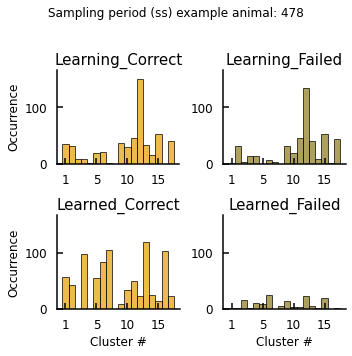

In [ ]:

# Parameters
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(5, 5))
axes = axes.flatten()  # Flatten for easy iteration

max_clusters = []
for key, values in sampling_clusters.items():
    max_clusters.append(np.max(subsampling_restults[key]['cluster_number']))
max_cluster_nbr = np.max(max_clusters)

# Publication-friendly colors
correct_color = '#E69F00'  # Orange
failed_color = '#8C7A1A'   # Olive

# Determine the maximum y-limit based on all subplots
max_count = 0  # Initialize maximum count

# First pass: find the maximum y-value across all histograms
for key, values in sampling_clusters.items():
    counts, bins = np.histogram(values, bins=max_cluster_nbr)
    max_count = max(max_count, counts.max())  # Update max_count if current histogram has higher counts

# Second pass: plot each histogram with uniform y-limit
for i, (ax, (key, values)) in enumerate(zip(axes, sampling_clusters.items())):
    color = correct_color if 'Correct' in key else failed_color
    
    # Histogram plotting
    counts, bins, patches = ax.hist(values, bins=max_cluster_nbr, edgecolor='k', color=color, alpha=0.7)
    
    # Calculate bin centers for the x-ticks
    # Calculate bin centers for the x-ticks
    bin_centers = (bins[:-1] + bins[1:]) / 2

    # Set x-ticks to every 5th bin center
    every_5th_bin_center = bin_centers[::5]  # Every 5th bin center
    # Generate labels starting from 1, incrementing by 5
    xtick_labels = [str(i * 5 ) for i in range(len(every_5th_bin_center))]
    xtick_labels[0]='1'
    # Set x-ticks and x-tick labels
    ax.set_xticks(every_5th_bin_center)
    ax.set_xticklabels(xtick_labels)  # Should display as 1, 5, 10, 15, ...
    # Apply uniform y-limit based on the maximum count
    ax.set_ylim(0, max_count * 1.1)  # Add 10% padding to the y-limit

    # Remove top and right spines for a cleaner look
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    # Label "Cluster #" on x-axis only for bottom row
    if i >= 2:  # Bottom row
        ax.set_xlabel('Cluster #', fontsize=12)

    if np.mod(i, 2) == 0:  # Every other plot for y-axis label
        ax.set_ylabel('Occurrence', fontsize=12)
    
    # Title
    ax.set_title(key)

# Global title and layout adjustment
plt.suptitle('Sampling period (ss) example animal: ' + fol1)
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust to leave space for suptitle
plt.savefig(savefolder + 'sample_distributions.svg', dpi=300)
plt.show()


In [23]:

cond_numbers={}
cond_numbers['outward']=[2,3] # conditon name (outwards)
cond_numbers['inward']=[6,7] # inwards
cond_numbers['sampling']=[0,1] # sampling
cond_numbers['reward'] =[4,5] # reward

Entropy_subsamplings={}
for ss in range(len(temp_info_subsampling)):# subsampling for entropy

    entropy={'correct':{},'failed':{}}

    for trial_type in range(2):
        fr_trial={}
        
        #sessin_numbers=np.arange(len(session_mask))


        if trial_type==1:
            typename='correct'
        elif trial_type==0:
            typename='failed'


        for phase_name in range(2):
            if phase_name==1:
                phname='learned'
            elif phase_name==0:
                phname='learning'



# temp_info_subsampling[1]['new_cond_mask']=new_cond_mask
# temp_info_subsampling[1]['new_phase_mask']=new_phase_mask
# temp_info_subsampling[1]['new_correct_failed_mask']=new_correct_failed_mask

            for cond_number_name in cond_numbers.keys():
                ampling_mask_cond=np.zeros_like(temp_info_subsampling[ss]['new_cond_mask'])
                for ii in cond_numbers[cond_number_name]:
                    ampling_mask_cond+=temp_info_subsampling[ss]['new_cond_mask']==ii# task epochs: samplng, reward, ...
                l_mask=temp_info_subsampling[ss]['new_phase_mask']==phase_name# learning or learned sequences
                c_mask=temp_info_subsampling[ss]['new_correct_failed_mask']==trial_type# correct or fialed sequences

                final_mask=((c_mask) & (l_mask) & (ampling_mask_cond.astype(bool)) )
                labels, counts = np.unique(temp_info_subsampling[ss]['ids_clust'][0][final_mask], return_counts=True)
                


                subsampling_restults['cluster_dist'][phname+'_'+cond_number_name] = {'seq_len':len(temp_info_subsampling[ss]['ids_clust'][0][final_mask]),
                                                                            'cluster_number': labels, 'clsuster_counts':counts}

        # compute diversity index for different qs
        Div_idxq={}

        for epochs in subsampling_restults['cluster_dist'].keys():
            clstr_data=subsampling_restults['cluster_dist'][epochs]
            diq=[]
            xq=np.arange(0.011,5.51,.1)
            xq[0]=0
            for q in (xq):
                
                diq.append( mot.calculate_diversity_q(clstr_data,q))
            
            Div_idxq[epochs]=diq
            #entropy[typename][epochs]=Div_idxq[epochs][1]
            entropy[typename][epochs]=mot.calculate_shannon_entropy(clstr_data)
    Entropy_subsamplings[ss]=entropy# entropy fo all saubsamplings

In [24]:
phase=1
# trial_type=1
odd_even=None

smooth_speed=mot.smooth_signal(sess_info['speed'], 13)# moving average over .5  second
Masks['speed_seq']=np.asarray(smooth_speed)[sess_info['id_peaks']]>speed_thr
Masks['speed']=smooth_speed>speed_thr


session_mask={'20220215_gcamp6f485_task_learning.mat': 0,
 '20220217_gcamp6f485_task_learning.mat': 1,
 '20220218_gcamp6f485_task_learning.mat': 2,
 '20220307_gcamp6f485_task_learned.mat': 3,
 '20220308_gcamp6f485_task_learned.mat': 4,
 '20220309_gcamp6f485_task_learned.mat': 5,
 '20220310_gcamp6f485_task_learned.mat': 6,
 '20220316_gcamp6f485_task_learned.mat': 7}
cond_numbers={}
cond_numbers['outward']=[2,3] # conditon name (outwards)
cond_numbers['inward']=[6,7] # inwards
cond_numbers['sampling']=[0,1] # sampling
cond_numbers['reward'] =[4,5] # reward

# cond_number='reward'

sessin_numbers=np.arange(len(session_mask))
if trial_type==1:
    type_name='Correct'
elif trial_type==0:
    type_name='Failed'

conds=['sampling_L',
 'sampling_R',
 'outward_L',
 'outward_R',
 'reward_L',
 'reward_R',
 'inward_L',
 'inward_R']


cond_names = dict(zip(conds, np.arange(len(conds))))# make mask values for each task


if phase==None:
    phase_name='All'
elif phase==0:
    phase_name='Learning'
    color='blue'
elif phase==1:
    phase_name='Learned'
    color='red'
cond_number='sampling'
run_data_all = mot.apply_masks_test(sess_info,Masks,cond_numbers[cond_number],cond_names,sessin_numbers,odd_even,session_mask,trial_type,phase)


NameError: name 'trial_type' is not defined

In [72]:
def generate_hex_colors(n):
    
    color_list = []
    for _ in range(n):
        color = "#{:06x}".format(random.randint(0, 0xFFFFFF))
        if color in color_list:
            continue
        color_list.append(color)

    return color_list



colorlist = generate_hex_colors(np.max(sess_info['ids_clust'])+2)

n_clusters=np.max(sess_info['ids_clust'])+1

In [27]:
import matplotlib.pyplot as plt
import numpy as np

def get_distinguishable_colors(n):
    base_colors = [
        "#FF5733", # Red
        "#33FF57", # Green
        "#3357FF", # Blue
        "#FFD700", # Yellow
        "#FF33FF", # Magenta
        "#33FFFF", # Cyan
        "#800080", # Purple
        "#00FF00", # Lime
        "#FFA500", # Orange
        "#0000FF", # Navy
    ]

    if n <= len(base_colors):
        return base_colors[:n]
    else:
        # Interpolate between the base colors if more colors are needed
        colors = base_colors[:]
        additional_colors_needed = n - len(base_colors)
        for i in range(additional_colors_needed):
            color1 = base_colors[i % len(base_colors)]
            color2 = base_colors[(i + 1) % len(base_colors)]
            new_color = interpolate_colors(color1, color2, 0.5)
            colors.append(new_color)
        return colors

def interpolate_colors(color1, color2, factor):
    c1 = np.array([int(color1[i:i+2], 16) for i in (1, 3, 5)])
    c2 = np.array([int(color2[i:i+2], 16) for i in (1, 3, 5)])
    c_new = (c1 * (1 - factor) + c2 * factor).astype(int)
    return '#' + ''.join(f'{i:02X}' for i in c_new)

# Example usage
n = 15
colors = get_distinguishable_colors(n)
print(colors)
colorlist = get_distinguishable_colors(np.max(sess_info['ids_clust'])+2)


['#FF5733', '#33FF57', '#3357FF', '#FFD700', '#FF33FF', '#33FFFF', '#800080', '#00FF00', '#FFA500', '#0000FF', '#99AB45', '#33ABAB', '#99977F', '#FF857F', '#9999FF']


In [23]:

cond_numbers={}
cond_numbers['outward']=[2,3] # conditon name (outwards)
cond_numbers['inward']=[6,7] # inwards
cond_numbers['sampling']=[0,1] # sampling
cond_numbers['reward'] =[4,5] # reward
trial_type=1
phase=1
if trial_type==1:
    type_name='Correct'
elif trial_type==0:
    type_name='Failed'



if phase==None:
    phase_name='All'
elif phase==0:
    phase_name='Learning'
    color='blue'
elif phase==1:
    phase_name='Learned'
    color='red'



session_mask={'20220215_gcamp6f485_task_learning.mat': 0,
 '20220217_gcamp6f485_task_learning.mat': 1,
 '20220218_gcamp6f485_task_learning.mat': 2,
 '20220307_gcamp6f485_task_learned.mat': 3,
 '20220308_gcamp6f485_task_learned.mat': 4,
 '20220309_gcamp6f485_task_learned.mat': 5,
 '20220310_gcamp6f485_task_learned.mat': 6,
 '20220316_gcamp6f485_task_learned.mat': 7}
cond_numbers={}
cond_numbers['outward']=[2,3] # conditon name (outwards)
cond_numbers['inward']=[6,7] # inwards
cond_numbers['sampling']=[0,1] # sampling
cond_numbers['reward'] =[4,5] # reward

# cond_number='reward'

sessin_numbers=np.arange(len(session_mask))
if trial_type==1:
    type_name='Correct'
elif trial_type==0:
    type_name='Failed'

conds=['sampling_L',
 'sampling_R',
 'outward_L',
 'outward_R',
 'reward_L',
 'reward_R',
 'inward_L',
 'inward_R']


cond_names = dict(zip(conds, np.arange(len(conds))))# make mask values for each task
odd_even=None# all trials


In [83]:
ss

0

In [ ]:
temp_info_subsampling

In [39]:
temp_info_subsampling[0].keys()

dict_keys(['adj', 'template', 'clist', 'radius', 'seqs', 'ids_clust', 'bursts', 'ratio', 'exclude', 'new_cond_mask', 'new_phase_mask', 'new_correct_failed_mask', 'new_id_peaks', 'speed_seq_new', 'new_bursts_sess'])

IndexError: boolean index did not match indexed array along dimension 0; dimension is 1 but corresponding boolean dimension is 1950

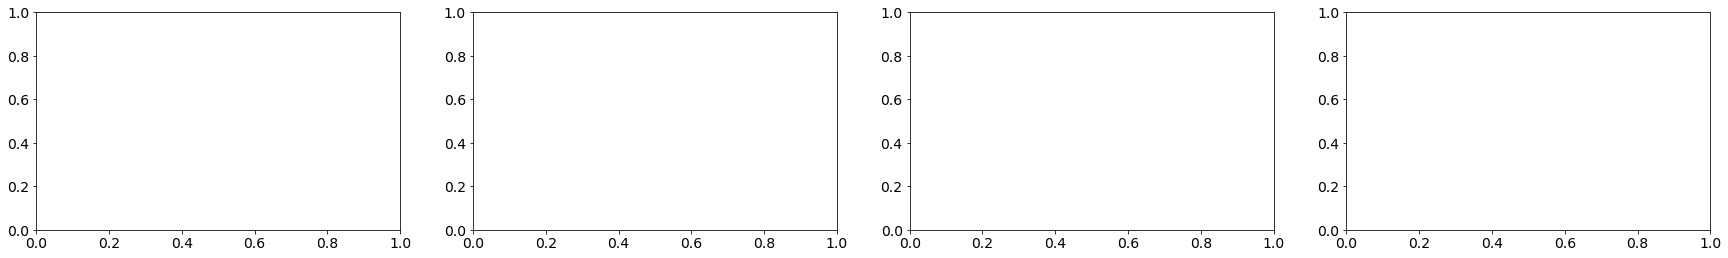

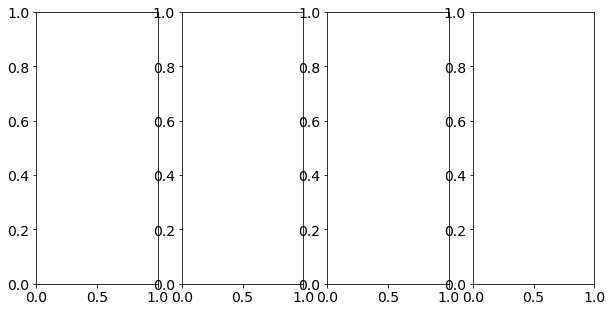

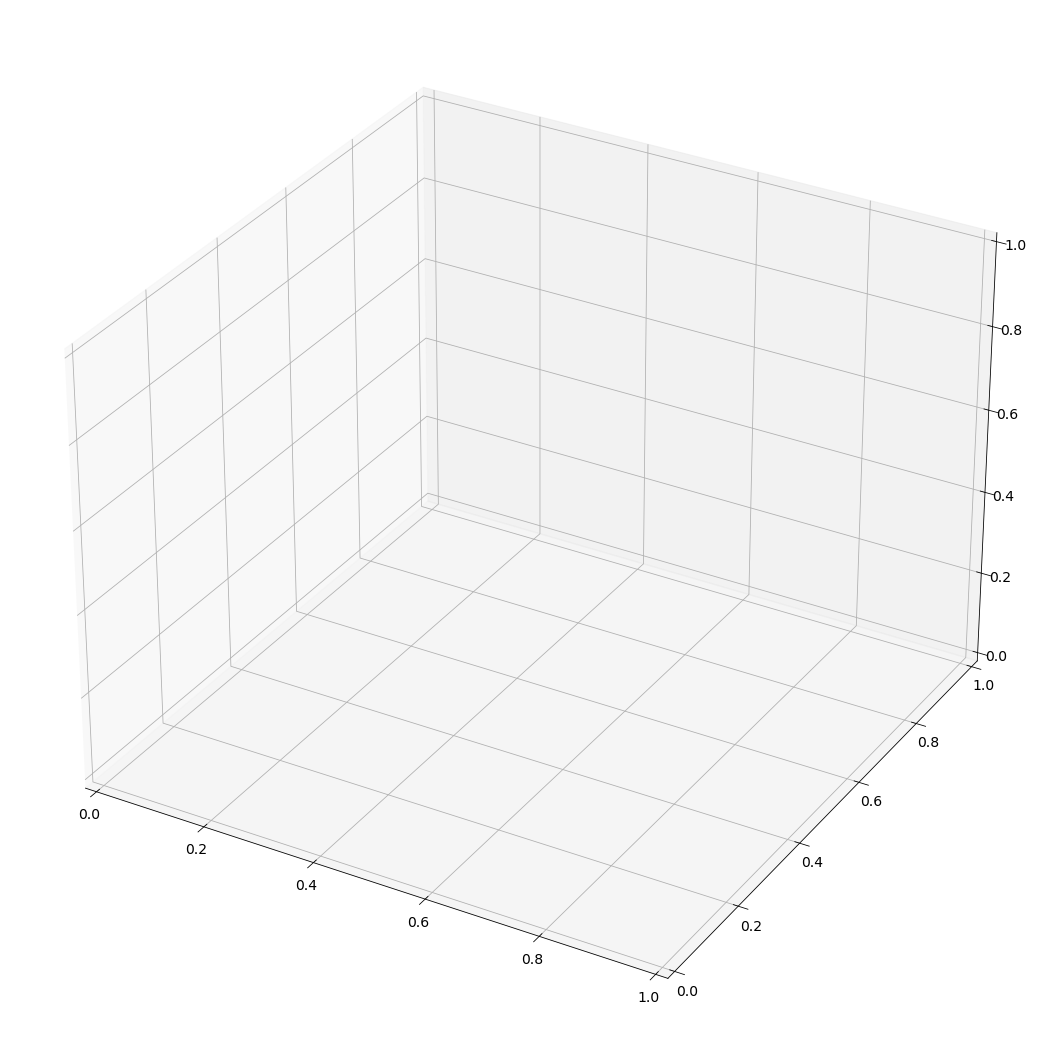

In [24]:
#viridis_cmap = plt.get_cmap('viridis', n_clusters)
tasks=['sampling','outward','reward','inward']

plt.rcParams.update({'font.size': 19})
plt.rcParams['axes.titlesize'] = 19  # Set the title font size
plt.rcParams['xtick.labelsize'] = 14  # You can adjust the font size as needed
plt.rcParams['ytick.labelsize'] = 14  # You can adjust the font size as needed


fig2,ax2=plt.subplots(1,4,figsize=(30,4))

fig,ax=plt.subplots(1,4,figsize=(10,5))

figs=plt.figure(figsize=(60,60))
ax5s=figs.add_axes([1/len(tasks),0.1,1/len(tasks)-.01,.4],projection='3d', facecolor='white')
#figs.patch.set_facecolor('black')
cond_clst_idx={}
for icond,cond_number in enumerate(cond_numbers.keys()):

    name_cond=phase_name+' '+type_name

    if ('outward' in cond_number) | ('inward' in cond_number):
        speed_thr=0
        
    elif ('sampling' in cond_number) | ('reward' in cond_number):
        #continue
        speed_thr=0
    # add the mask for speed. speed threshold is set to 5.
    #speed_thr=0
    smooth_speed=mot.smooth_signal(sess_info['speed'], 13)# moving average over .5  second
    Masks['speed_seq']=np.asarray(smooth_speed)[sess_info['id_peaks']]>speed_thr
    Masks['speed']=smooth_speed>speed_thr


    run_data_all = mot.apply_masks_test(sess_info2,Masks2,cond_numbers[cond_number],cond_names,sessin_numbers,odd_even,session_mask,trial_type,phase)
    trial_number=len(np.unique(run_data_all['trial_idx_mask']))



    ### plot 3d animal's position+speed
    ax5s.set_title(name_cond,fontsize=58,color='black')
    X_loc_sess_peaks=(np.asarray(sess_info['xloc'])[run_data_all['idpeaks']])
    Y_loc_sess_peaks=(np.asarray(sess_info['yloc'])[run_data_all['idpeaks']])
    speed_sess_peaks=(np.asarray(sess_info['speed'])[run_data_all['idpeaks']])
    colrlst = np.asarray(colorlist)[run_data_all['ids_clust']]
    ax5s.scatter(X_loc_sess_peaks, Y_loc_sess_peaks,np.ones(len(Y_loc_sess_peaks))*speed_sess_peaks,"X",s=100,c=colrlst,alpha=.51,edgecolor='black')
    ax5s.plot(run_data_all['x_loc'],run_data_all['y_loc'], '.',color='grey',alpha=.1)
    #ax5s.plot(sess_info['xloc'],sess_info['yloc'], '.',color='grey',alpha=.009)

    ax5s.set_facecolor('w') 
    ax5s.grid(False) 
    # ax5s.w_xaxis.pane.fill = False
    # ax5s.w_yaxis.pane.fill = False
    # ax5s.w_zaxis.pane.fill = False
    ax5s.xaxis.pane.fill = False
    ax5s.yaxis.pane.fill = False
    ax5s.zaxis.pane.fill = False

    ax5s.tick_params(axis='z', colors='gray',labelsize=22)
    ax5s.view_init(elev=-90, azim=90)
    #ax5s.view_init(elev=25, azim=-45)
    #ax5s.view_init(elev=0, azim=0)


    cond_clst_idx[cond_number] = run_data_all['ids_clust']

    #customPalette = sns.set_palette(sns.color_palette(colrlst))# Use the parameter palette and use your own palette across all your
    #sns.set_palette(sns.color_palette(colorlist))
    sns.histplot(data=cond_clst_idx,y=cond_number ,kde=False,ax=ax[icond],edgecolor='black',bins=np.arange(n_clusters+2),color=color,)
    for ic in range(len(ax[icond].patches)):
        ax[icond].patches[ic].set_facecolor(colorlist[ic])





    ax[icond].text(2,-1,'trial # = ' +str(trial_number))
    #sns.histplot(cond_clst_idx[cond_number], kde=False, ax=ax[icond])
    ax[icond].set_ylim(-3, np.max(sess_info['ids_clust'])+2)
    #ax[icond].set_xlim(0, 80)
    ax[icond].set_title(f' {cond_number}'+' speed thr='+str(speed_thr),fontsize=14)
    ax[icond].set_ylabel('Cluster #',fontsize=14)
    ax[icond].set_xlabel('Sequence counts',fontsize=14)

    #plt.ylim([-1,np.max(sess_info['ids_clust'])])



    ispk=0
    for sspk in run_data_all['spike_idx_cells']:
        ax2[icond].eventplot(sspk,lineoffsets=ispk)
        ispk+=1
    ax2[icond].set_title(cond_number+'  '+fol1+' '+type_name+' '+phase_name+' '+place_cell_name+' '+cell_types)
    ax2[icond].set_ylabel('cell#')


#plt.suptitle(fol1+'_'+'all'+'_'+type_name+'_'+place_cell_name+phase_name+'_'+cell_types)
plt.tight_layout()

C:\Users\hamed\AppData\Local\Temp\ipykernel_15308\755807050.py:104: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


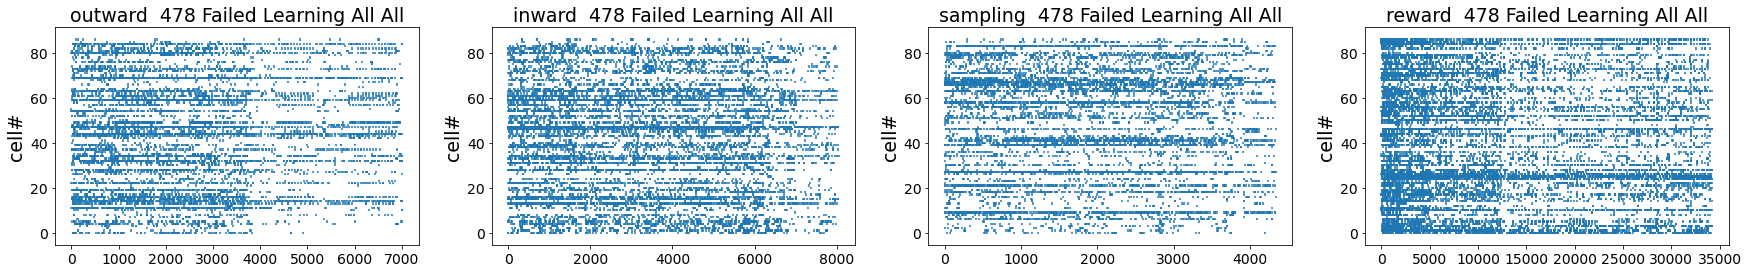

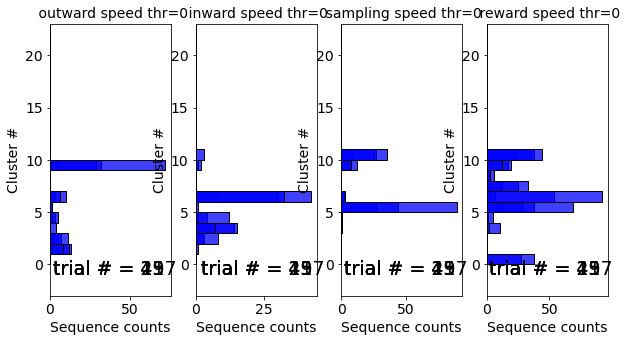

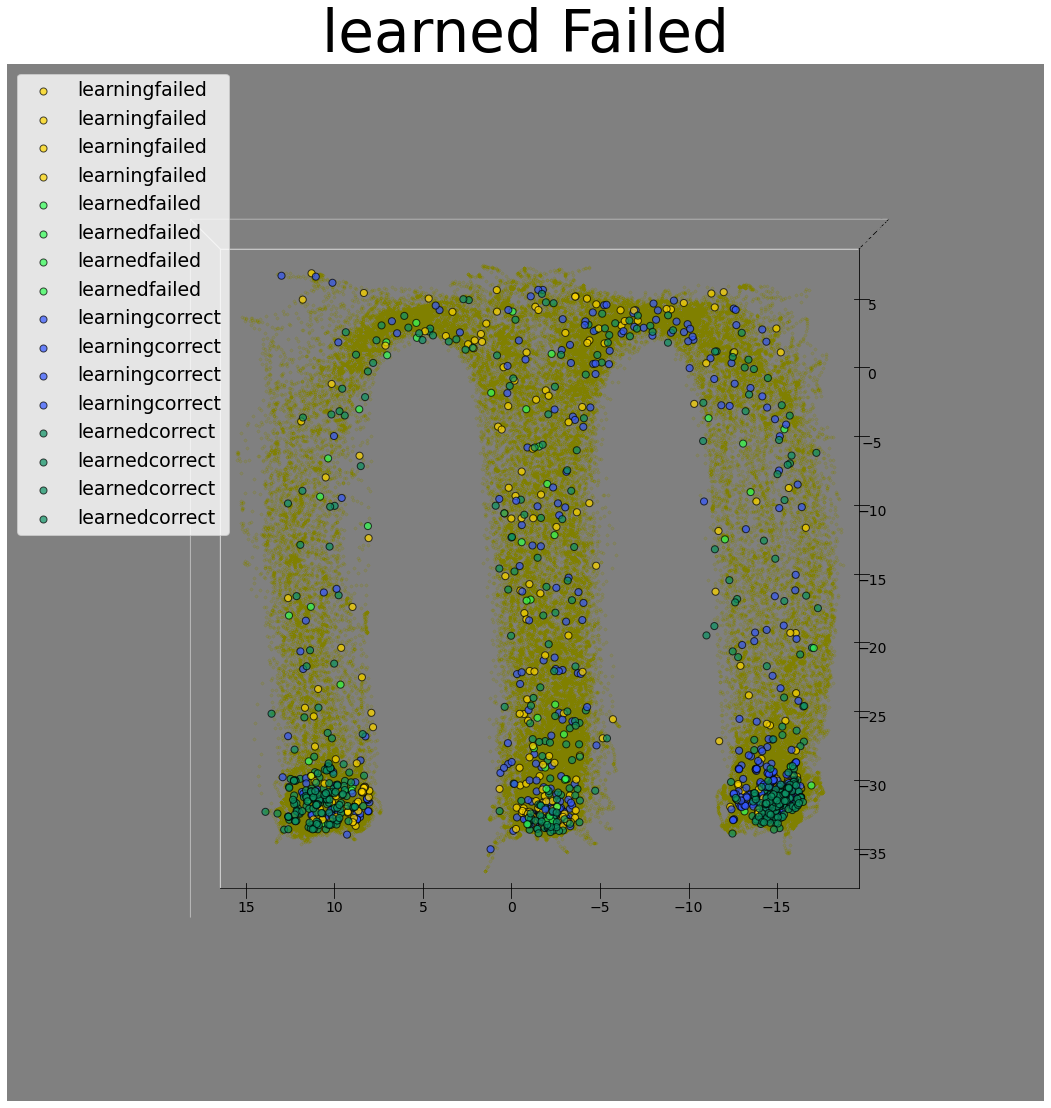

In [79]:
#viridis_cmap = plt.get_cmap('viridis', n_clusters)
tasks=['sampling','outward','reward','inward']
colorlist_4 = ['#FF5733', '#FFD700', '#33FF57', '#3357FF', '#0d9265']#generate_hex_colors(5)
plt.rcParams.update({'font.size': 19})
plt.rcParams['axes.titlesize'] = 19  # Set the title font size
plt.rcParams['xtick.labelsize'] = 14  # You can adjust the font size as needed
plt.rcParams['ytick.labelsize'] = 14  # You can adjust the font size as needed


fig2,ax2=plt.subplots(1,4,figsize=(30,4))
fig,ax=plt.subplots(1,4,figsize=(10,5))

figs=plt.figure(figsize=(60,60))
ax5s=figs.add_axes([1/len(tasks),0.1,1/len(tasks)-.01,.4],projection='3d', facecolor='white')
cnt=0
for trial_type in range(2):
    fr_trial={}
    #sessin_numbers=np.arange(len(session_mask))

    if trial_type==1:
        typename='correct'
    elif trial_type==0:
        typename='failed'

    for phase in range(2):
        if phase==1:
            phname='learned'
        elif phase==0:
            phname='learning'
        cnt+=1
        #figs.patch.set_facecolor('black')
        cond_clst_idx={}
        for icond,cond_number in enumerate(cond_numbers.keys()):

            name_cond=phname+' '+type_name

            if ('outward' in cond_number) | ('inward' in cond_number):
                speed_thr=0
                
            elif ('sampling' in cond_number) | ('reward' in cond_number):
                #continue
                speed_thr=0
            # add the mask for speed. speed threshold is set to 5.
            #speed_thr=0
            smooth_speed=mot.smooth_signal(sess_info['speed'], 13)# moving average over .5  second
            Masks['speed_seq']=np.asarray(smooth_speed)[sess_info['id_peaks']]>speed_thr
            Masks['speed'] = smooth_speed>speed_thr


            run_data_all = mot.apply_masks_test(sess_info2,Masks2,cond_numbers[cond_number],cond_names,sessin_numbers,odd_even,session_mask,trial_type,phase)
            trial_number=len(np.unique(run_data_all['trial_idx_mask']))

            #colorlist = generate_hex_colors(np.max(sess_info['ids_clust'])+2)

            ### plot 3d animal's position+speed
            ax5s.set_title(name_cond,fontsize=58,color='black')
            X_loc_sess_peaks=(np.asarray(sess_info['xloc'])[run_data_all['idpeaks']])
            Y_loc_sess_peaks=(np.asarray(sess_info['yloc'])[run_data_all['idpeaks']])
            speed_sess_peaks=(np.asarray(sess_info['speed'])[run_data_all['idpeaks']])
            colrlst = np.asarray(colorlist_4)[cnt]
            ax5s.scatter(X_loc_sess_peaks, Y_loc_sess_peaks,np.ones(len(Y_loc_sess_peaks))*speed_sess_peaks,"X",s=50,c=colrlst,alpha=.71,edgecolor='black',label=phname+typename)
            ax5s.plot(run_data_all['x_loc'],run_data_all['y_loc'], '.',color='gray',alpha=.01)
            ax5s.plot(sess_info['xloc'],sess_info['yloc'], '.',color='yellow',alpha=.009)
            ax5s.set_facecolor('grey') 
            ax5s.grid(False) 
            # ax5s.w_xaxis.pane.fill = False
            # ax5s.w_yaxis.pane.fill = False
            # ax5s.w_zaxis.pane.fill = False
            ax5s.xaxis.pane.fill = False
            ax5s.yaxis.pane.fill = False
            ax5s.zaxis.pane.fill = False

            ax5s.tick_params(axis='z', colors='gray',labelsize=22)
            ax5s.view_init(elev=-90, azim=90)
            #ax5s.view_init(elev=25, azim=-45)
            #ax5s.view_init(elev=0, azim=0)
            cond_clst_idx[cond_number] = run_data_all['ids_clust']

            #customPalette = sns.set_palette(sns.color_palette(colrlst))# Use the parameter palette and use your own palette across all your
            #sns.set_palette(sns.color_palette(colorlist))
            sns.histplot(data=cond_clst_idx,y=cond_number ,kde=False,ax=ax[icond],edgecolor='black',bins=np.arange(n_clusters+2),color=color,)
            # for ic in range(len(ax[icond].patches)):
            #     ax[icond].patches[ic].set_facecolor(colorlist[ic])


            ax[icond].text(2,-1,'trial # = ' +str(trial_number))
            #sns.histplot(cond_clst_idx[cond_number], kde=False, ax=ax[icond])
            ax[icond].set_ylim(-3, np.max(sess_info['ids_clust'])+2)
            #ax[icond].set_xlim(0, 80)
            ax[icond].set_title(f' {cond_number}'+' speed thr='+str(speed_thr),fontsize=14)
            ax[icond].set_ylabel('Cluster #',fontsize=14)
            ax[icond].set_xlabel('Sequence counts',fontsize=14)

            #plt.ylim([-1,np.max(sess_info['ids_clust'])])
            ispk=0
            for sspk in run_data_all['spike_idx_cells']:
                ax2[icond].eventplot(sspk,lineoffsets=ispk)
                ispk+=1
            ax2[icond].set_title(cond_number+'  '+fol1+' '+type_name+' '+phase_name+' '+place_cell_name+' '+cell_types)
            ax2[icond].set_ylabel('cell#')


        #plt.suptitle(fol1+'_'+'all'+'_'+type_name+'_'+place_cell_name+phase_name+'_'+cell_types)
plt.tight_layout()

# Get handles and labels for the legend
# handles, labels = ax5s.get_legend_handles_labels()

# # Remove duplicates
# unique_labels = dict(zip(labels, handles))

# # Add the legend with unique labels
# ax5s.legend(unique_labels.values(), unique_labels.keys())


ax5s.legend()

In [ ]:
Masks.keys()

dict_keys(['conditions', 'sessions', 'phases', 'bursts_cond', 'bursts_sess', 'bursts_phase', 'odd_even', 'odd_even_seqs', 'cell_cond', 'cell_sess', 'cell_phase', 'correct_failed', 'correct_failed_seqs', 'correct_failed_fr', 'fr_phase', 'fr_cond', 'fr_sess', 'odd_even_fr', 'correct_trial_idx_mask', 'failed_trial_idx_mask', 'trial_idx_mask', 'correct_trial_idx_mask_fr', 'correct_trial_idx_mask_burst', 'failed_trial_idx_mask_fr', 'failed_trial_idx_mask_burst', 'trial_number', 'Spike_binary_cells', 'Spike_binary'])

In [ ]:
# nmeoftrial=['correct','failed']

# for iss, entropy in Entropy_subsamplings.items():
#     if iss >2:
#         break
#     plot_entropy(entropy,titlename=str(iss))

    # fig,ax=plt.subplots(2,1,)

    # for ix, namtrl in enumerate(nmeoftrial):

    #     data1=entropy[namtrl]

    #     learning_values = [data1[key] for key in data1 if 'learning' in key]
    #     learned_values = [data1[key] for key in data1 if 'learned' in key]

    #     # Create labels for the conditions
    #     conditions = [key.split('_')[1] for key in data1 if 'learning' in key]

    #     # Plotting the bar graph
    #     width = 0.35
    #     bar1 = ax[ix].bar(conditions, learning_values, width, label='Learning')
    #     bar2 = ax[ix].bar([i + width for i in range(len(conditions))], learned_values, width, label='Learned')

    #     # Adding labels, title, and legend
    #     ax[ix].set_ylabel('Entropy',fontsize=16)
    #     ax[ix].set_title(fol+' '+namtrl+' '+burst_len+' iss'+str(iss))
    #     if ix==10:
    #         ax[ix].legend()

    # # Show the plot
    # plt.tight_layout()
    # plt.show()

# with open(savefolder+fol+'Entropy'+'_'+place_cell_name+' '+cell_types+descriotor,'wb') as f:
#     pickle.dump(entropy, f) 

In [ ]:
descriotor

'No_chunk_0.5s_transientsRandomized_seqs'

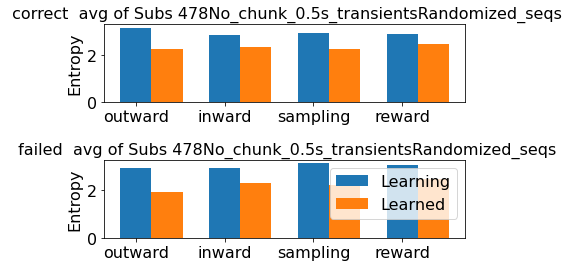

In [ ]:
plt.rcParams.update({'font.size': 16})
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['xtick.labelsize'] = 16  # You can adjust the font size as needed
plt.rcParams['ytick.labelsize'] = 16  # You can adjust the font size as needed

# Test the function with the provided dictionary
averaged_data = mot.average_similar_keys(Entropy_subsamplings)

mot.plot_entropy(averaged_data,titlename='avg of Subs '+fol1+descriotor)
#plt.suptitle(fol1+descriotor)

plt.savefig(savefolder+'Entropy_ss_avg'+fol1+'.png')
with open(savefolder+fol1+'Entropy_ss_avg'+'_'+place_cell_name+' '+cell_types+descriotor,'wb') as f:
    pickle.dump(averaged_data, f) 

## Plot Entropy of Original data(without equal sequence number for learning and learned)

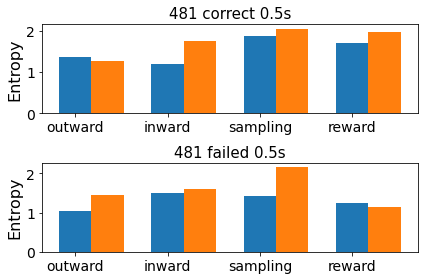

In [19]:
entropy=np.load(savefolder+fol1+'Entropy'+'_'+place_cell_name+' '+cell_types+''+descriotor,allow_pickle=True)
fol1+'Entropy'+'_'+place_cell_name+' '+cell_types+''+descriotor

nmeoftrial=['correct','failed']
fig,ax=plt.subplots(2,1,)


for ix, namtrl in enumerate(nmeoftrial):

    data1=entropy[namtrl]

    learning_values = [data1[key] for key in data1 if 'learning' in key]
    learned_values = [data1[key] for key in data1 if 'learned' in key]

    # Create labels for the conditions
    conditions = [key.split('_')[1] for key in data1 if 'learning' in key]

    # Plotting the bar graph
    width = 0.35
    bar1 = ax[ix].bar(conditions, learning_values, width, label='Learning')
    bar2 = ax[ix].bar([i + width for i in range(len(conditions))], learned_values, width, label='Learned')

    # Adding labels, title, and legend
    ax[ix].set_ylabel('Entropy',fontsize=16)
    ax[ix].set_title(fol1+' '+namtrl+' '+burst_len)
    if ix==10:
        ax[ix].legend()

# Show the plot
plt.tight_layout()
plt.show()

## Compute seqence rate and plot it for learning and learned separately

In [ ]:
plt.rcParams.update({'font.size': 16})
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['xtick.labelsize'] = 16  # You can adjust the font size as needed
plt.rcParams['ytick.labelsize'] = 16  # You can adjust the font size as needed

cond_results={'fr':{},'motif_nbr':{},'cluster_dist':{},'firingrates':{}}
equal_tial=False
odd_even=None
equality='nonequal'
if equal_tial==True:
    equality='equal'

#trial_type=1# 1 is correct       0 is failed

entropy={'correct':{},'failed':{}}

for trial_type in range(2):
    fr_trial={}
    
    sessin_numbers=np.arange(len(session_mask))



    phase=0 # learning
    if trial_type==1:
        typename='correct'
    elif trial_type==0:
        typename='failed'

    for cond_number_name in cond_numbers.keys():
        cond_number_= cond_numbers[cond_number_name]
        run_data_all_cond=mot.apply_masks_test(sess_info,Masks,cond_number_,cond_names,sessin_numbers,odd_even,session_mask,trial_type,phase)
        cond_results['firingrates'][cond_number_name+'learning'+typename]=run_data_all_cond['fr']

        #cond_results['fr']['learning_'+cond_number_name]=np.mean(fs*run_data_all_cond['fr'])
        cond_results['fr']['learning_'+cond_number_name]= fs*len(run_data_all_cond['seqs'])/len(run_data_all_cond['poprate'])

        cond_results['motif_nbr']['learning_'+cond_number_name]=len(np.unique(run_data_all_cond['ids_clust']))

        id_clusters = run_data_all_cond['ids_clust']
        labels, counts = np.unique(id_clusters, return_counts=True)
        cond_results['cluster_dist']['learning_'+cond_number_name] = {'seq_len':len(id_clusters),'cluster_number': labels, 'clsuster_counts':counts}


        fr_trial['learning_'+cond_number_name]=np.mean(fs*(run_data_all_cond['fr']))
        #print(cond_number_name,len(run_data_all_cond['poprate']))
        print('ing',cond_number_name,equality,len(np.unique(run_data_all_cond['ids_clust'])))


    phase=1 # learned
    #cond_info={}
    for cond_number_name in cond_numbers.keys():
        cond_number_= cond_numbers[cond_number_name]
        run_data_all_cond=mot.apply_masks_test(sess_info,Masks,cond_number_,cond_names,sessin_numbers,odd_even,session_mask,trial_type,phase)
        cond_results['firingrates'][cond_number_name+'learned'+typename]=run_data_all_cond['fr']

        #cond_results['fr']['learned_'+cond_number_name]=np.mean(fs*run_data_all_cond['fr'])
        cond_results['fr']['learned_'+cond_number_name]= fs*len(run_data_all_cond['seqs'])/len(run_data_all_cond['poprate'])

        cond_results['motif_nbr']['learned_'+cond_number_name]=len(np.unique(run_data_all_cond['ids_clust']))

        id_clusters = run_data_all_cond['ids_clust']
        labels, counts = np.unique(id_clusters, return_counts=True)
        cond_results['cluster_dist']['learned_'+cond_number_name] = {'seq_len':len(id_clusters),'cluster_number': labels, 'clsuster_counts':counts}

        #print(cond_number_name,len(run_data_all_cond['poprate']))
        print('ed',cond_number_name,equality,len(np.unique(run_data_all_cond['ids_clust'])))
        fr_trial['learned_'+cond_number_name]=np.mean(fs*(run_data_all_cond['fr']))






    plt.rcParams.update({'font.size': 16})
    plt.rcParams['axes.titlesize'] = 17  # Set the title font size
    motif_diffs = mot.find_diffs(cond_results['motif_nbr'],pairs)
    mot.diff_bar_plot(motif_diffs,'Change in motif number of '+typename+' trials '+ fol+' '+cell_types)

    plt.savefig(savefolder+'motifnumber'+fol+'.png')

    #motif_diffs = mot.find_diffs(cond_results['fr'],pairs)
    motif_diffs = mot.find_diffs(fr_trial,pairs)



    mot.diff_bar_plot(motif_diffs,'Change in sequence rate of '+typename+' trials ' + fol+' '+cell_types)
    plt.savefig(savefolder+'firingrate'+fol+'.png')








    # compute diversity index for different qs
    Div_idxq={}

    for epochs in cond_results['cluster_dist'].keys():
        data=cond_results['cluster_dist'][epochs]
        diq=[]
        xq=np.arange(0.011,5.51,.1)
        xq[0]=0
        for q in (xq):
            
            diq.append( mot.calculate_diversity_q(data,q))
        
        Div_idxq[epochs]=diq
        entropy[typename][epochs]=Div_idxq[epochs][1]

    mot.plot_diversity_index(Div_idxq,fol+' '+typename+' '+equality+' '+place_cell_name+' '+cell_types,xq)

    plt.savefig(savefolder+fol+'DI'+type_name+' '+place_cell_name+' '+cell_types+descriotor+'.png')


NameError: name 'session_mask' is not defined

In [20]:

allfolders2 = ['481', '483', '485', '478']
rows_list = []

for fol1 in allfolders2:
    allccrs,cond_results_allsess_loaded=np.load(savefolder+fol1+'pvalues'+'_'+place_cell_name+'_'+cell_types+'_'+descriotor,allow_pickle=True)

    
    for session_name, session_data in cond_results_allsess_loaded.items():
        # Determine session type based on session name or another attribute
        session_type = 'learned' if 'learned' in session_name else 'learning'
        
        for category, value in session_data['firingrates'].items():
            label = 'failed' if 'failed' in category else 'correct'
            type_clean = category.replace('failed', '').replace('correct', '')
            
            trial_nbr = len((session_data['firingrates'][category]))
            if 'inward' in category or 'outward' in category:
                trial_nbr=trial_nbr/2
            row = {
                'Experiment': fol1,
                'Session': session_name,
                'Category': session_type,
                'Metric': type_clean,
                'ResultType': label,
                'Value': value,
                'Trial_cnt': trial_nbr
            }
            rows_list.append(row)

df_fr = pd.DataFrame(rows_list)

In [21]:
allfolders2 = ['481', '483', '485', '478']
rows_list = []

for fol1 in allfolders2:
    cond_results_allsess_all=np.load(savefolder+fol1+'fr_all'+'_'+place_cell_name+' '+cell_types+'both'+descriotor,allow_pickle=True)
    
    Session_nbr=0
    for session_name, session_data in cond_results_allsess_all['both'].items():
        # Determine session type based on session name or another attribute
        session_type = 'learned' if 'learned' in session_name else 'learning'
        Session_nbr+=1
        for category, value in session_data['firingrates'].items():
            label = 'failed' if 'failed' in category else 'correct'
            type_clean = category.replace('failed', '').replace('correct', '')
            
            trial_nbr = len((session_data['firingrates'][category]))
            if 'inward' in category or 'outward' in category:
                trial_nbr=trial_nbr/2
            row = {
                'Experiment': fol1,
                'Session': session_name,
                'Category': session_type,
                'Metric': type_clean,
                'ResultType': label,
                'Value': value,
                'Trial_cnt': trial_nbr,
                'Session_nbr': Session_nbr
            }
            rows_list.append(row)

df_fr_single_trials = pd.DataFrame(rows_list)


In [22]:

# Extract features and labels
df_fr_trl_anim = df_fr_single_trials[df_fr_single_trials['Experiment'] == '481']
X = df_fr_trl_anim[['Value', 'Trial_cnt', 'Session_nbr']]  # Adjust feature columns as per your data
y = df_fr_trl_anim['ResultType']  # Assuming 'ResultType' contains the class labels

# Unique sessions in the dataset
sessions = df_fr_trl_anim['Session'].unique()
df_fr_trl_anim['ResultType'] = df_fr_trl_anim['ResultType'].map({'failed': 0, 'correct': 1})


C:\Users\hamed\AppData\Local\Temp\ipykernel_2920\3376054936.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_fr_trl_anim['ResultType'] = df_fr_trl_anim['ResultType'].map({'failed': 0, 'correct': 1})


In [ ]:
sessions

array(['20220214_gcamp6f483_task_learning.mat',
       '20220215_gcamp6f483_task_learning.mat',
       '20220216_gcamp6f483_task_learning.mat',
       '20220217_gcamp6f483_task_learning.mat',
       '20220306_gcamp6f483_task_learned.mat',
       '20220307_gcamp6f483_task_learned.mat',
       '20220308_gcamp6f483_task_learned.mat',
       '20220309_gcamp6f483_task_learned.mat',
       '20220315_gcamp6f483_task_learned.mat'], dtype=object)

C:\Users\hamed\AppData\Local\Temp\ipykernel_2920\3583658893.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_fr_trl_anim['ResultType'] = df_fr_trl_anim['ResultType'].map({'failed': 0, 'correct': 1})
c:\Users\hamed\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\hamed\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\hamed\anaco

acc 0.0     sess 20220214_gcamp6f483_task_learning.mat     len test 11      len train 282
acc 0.0     sess 20220215_gcamp6f483_task_learning.mat     len test 17      len train 276
acc 0.0     sess 20220216_gcamp6f483_task_learning.mat     len test 24      len train 269
acc 0.0     sess 20220217_gcamp6f483_task_learning.mat     len test 24      len train 269
acc 0.0     sess 20220306_gcamp6f483_task_learned.mat     len test 48      len train 245
acc 0.0     sess 20220307_gcamp6f483_task_learned.mat     len test 45      len train 248
acc 0.0     sess 20220308_gcamp6f483_task_learned.mat     len test 44      len train 249
acc 0.0     sess 20220309_gcamp6f483_task_learned.mat     len test 38      len train 255
acc 0.0     sess 20220315_gcamp6f483_task_learned.mat     len test 42      len train 251
Average Accuracy: 0.0


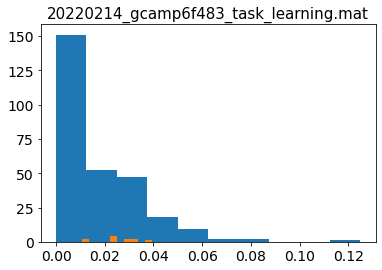

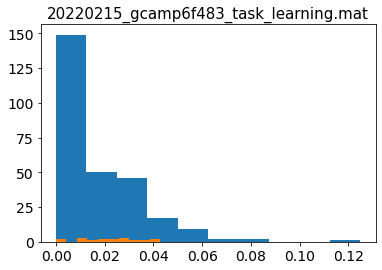

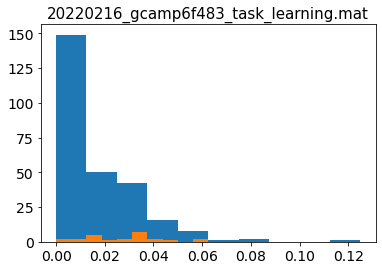

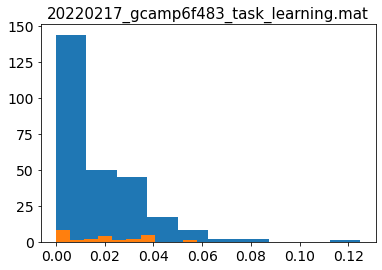

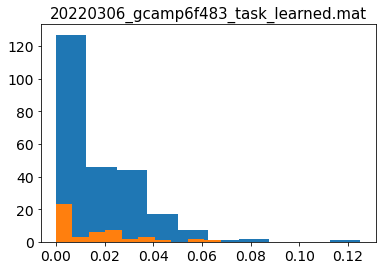

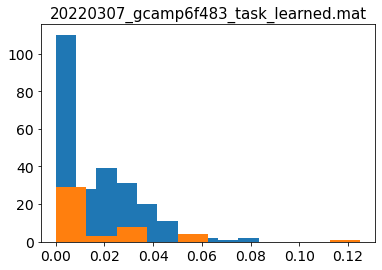

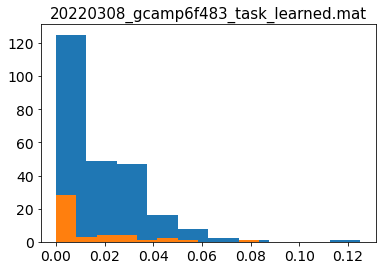

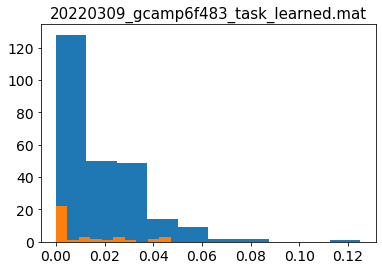

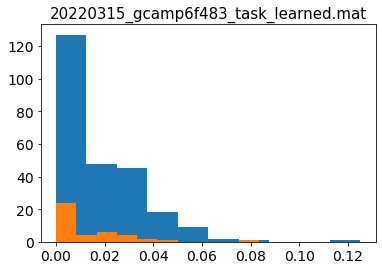

In [24]:
import pandas as pd
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import accuracy_score

# Load your dataset
# Assuming your dataset is stored in a DataFrame named 'data'
# Replace 'data.csv' with the actual file path if loading from a CSV file
#data = pd.read_csv('data.csv')
# Extract features and labels
df_fr_trl_anim = df_fr_single_trials[(df_fr_single_trials['Experiment']=='483') & (df_fr_single_trials['Metric']=='sampling')]

# Unique sessions in the dataset
sessions = df_fr_trl_anim['Session'].unique()
df_fr_trl_anim['ResultType'] = df_fr_trl_anim['ResultType'].map({'failed': 0, 'correct': 1})

# Initialize variables to store accuracy for each session
accuracies = []

# Leave-one-out cross-validation
for session in sessions:
    # Split data into training and testing sets
    train_data = df_fr_trl_anim[df_fr_trl_anim['Session'] != session]
    test_data = df_fr_trl_anim[df_fr_trl_anim['Session'] == session]
    
    X_train = train_data['Value'].values.tolist()   # Adjust feature columns as per your data
    y_train = train_data['ResultType'].tolist()  # Assuming 'ResultType' contains the class labels
    
    X_test = test_data['Value'].values.tolist()  # Adjust feature columns as per your data
    y_test = test_data['ResultType'] .tolist()  # Assuming 'ResultType' contains the class labels
    

    flattened_x_train = np.concatenate(X_train).reshape(-1, 1)
    y_train_flat = np.repeat(y_train, [len(row) for row in X_train]).reshape(-1, 1)

    flattened_x_test = np.concatenate(X_test).reshape(-1, 1)
    y_test_flat = np.repeat(y_test, [len(row) for row in X_test]).reshape(-1, 1)

    plt.figure()
    plt.hist(flattened_x_train)
    plt.hist(flattened_x_test)
    plt.title(session)

    # Train LDA model
    lda = LinearDiscriminantAnalysis()
    lda.fit(flattened_x_train, y_train_flat)  

    # Evaluate the model
    y_pred = lda.predict(y_test_flat)
    
    # Calculate accuracy
    accuracy = accuracy_score(y_pred, y_test_flat.reshape(1,-1)[0])
    print('acc',accuracy, '    sess',session, '    len test', len(y_test_flat),'     len train',len(y_train_flat))
    # Store accuracy for this session
    accuracies.append(accuracy)

# Calculate average accuracy across all sessions
average_accuracy = sum(accuracies) / len(accuracies)
print("Average Accuracy:", average_accuracy)


In [ ]:
X_test

[]

In [ ]:
import pandas as pd
import numpy as np
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import accuracy_score



# Convert ResultType into a binary class
df_fr_single_trials['ResultType'] = df_fr_single_trials['ResultType'].map({'failed': 0, 'correct': 1})

# Leave-One-Out Cross-Validation
loo = LeaveOneOut()
X = df_fr_single_trials['Value_mean'].values
y = df_fr_single_trials['ResultType'].values

lda = LinearDiscriminantAnalysis()

accuracies = []
for train_index, test_index in loo.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    lda.fit(X_train, y_train)
    y_pred = lda.predict(X_test)
    
    acc = accuracy_score(y_test, y_pred)
    accuracies.append(acc)

# Overall LOO-CV performance
overall_accuracy = np.mean(accuracies)
overall_accuracy


KeyError: 'Value_mean'

In [ ]:
df_fr_single_trials[(df_fr_single_trials['Experiment']=='481') & (df_fr_single_trials['Session_nbr']==9) & (df_fr_single_trials['Metric']=='inward')]

,Experiment,Session,Category,Metric,ResultType,Value,Trial_cnt,Session_nbr
65,481,20220327_gcamp6f481_task_learned.mat,learned,inward,failed,"[0.0, 0.0]",1.0,9
69,481,20220327_gcamp6f481_task_learned.mat,learned,inward,correct,"[0.06666666666666667, 0.06756756756756757, 0.0...",26.0,9


In [ ]:
## leave one out (Sessions)




In [ ]:

        rndmidx=np.arange(len(labels))
        random.shuffle(rndmidx)

        seqrates_rnd=seqrates[rndmidx]
        labels_rnd=labels[rndmidx]
        #LDA_seqrate(seqrates_rnd,labels_rnd,cod)

        x_dt=seqrates_rnd
        y_lb=labels_rnd
        if len(np.unique(y_lb))<2:
            continue  
        Ccrs=mot.train_test_model(x_dt,y_lb,subsamplings=samplingnumber)
        ccr_mean=np.nanmean(Ccrs)

In [ ]:
ises* np.ones(len(fr_corr_and_failed))

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [ ]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
# analys correct trials on learned or learning data using firing rates
oversampling=False# if you want to have equal size of learning and learned samples(reapated samples)
phasename='both'

seq_rate_len={}
pval_all_sess={}
for sessname in cond_results_allsess_all[phasename].keys():
    performanc=dict(correctrate)[sessname]
    
    cond_results = cond_results_allsess_all[phasename][sessname]
    pval_real_data={ 'inward':{},'sampling':{},'outward':{}}
    fr_len= {'correct':[],'failed':[]}
    #conds=['sampling','inward','outward','reward']


    shufflenumber=100
    samplingnumber=100
    for cod in pval_real_data.keys():

        if len([x for x in cond_results['firingrates'].keys() if cod in x])<1:

            continue

        fr_correcnt= cond_results['firingrates'][cod+'correct']
        fr_failed= cond_results['firingrates'][cod+'failed']    

        if len(fr_correcnt)<trial_thr or len(fr_failed)<trial_thr :# exclude session with very small trial number


            pval_real_data[cod]['pval'] =[]
            pval_real_data[cod]['mean_ccr'] =[]
            continue

        fr_len['correct']=len(fr_correcnt) 
        fr_len['failed']=len(fr_failed) 

        lebel_correct=1+np.zeros(len(fr_correcnt)).astype(int)
        lebel_failed=np.zeros(len(fr_failed)).astype(int)

        labels=np.concatenate((lebel_correct,lebel_failed))
        seqrates=np.concatenate((fr_correcnt,fr_failed)).reshape(-1, 1)
        # Combine the oversampled minority class with the majority class
        #balanced_dataset = np.vstack((majority_class, oversampled_minority_class))




        rndmidx=np.arange(len(labels))
        random.shuffle(rndmidx)

        seqrates_rnd=seqrates[rndmidx]
        labels_rnd=labels[rndmidx]
        #LDA_seqrate(seqrates_rnd,labels_rnd,cod)

        x_dt=seqrates_rnd
        y_lb=labels_rnd
        if len(np.unique(y_lb))<2:
            continue  
        Ccrs=mot.train_test_model(x_dt,y_lb,subsamplings=samplingnumber)
        ccr_mean=np.nanmean(Ccrs)
        if np.isnan(ccr_mean):
           raise SystemExit("Encountered NaN, stopping execution.")



        y_sh=np.copy(y_lb)
        
        sh_dist=[]
        for sh in range(shufflenumber):
            random.shuffle(y_sh)
            if np.sum(np.asarray(x_dt)[np.asarray(y_sh==0)])==0:
                continue
            
            Ccrs_sh=mot.train_test_model(x_dt,y_sh,subsamplings=samplingnumber)
            sh_dist.append(np.mean(Ccrs_sh))
        if 0:
            plt.figure()
            plt.hist(sh_dist,alpha=.4)
            #
            plt.hist(Ccrs,alpha=.4)
            plt.vlines(ccr_mean,0,shufflenumber,color='red',linestyle='dashed')
            plt.title(cod+sessname)
        pval=1-np.sum(ccr_mean>sh_dist)/len(sh_dist)
        pval_real_data[cod]['pval'] = round(pval, 2)
        pval_real_data[cod]['mean_ccr'] =round(ccr_mean, 2)
        pval_real_data[cod]['performance'] =performanc
    if len(fr_correcnt)>0 and len(fr_failed)>0 :
        
        pval_all_sess[sessname]=pval_real_data
        seq_rate_len[sessname]=fr_len

pval_and_fr = [pval_all_sess, cond_results_allsess_all[phasename] ]
with open(savefolder+fol1+'pvalues'+ '_'+place_cell_name+'_'+cell_types+'_'+descriotor,'wb') as f:
    pickle.dump(pval_and_fr, f) 

In [ ]:
cond_results_allsess_all['both']

{'20220214_gcamp6f478_task_learning.mat': {'fr': {'outwardfailed': 0.5967078189300411,
   'inwardfailed': 0.3516819571865443,
   'samplingfailed': 0.5139664804469274,
   'rewardfailed': 0.411214953271028,
   'outwardcorrect': 0.5561993047508691,
   'inwardcorrect': 0.2991772625280479,
   'samplingcorrect': 0.5836139169472503,
   'rewardcorrect': 0.28421839940164545},
  'motif_nbr': {'outwardfailed': 5,
   'inwardfailed': 6,
   'samplingfailed': 4,
   'rewardfailed': 4,
   'outwardcorrect': 8,
   'inwardcorrect': 5,
   'samplingcorrect': 6,
   'rewardcorrect': 8},
  'cluster_dist': {'outwardfailed': {'seq_len': 29,
    'cluster_number': array([ 9, 20, 21, 22, 24], dtype=int64),
    'clsuster_counts': array([ 1, 17,  5,  2,  4], dtype=int64)},
   'inwardfailed': {'seq_len': 23,
    'cluster_number': array([ 5, 19, 20, 21, 22, 24], dtype=int64),
    'clsuster_counts': array([ 1,  1, 16,  1,  1,  3], dtype=int64)},
   'samplingfailed': {'seq_len': 23,
    'cluster_number': array([ 9, 18, 1